<a href="https://colab.research.google.com/github/runnin123/Jeju_Bigdata/blob/master/Jeju_bigdata_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [ ]:
# 나눔고딕 설치(설치 후 런타임 다시 시작)
!apt -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

In [ ]:
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

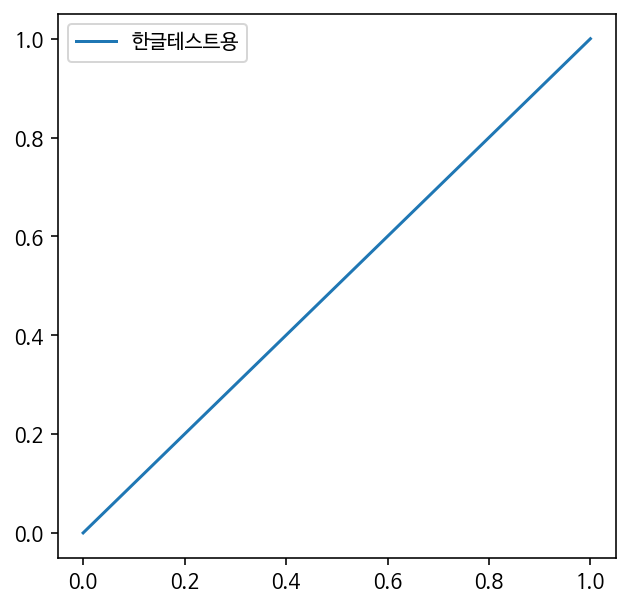

In [ ]:
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], label='한글테스트용')
plt.legend()
plt.show()

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import bigquery
from tabulate import tabulate
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from itertools import product

# 평가 메트릭
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 통계
from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/jeju/201901-202003.csv')

In [ ]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [ ]:
# 날짜 처리
data = train.copy()
data = data.fillna('')
print(data['REG_YYMM'].head())

0    201901
1    201901
2    201901
3    201901
4    201901
Name: REG_YYMM, dtype: int64


In [ ]:
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data['REG_YYMM'] = data['REG_YYMM'].apply(str)

In [ ]:
df = data.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)
columns = ['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
df = df.groupby(columns).sum().reset_index(drop=False)

df.head()

REG_YYMM CARD_SIDO_NM STD_CLSS_NM HOM_SIDO_NM  ... month  CSTMR_CNT      AMT  CNT
0   201901           강원  건강보조식품 소매업          강원  ...     1          4   311200    4
1   201901           강원  건강보조식품 소매업          강원  ...     1         44  5169295   45
2   201901           강원  건강보조식품 소매업          강원  ...     1         89  8618550   91
3   201901           강원  건강보조식품 소매업          강원  ...     1          3   454420    3
4   201901           강원  건강보조식품 소매업          강원  ...     1         53  6441165   60

[5 rows x 12 columns]

In [ ]:
# matplotlib 차트 크기 설정
plt.rcParams["figure.figsize"] = (14,8) # 가로, 세로 인치 단위 크기
plt.rcParams['lines.linewidth'] = 2 # 선 두께
plt.rcParams['lines.color'] = 'r' # 선 색깔
plt.rcParams['axes.grid'] = True # 격자선 표시 여부

In [ ]:
# df에서 날짜, 카드 가맹점(시도 기준), 이용 금액 column 추출
temp = df[['REG_YYMM', 'CARD_SIDO_NM', 'AMT']]

In [ ]:
# 2020년 1월 ~ 2020년 3월 까지의 데이터만 추출
temp = temp[(temp['REG_YYMM'] == '202001') | (temp['REG_YYMM'] == '202002') | (temp['REG_YYMM'] == '202003')].reset_index(drop = True)

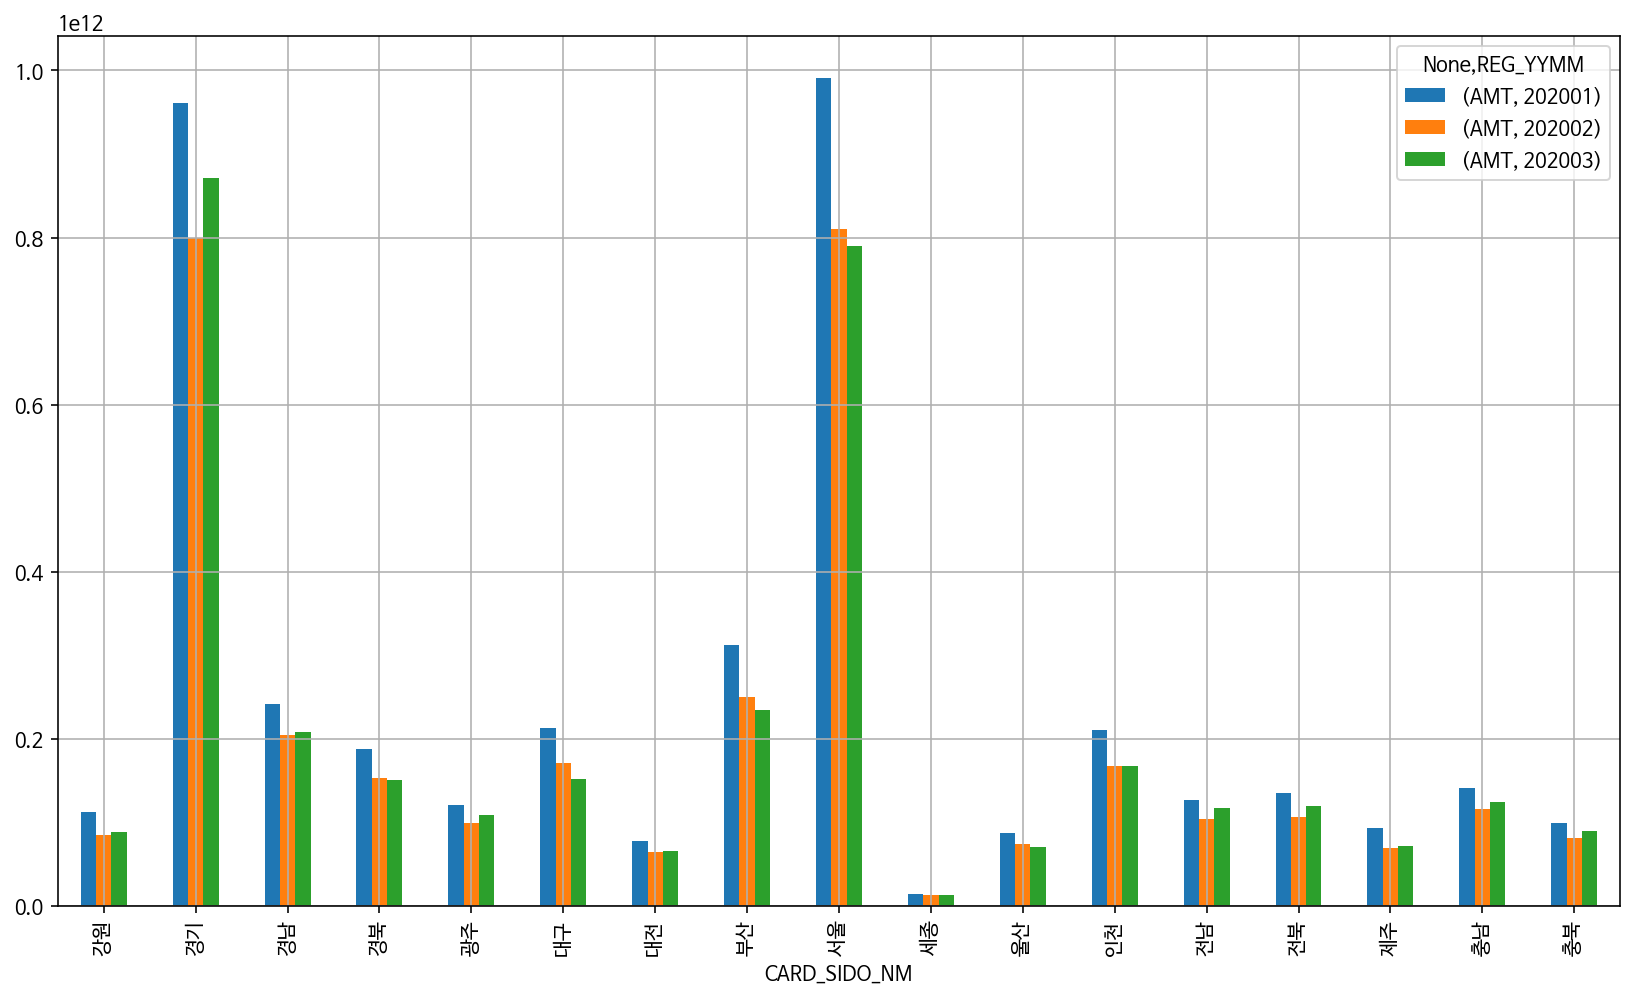

In [ ]:
# 카드 가맹점(시도 기준), 날짜로 묶어 AMT의 총 합 그래프 확인
temp.groupby(['CARD_SIDO_NM', 'REG_YYMM']).sum().unstack().plot.bar()

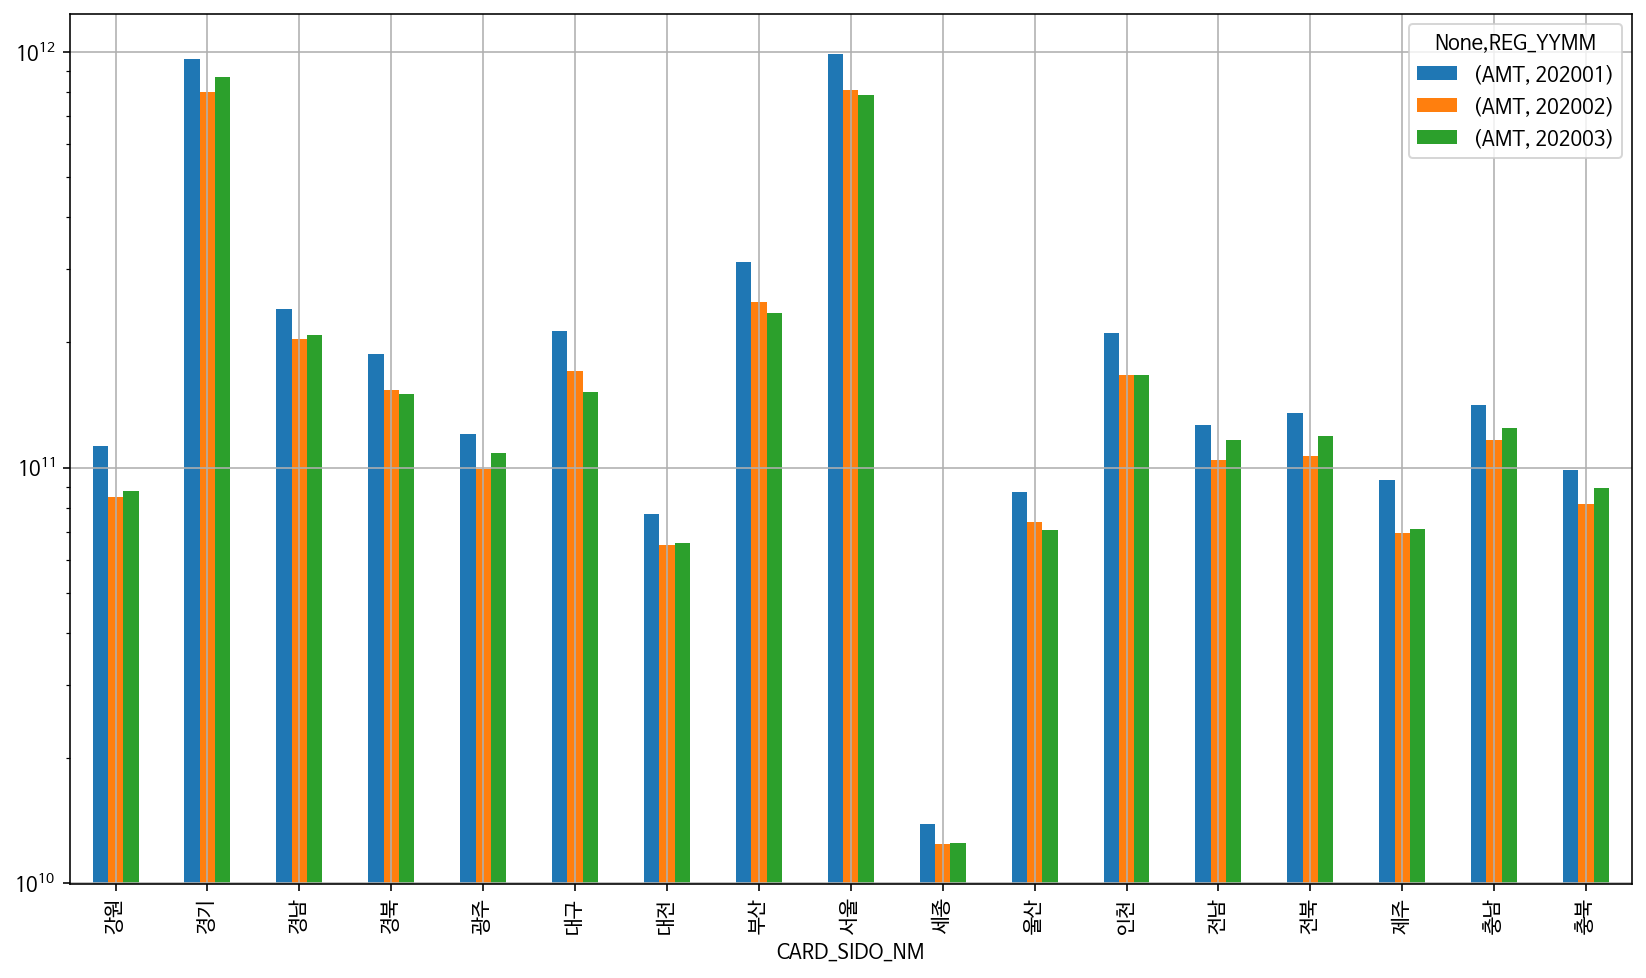

In [ ]:
# 카드 가맹점(시도 기준), 날짜로 묶어 AMT의 총 합 그래프 확인(로그 스케일 적용)
temp.groupby(['CARD_SIDO_NM', 'REG_YYMM']).sum().unstack().plot.bar()
plt.yscale('log') # y 축 변수를 로그 스케일로 변환

AMT를 로그 스케일로 변환하지 않을 경우, 그 값이 작은 지역과 큰 지역간의 차이가 많이 난다. 축의 길이를 절약? 하기 위해 로그 스케일 적용.

참고) https://steemit.com/kr/@mastertri/6c5siq

대체로 1월 이후로는 매출이 하락.

그 중, 2월에 비해 상승하는 지역은 강원, 경기, 경남, 광주, 대전, 인천, 전남, 전북, 제주, 충남, 충북.

특히 경기, 광주, 전남, 전북, 충남, 충북이 비교적 크게 상승.

In [ ]:
# 2020년 1월 ~ 2020년 3월 까지의 업종, AMT 데이터 추출

temp02 = df[['REG_YYMM', 'STD_CLSS_NM', 'AMT']]
temp02 = temp02[(temp02['REG_YYMM'] == '202001') | (temp02['REG_YYMM'] == '202002') | (temp02['REG_YYMM'] == '202003')].reset_index(drop = True)
temp02.head()

REG_YYMM STD_CLSS_NM       AMT
0   202001  건강보조식품 소매업    168500
1   202001  건강보조식품 소매업    752646
2   202001  건강보조식품 소매업  11861410
3   202001  건강보조식품 소매업   9813125
4   202001  건강보조식품 소매업  10645775

In [ ]:
std_list = temp02['STD_CLSS_NM'].unique().tolist()
std_list

['건강보조식품 소매업',
 '골프장 운영업',
 '과실 및 채소 소매업',
 '관광 민예품 및 선물용품 소매업',
 '그외 기타 스포츠시설 운영업',
 '그외 기타 종합 소매업',
 '기타 대형 종합 소매업',
 '기타 수상오락 서비스업',
 '기타 외국식 음식점업',
 '기타 주점업',
 '기타음식료품위주종합소매업',
 '내항 여객 운송업',
 '마사지업',
 '면세점',
 '버스 운송업',
 '비알콜 음료점업',
 '빵 및 과자류 소매업',
 '서양식 음식점업',
 '수산물 소매업',
 '슈퍼마켓',
 '스포츠 및 레크레이션 용품 임대업',
 '여관업',
 '여행사업',
 '욕탕업',
 '육류 소매업',
 '일반유흥 주점업',
 '일식 음식점업',
 '자동차 임대업',
 '전시 및 행사 대행업',
 '중식 음식점업',
 '차량용 가스 충전업',
 '차량용 주유소 운영업',
 '체인화 편의점',
 '택시 운송업',
 '피자 햄버거 샌드위치 및 유사 음식점업',
 '한식 음식점업',
 '호텔업',
 '화장품 및 방향제 소매업',
 '휴양콘도 운영업',
 '그외 기타 분류안된 오락관련 서비스업',
 '정기 항공 운송업']

In [ ]:
# 업종 리스트를 삼등분해서 추출(업종이 총 41개로 너무 많기 때문)
std_list_01 = std_list[:14]
std_list_01

['건강보조식품 소매업',
 '골프장 운영업',
 '과실 및 채소 소매업',
 '관광 민예품 및 선물용품 소매업',
 '그외 기타 스포츠시설 운영업',
 '그외 기타 종합 소매업',
 '기타 대형 종합 소매업',
 '기타 수상오락 서비스업',
 '기타 외국식 음식점업',
 '기타 주점업',
 '기타음식료품위주종합소매업',
 '내항 여객 운송업',
 '마사지업',
 '면세점']

In [ ]:
# 업종 리스트 나머지 추출
std_list_02 = std_list[14:28]
std_list_02

['버스 운송업',
 '비알콜 음료점업',
 '빵 및 과자류 소매업',
 '서양식 음식점업',
 '수산물 소매업',
 '슈퍼마켓',
 '스포츠 및 레크레이션 용품 임대업',
 '여관업',
 '여행사업',
 '욕탕업',
 '육류 소매업',
 '일반유흥 주점업',
 '일식 음식점업',
 '자동차 임대업']

In [ ]:
std_list_03 = std_list[28:]
std_list_03

['전시 및 행사 대행업',
 '중식 음식점업',
 '차량용 가스 충전업',
 '차량용 주유소 운영업',
 '체인화 편의점',
 '택시 운송업',
 '피자 햄버거 샌드위치 및 유사 음식점업',
 '한식 음식점업',
 '호텔업',
 '화장품 및 방향제 소매업',
 '휴양콘도 운영업',
 '그외 기타 분류안된 오락관련 서비스업',
 '정기 항공 운송업']

In [ ]:
# temp02(업종별 이용금액)에서 std_list_01에 해당하는 업종 추출
temp02_std01 = temp02[temp02['STD_CLSS_NM'].isin(std_list_01)]
temp02_std01

REG_YYMM    STD_CLSS_NM        AMT
0        202001     건강보조식품 소매업     168500
1        202001     건강보조식품 소매업     752646
2        202001     건강보조식품 소매업   11861410
3        202001     건강보조식품 소매업    9813125
4        202001     건강보조식품 소매업   10645775
...         ...            ...        ...
185081   202003  기타음식료품위주종합소매업  209182715
185082   202003  기타음식료품위주종합소매업   99042460
185083   202003           마사지업     900000
185084   202003           마사지업     220000
185085   202003           마사지업    4591000

[44529 rows x 3 columns]

In [ ]:
# temp02(업종별 이용금액)에서 std_list_02에 해당하는 업종 추출
temp02_std02 = temp02[temp02['STD_CLSS_NM'].isin(std_list_02)]
temp02_std02

REG_YYMM STD_CLSS_NM       AMT
889      202001      버스 운송업     25000
890      202001      버스 운송업    194700
891      202001      버스 운송업     62300
892      202001      버스 운송업     50000
893      202001      버스 운송업     30000
...         ...         ...       ...
186052   202003     일식 음식점업  48238525
186053   202003     일식 음식점업  49872700
186054   202003     일식 음식점업  12080200
186055   202003     일식 음식점업   4226700
186056   202003     일식 음식점업    839000

[68312 rows x 3 columns]

In [ ]:
# temp02(업종별 이용금액)에서 std_list_03에 해당하는 업종 추출
temp02_std03 = temp02[temp02['STD_CLSS_NM'].isin(std_list_03)]
temp02_std03

REG_YYMM  STD_CLSS_NM       AMT
2571     202001  전시 및 행사 대행업  50636000
2572     202001  전시 및 행사 대행업    297700
2573     202001  전시 및 행사 대행업   2501800
2574     202001  전시 및 행사 대행업     69100
2575     202001  전시 및 행사 대행업    140000
...         ...          ...       ...
187293   202003     휴양콘도 운영업    385700
187294   202003     휴양콘도 운영업    790350
187295   202003     휴양콘도 운영업     99000
187296   202003     휴양콘도 운영업    228800
187297   202003     휴양콘도 운영업     51500

[74457 rows x 3 columns]

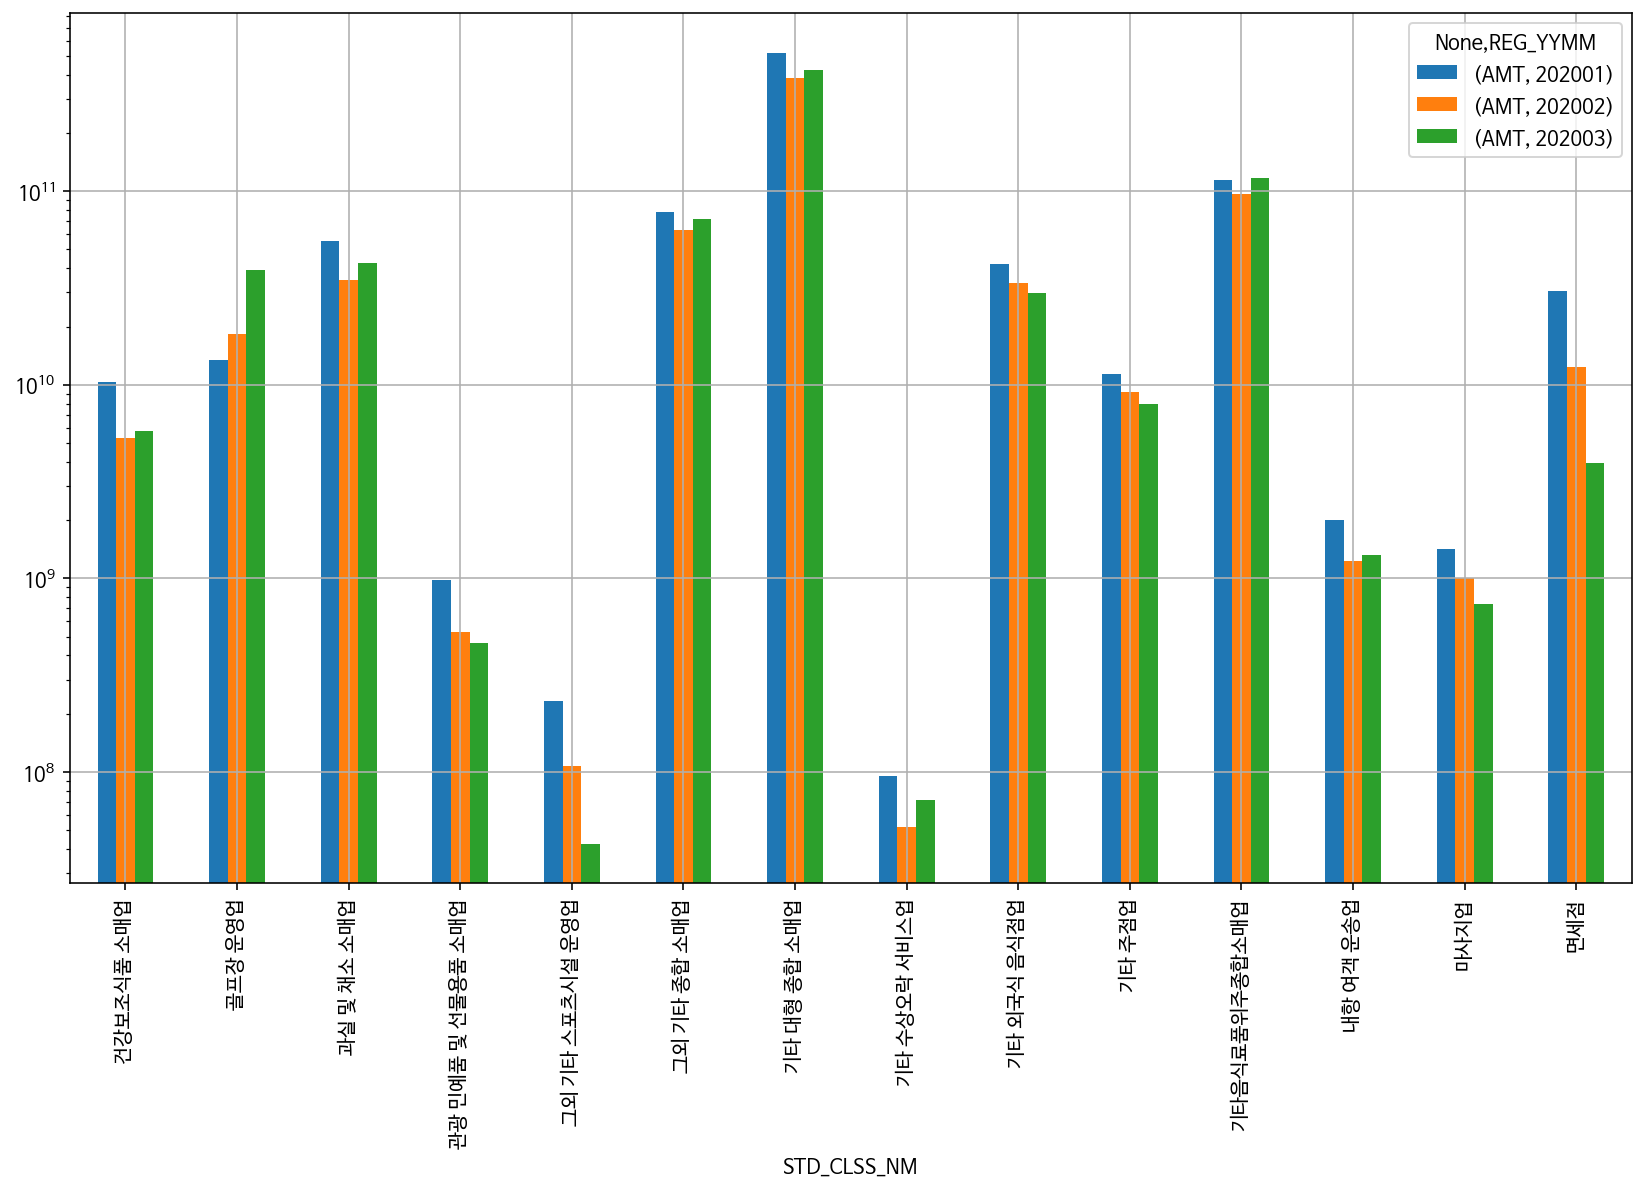

In [ ]:
# 업종, 날짜로 묶어 AMT의 총 합 그래프 확인(로그 스케일 적용)
temp02_std01.groupby(['STD_CLSS_NM', 'REG_YYMM']).sum().unstack().plot.bar()
plt.yscale('log') # y 축 변수를 로그 스케일로 변환

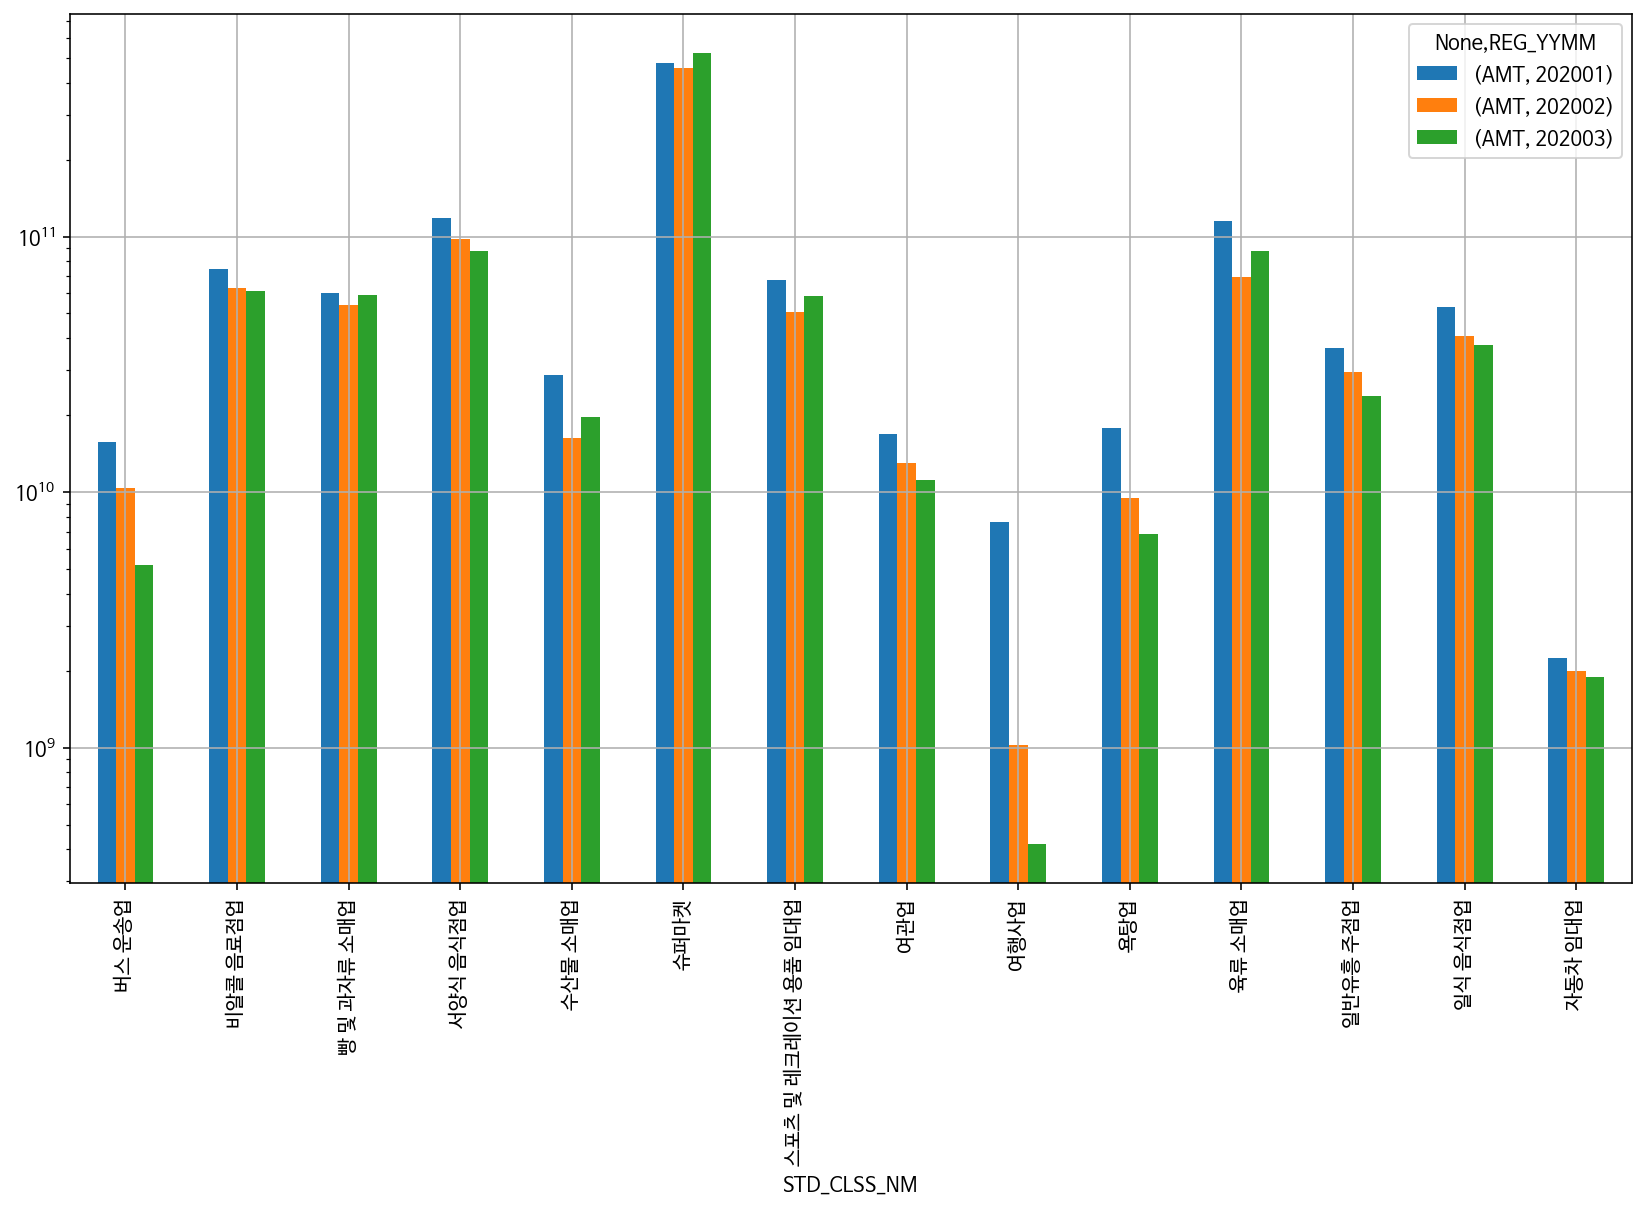

In [ ]:
temp02_std02.groupby(['STD_CLSS_NM', 'REG_YYMM']).sum().unstack().plot.bar()
plt.yscale('log')

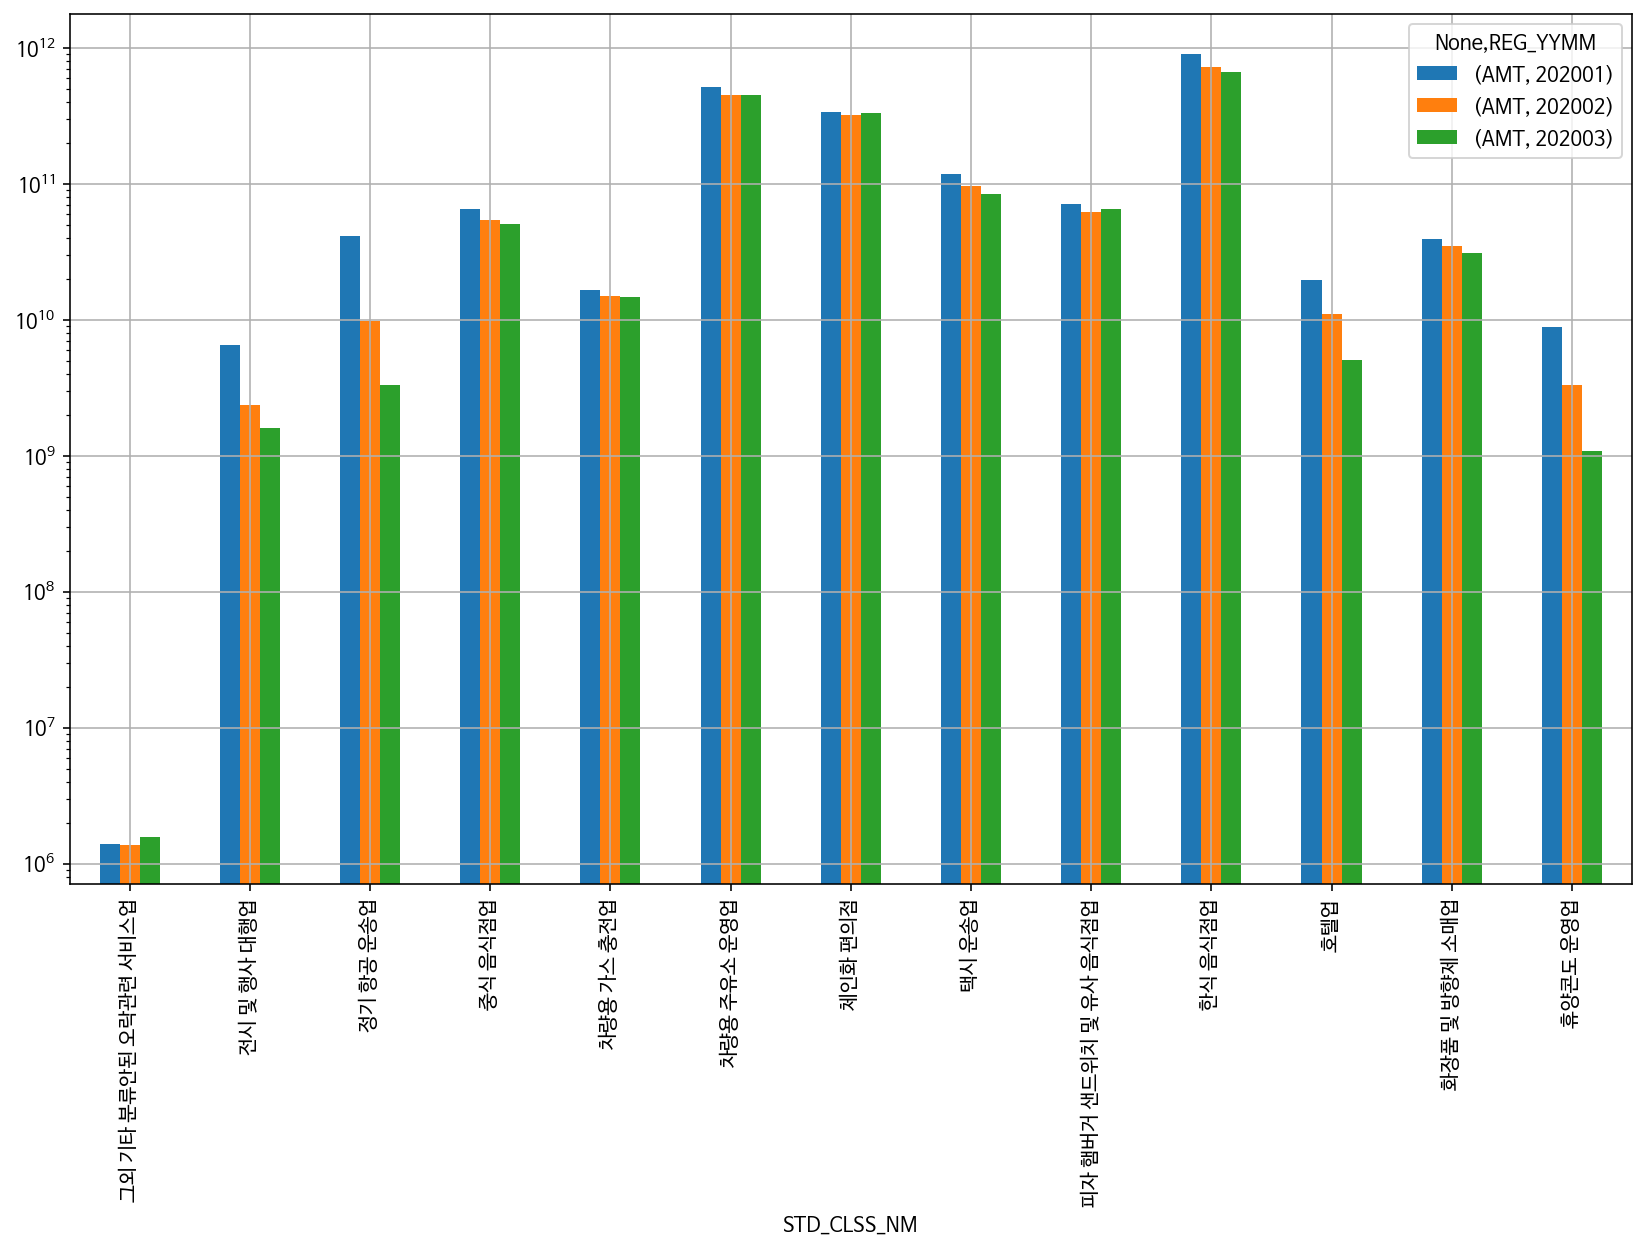

In [ ]:
temp02_std03.groupby(['STD_CLSS_NM', 'REG_YYMM']).sum().unstack().plot.bar()
plt.yscale('log')

In [ ]:
# 2020년 1월 ~ 2020년 3월 데이터 추출
temp03 = df[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp03 = temp03[(temp03['REG_YYMM'] == '202001') | (temp03['REG_YYMM'] == '202002') | (temp03['REG_YYMM'] == '202003')].reset_index(drop = True)

In [ ]:
# 시도별 업종 AMT 변화를 보기 위해 시도 리스트 추출
sido_list = temp03['CARD_SIDO_NM'].unique().tolist()
sido_list

['강원',
 '경기',
 '경남',
 '경북',
 '광주',
 '대구',
 '대전',
 '부산',
 '서울',
 '세종',
 '울산',
 '인천',
 '전남',
 '전북',
 '제주',
 '충남',
 '충북']

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


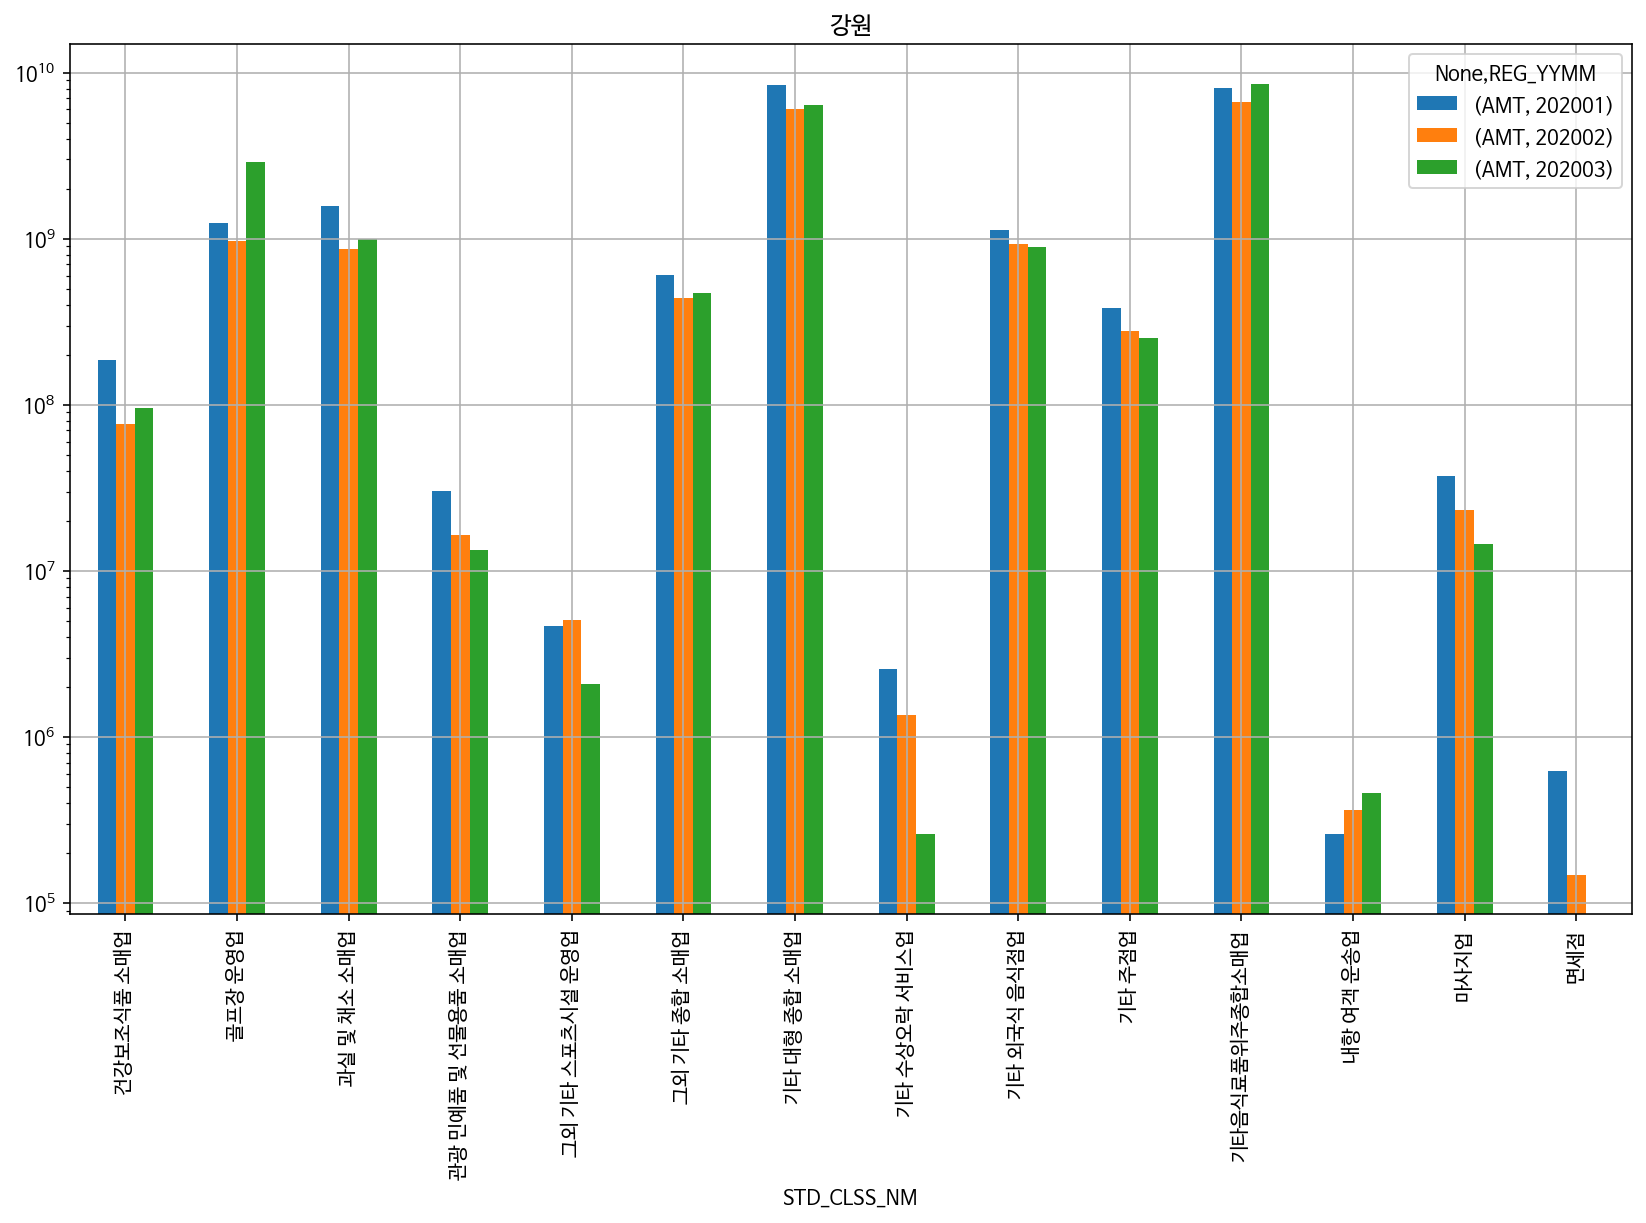

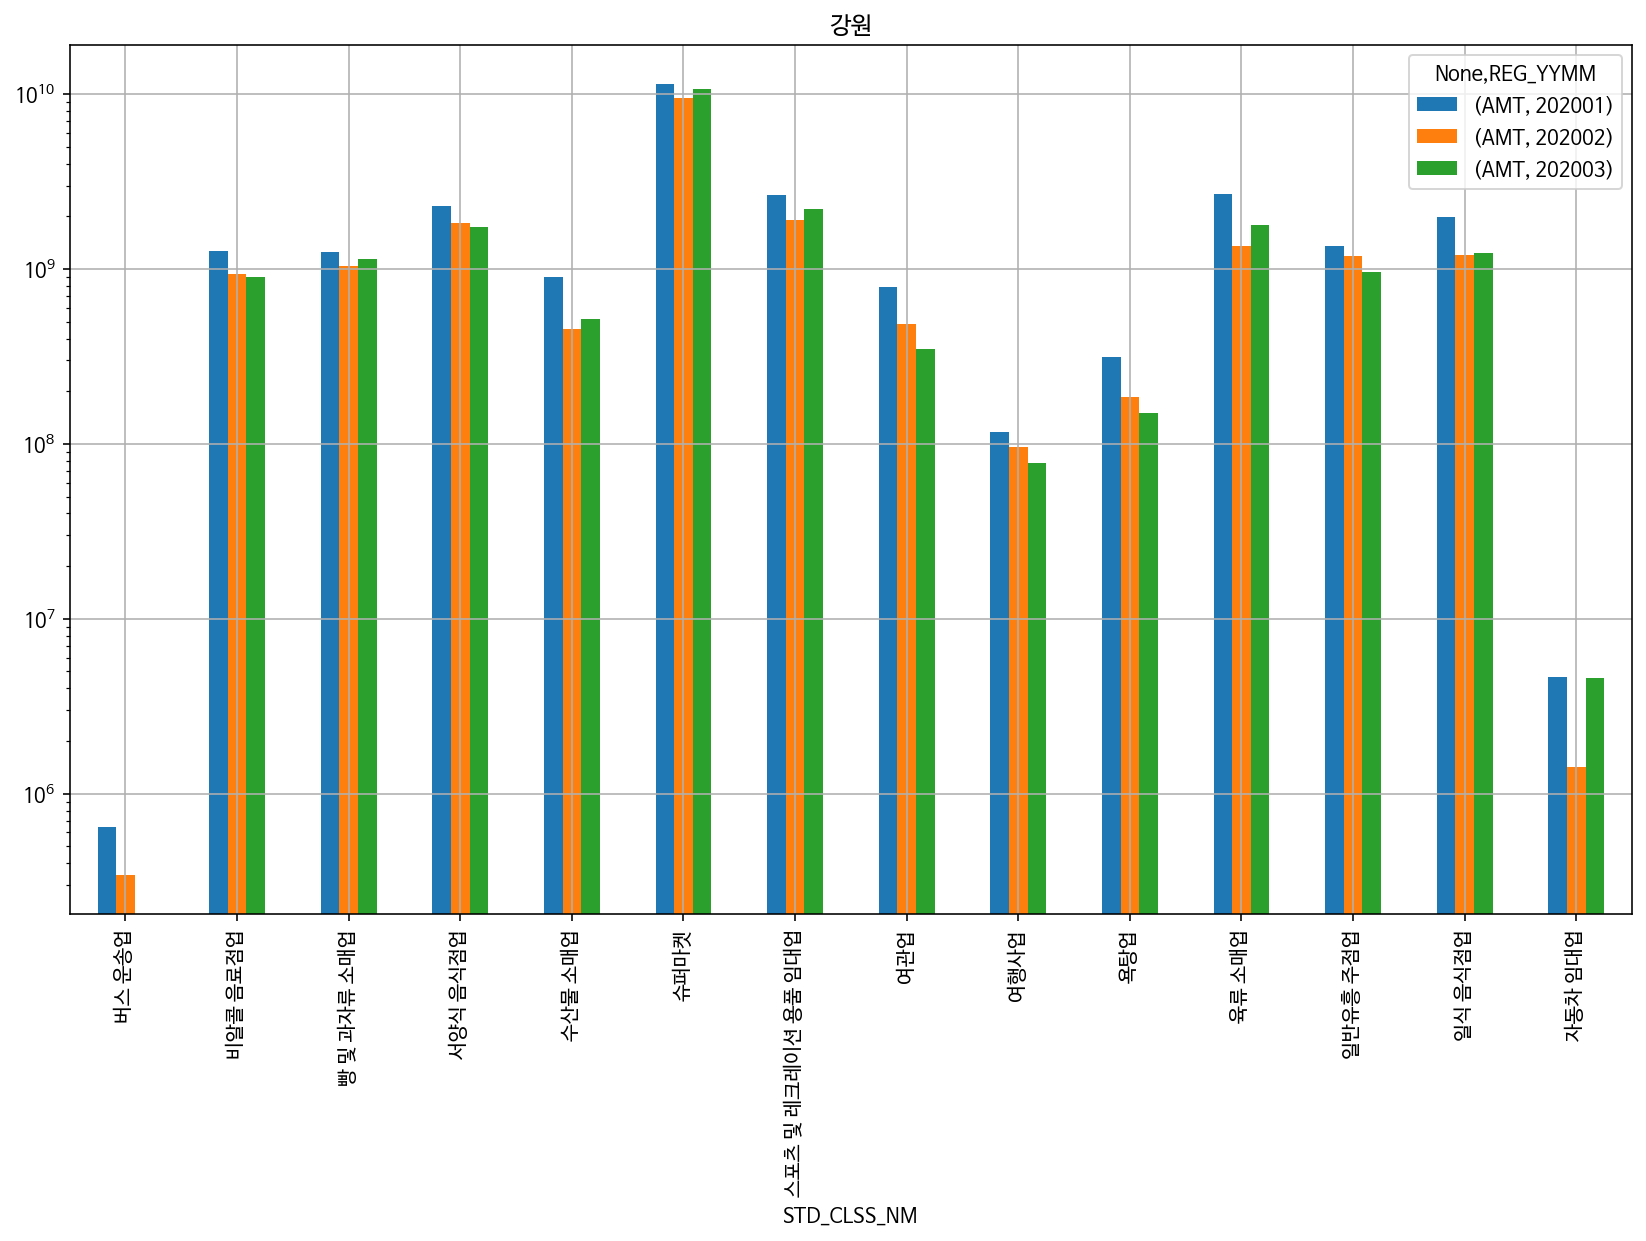

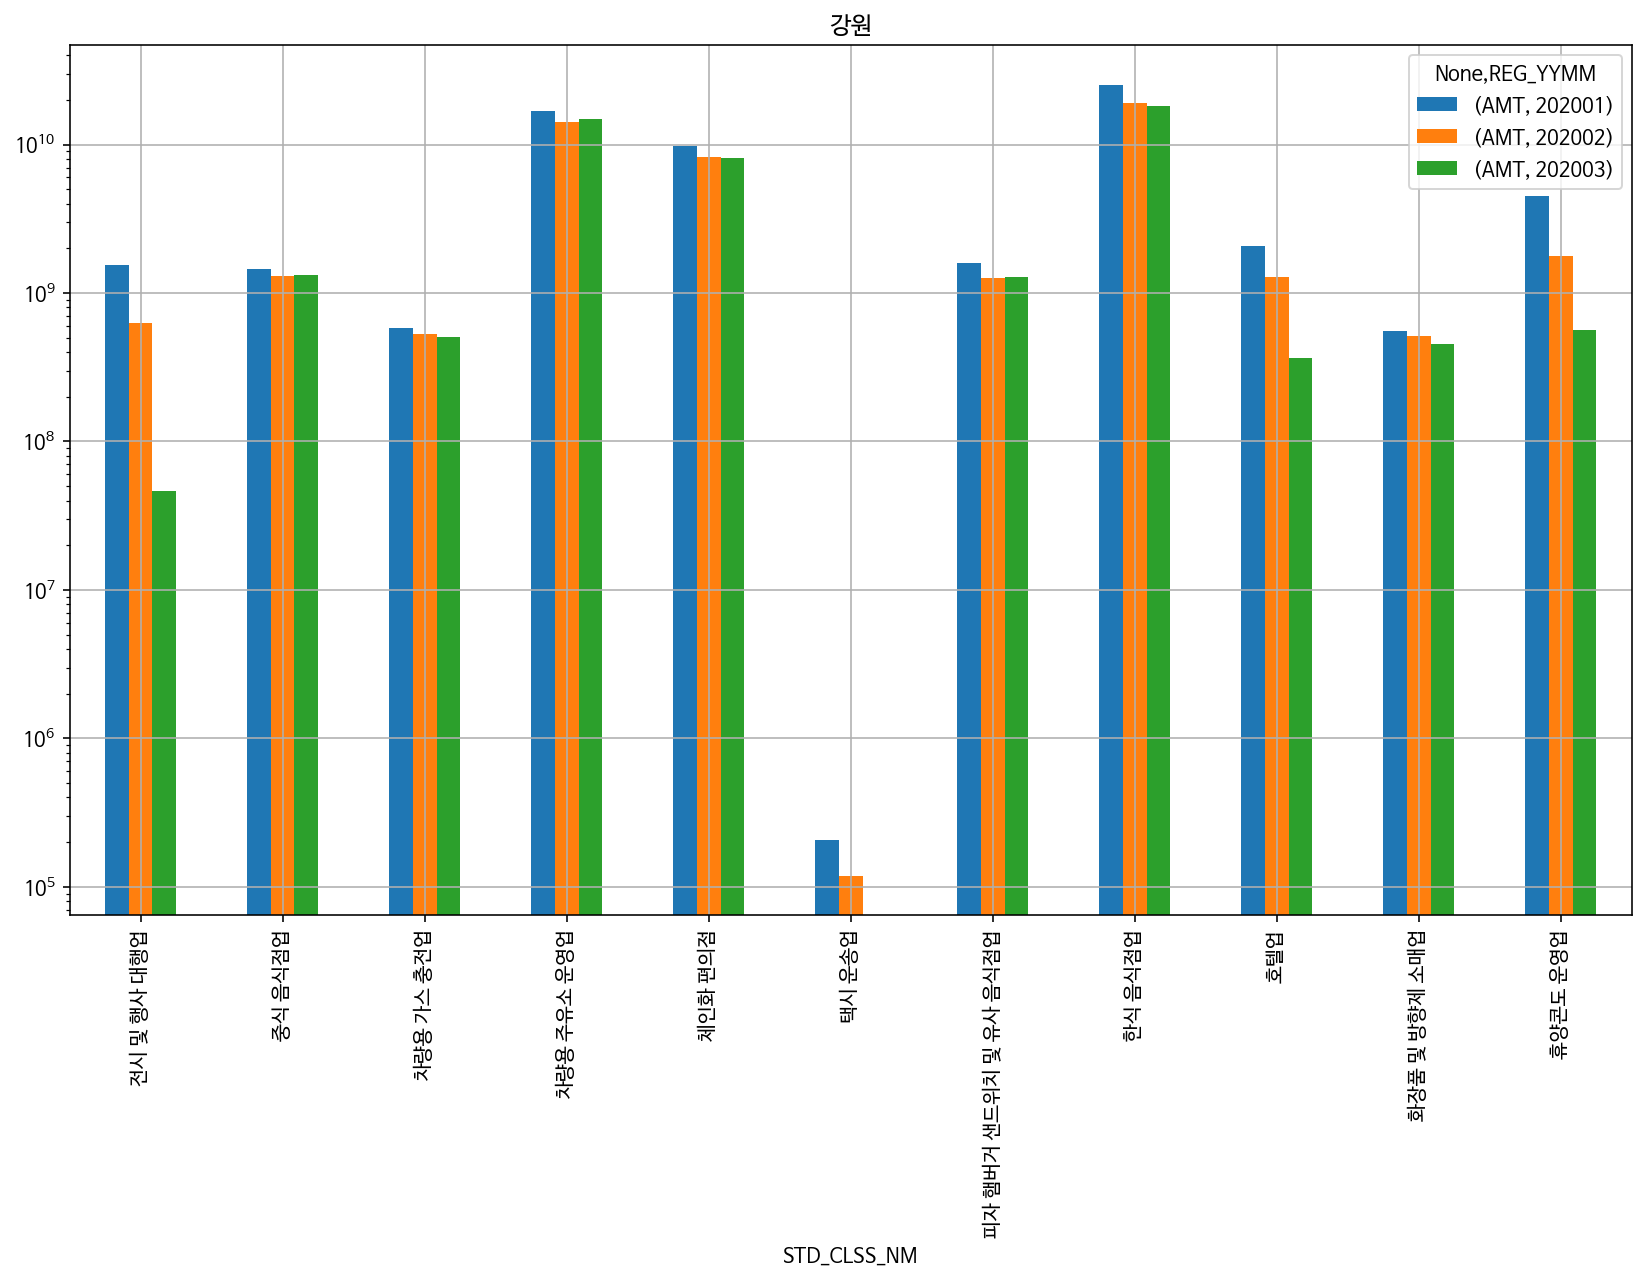

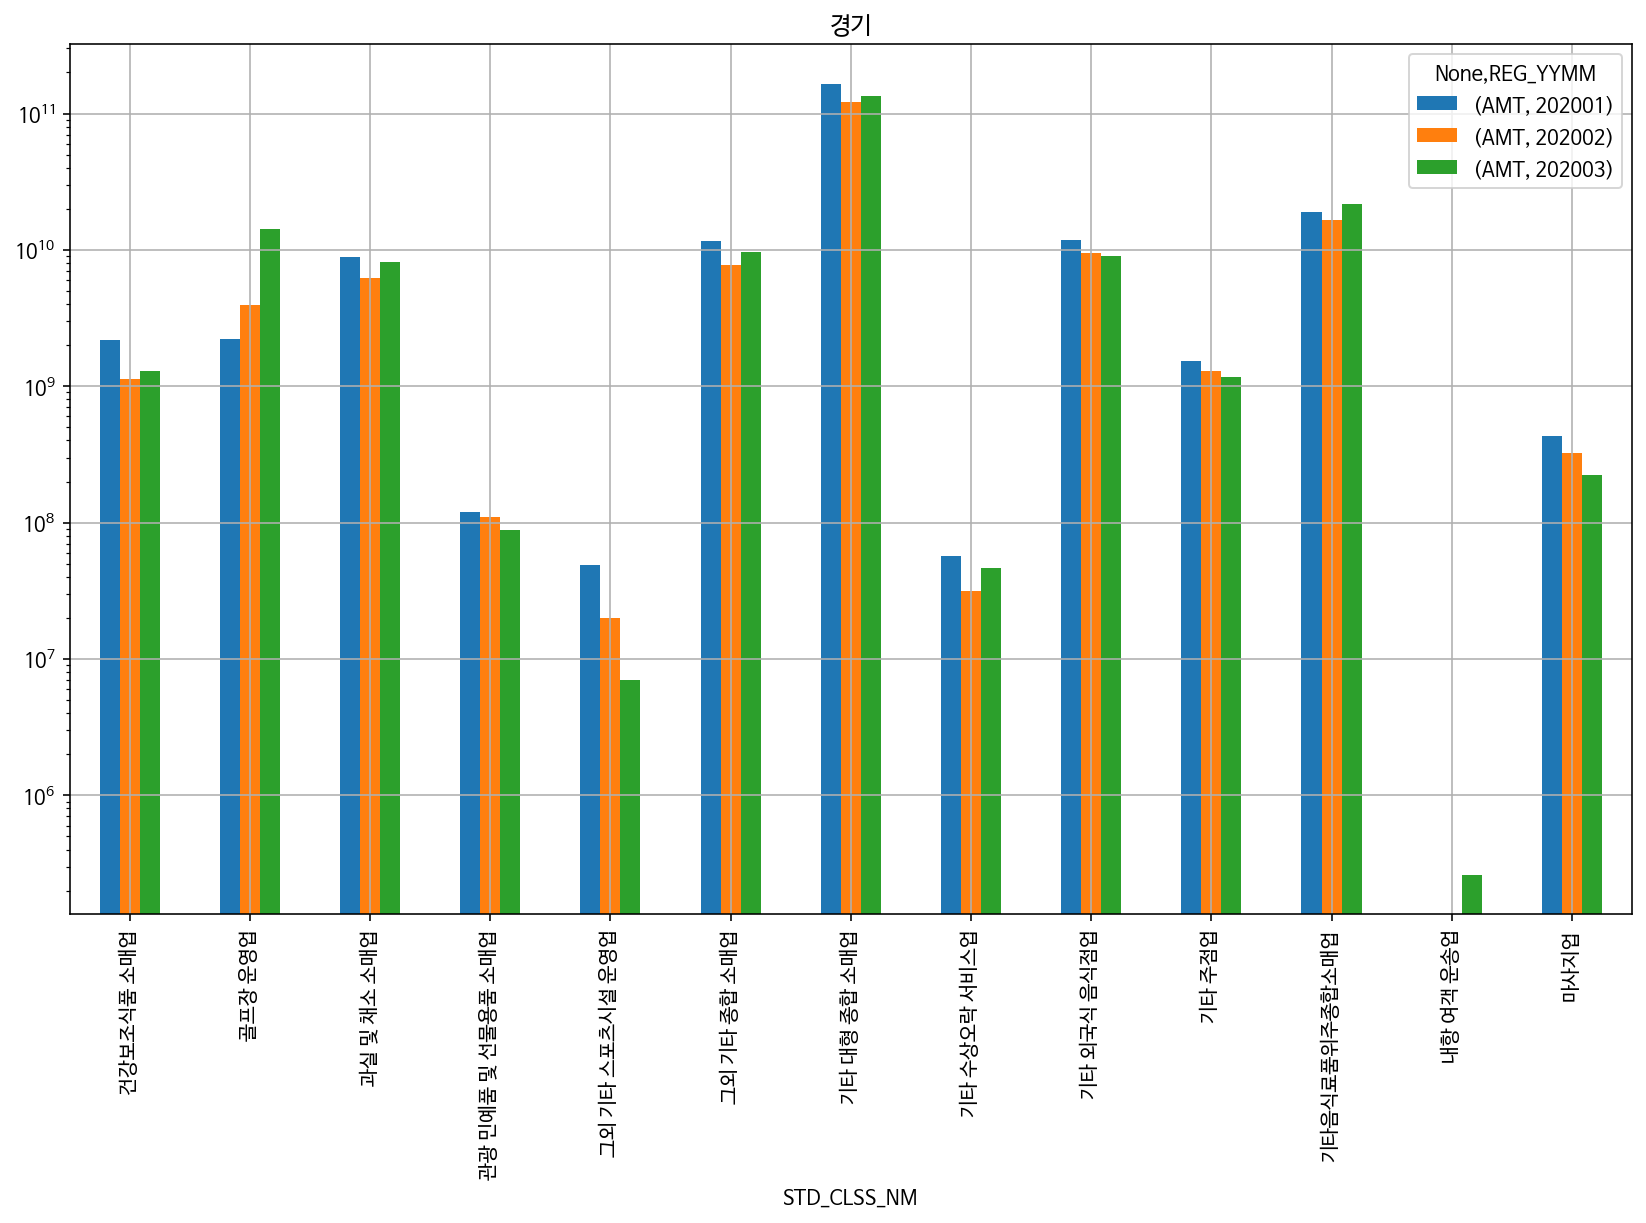

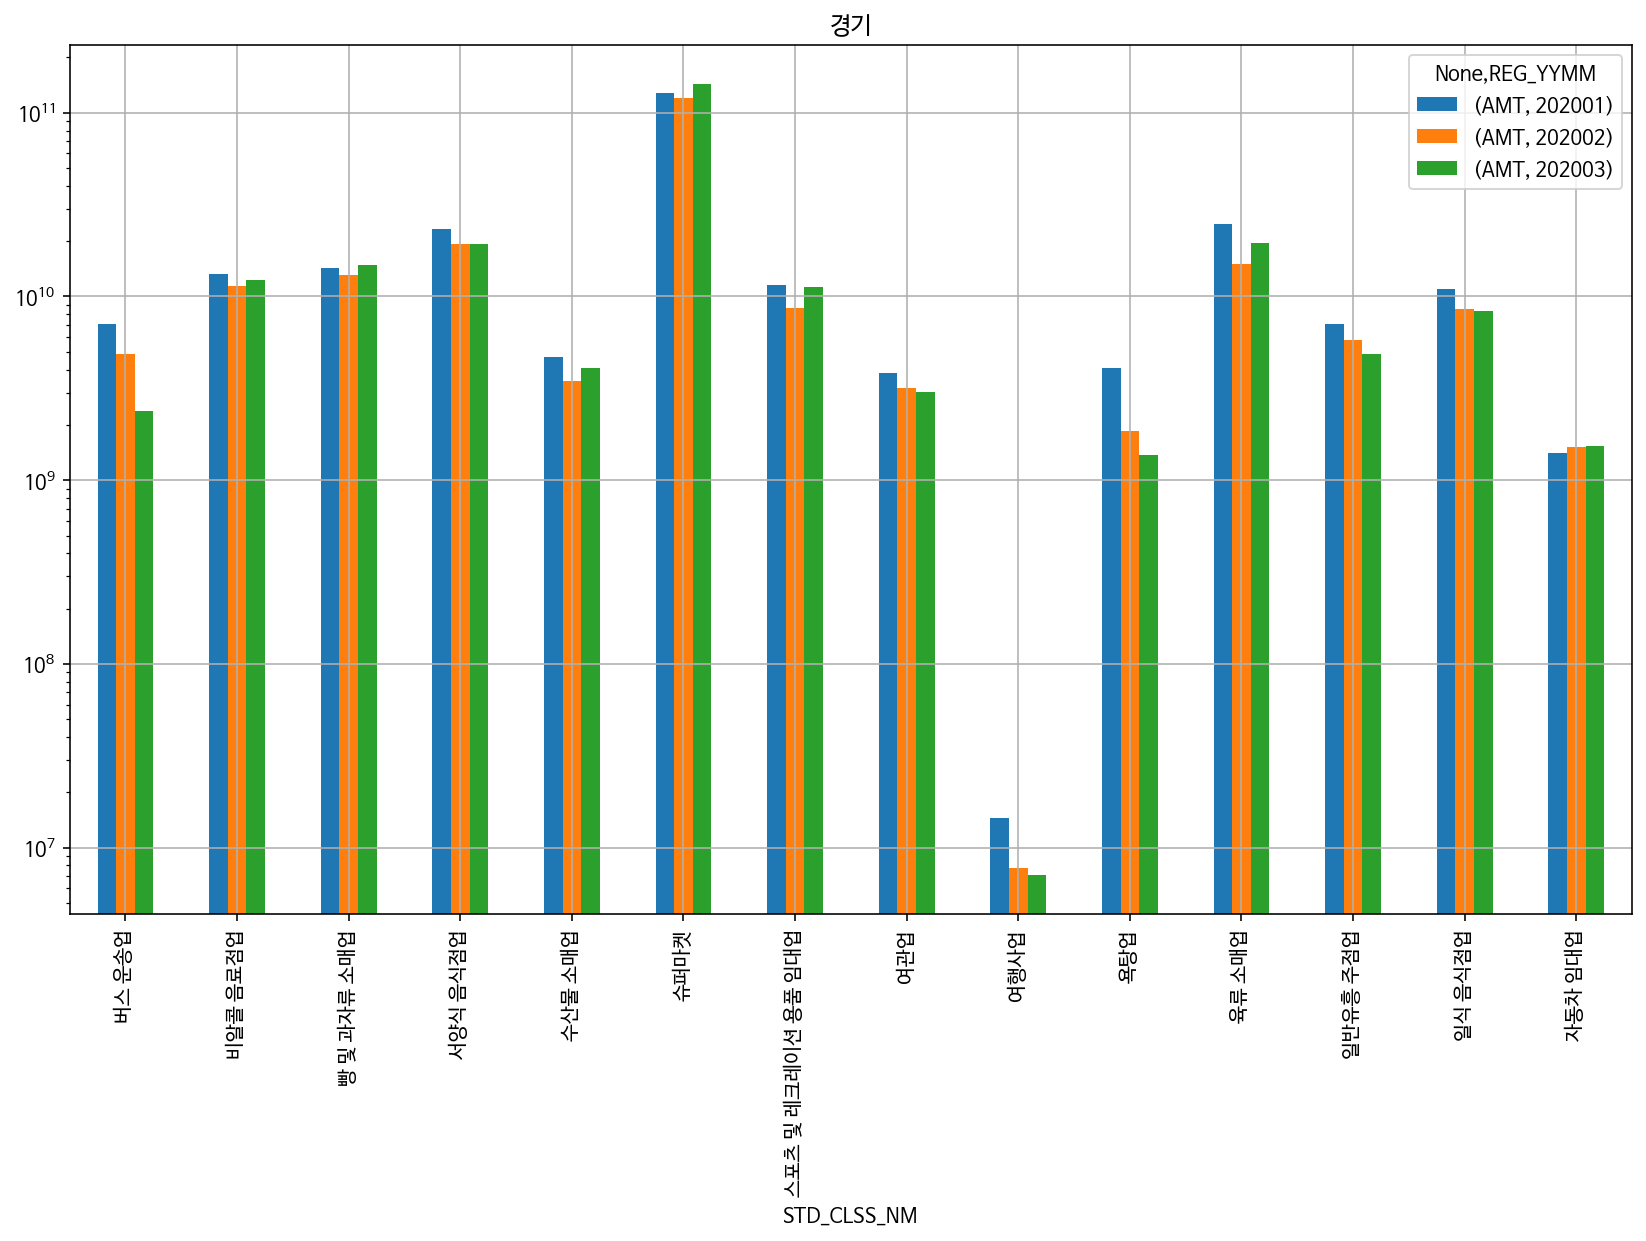

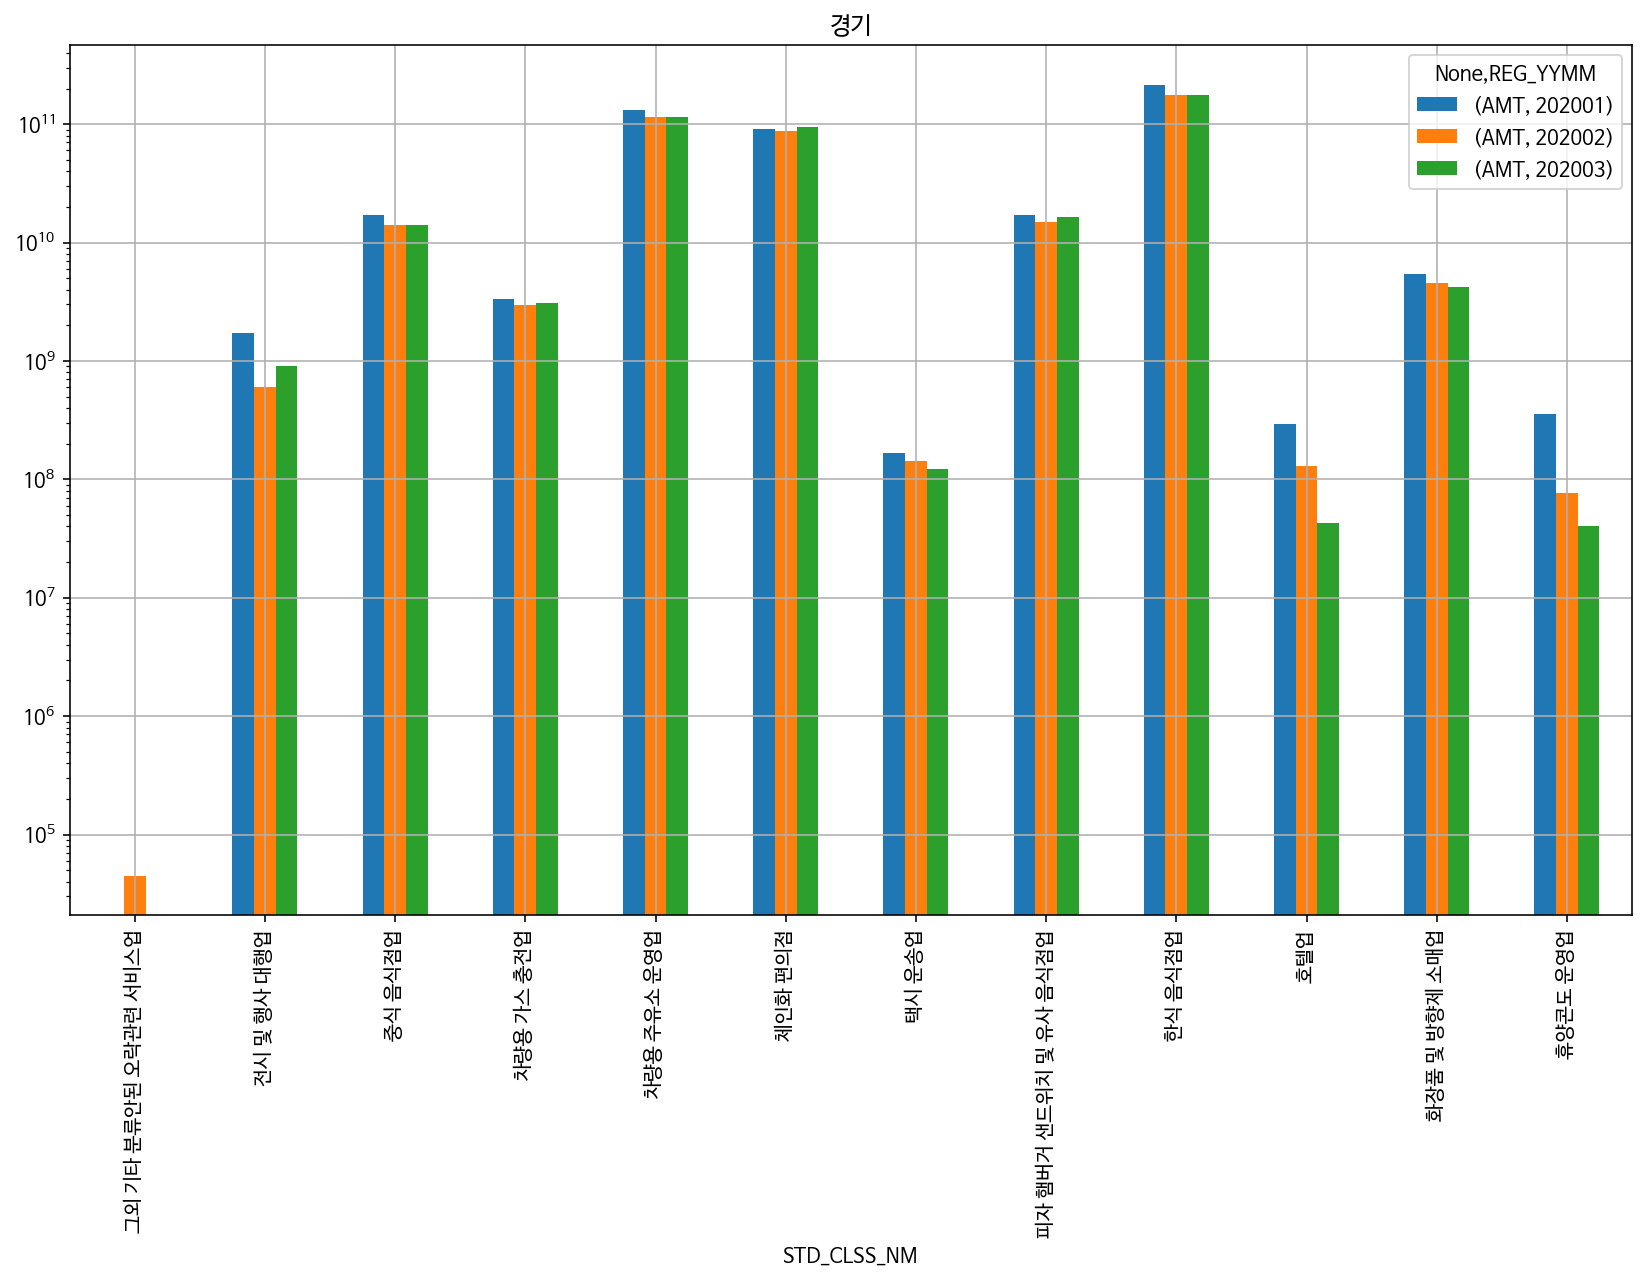

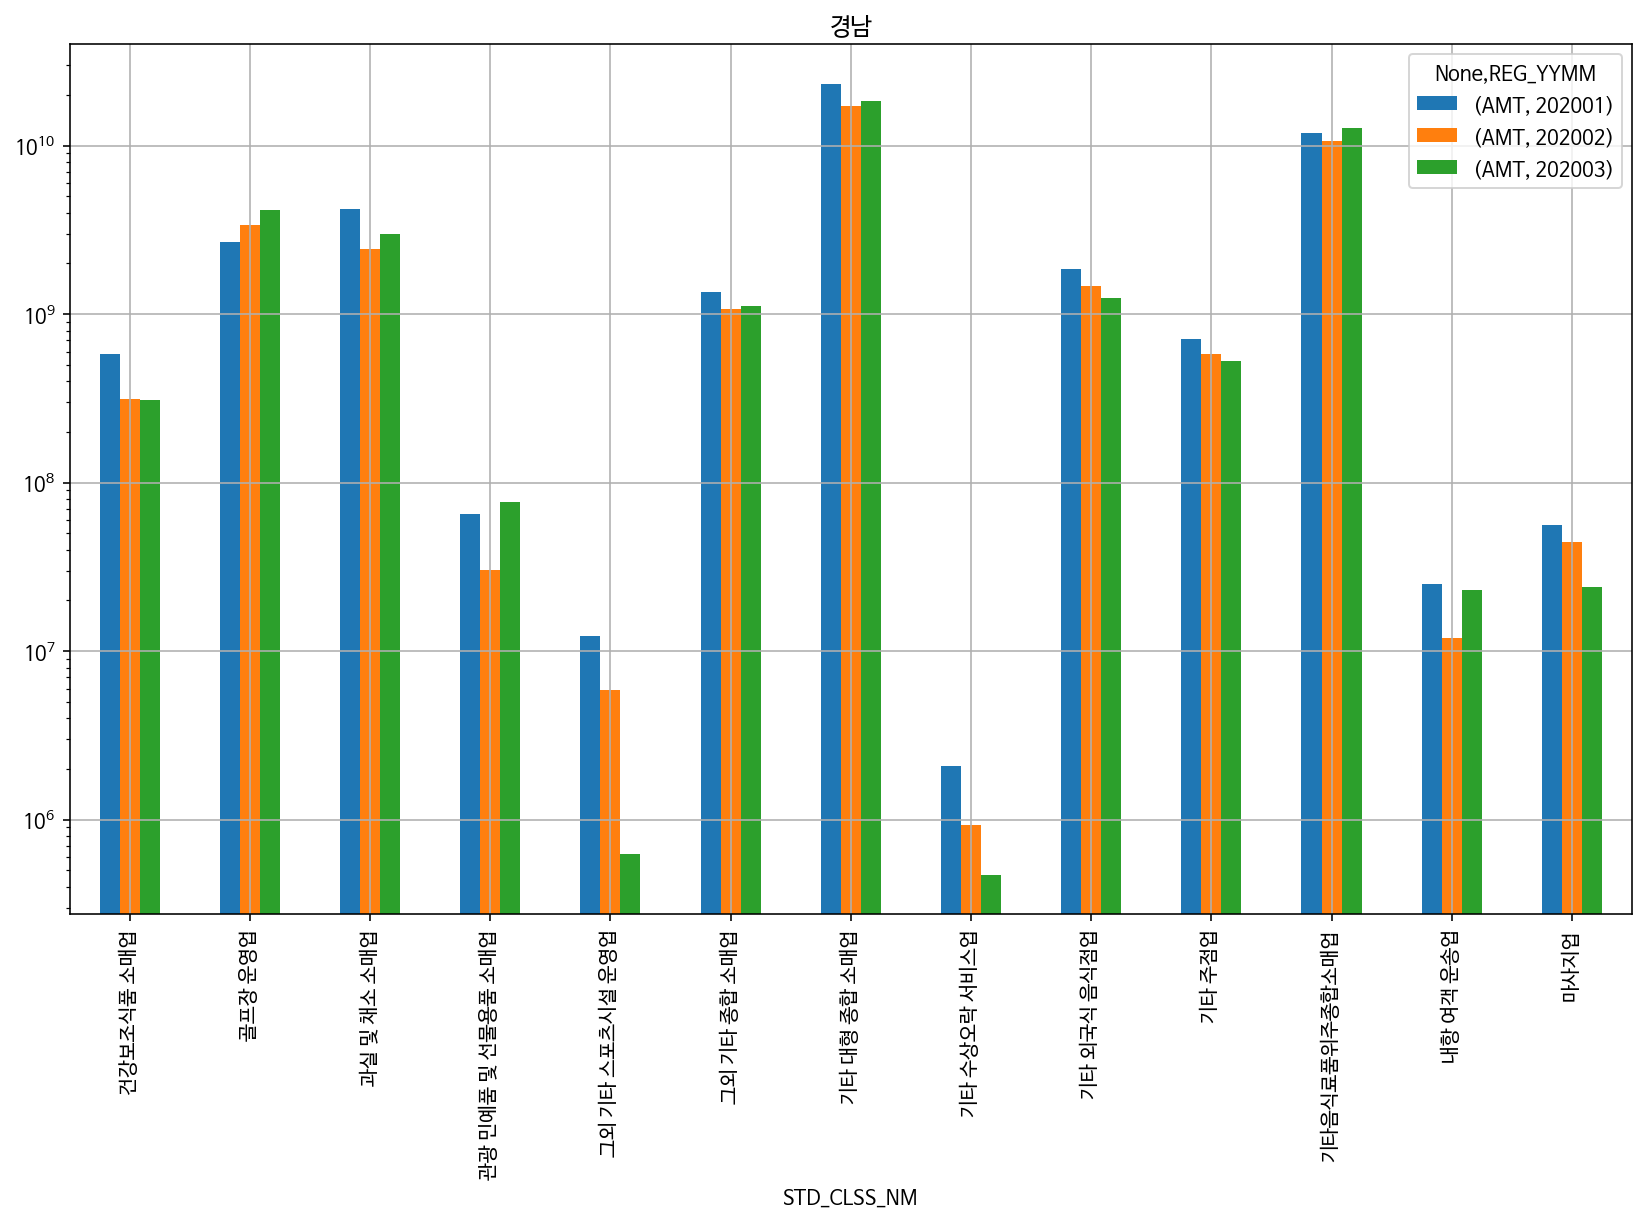

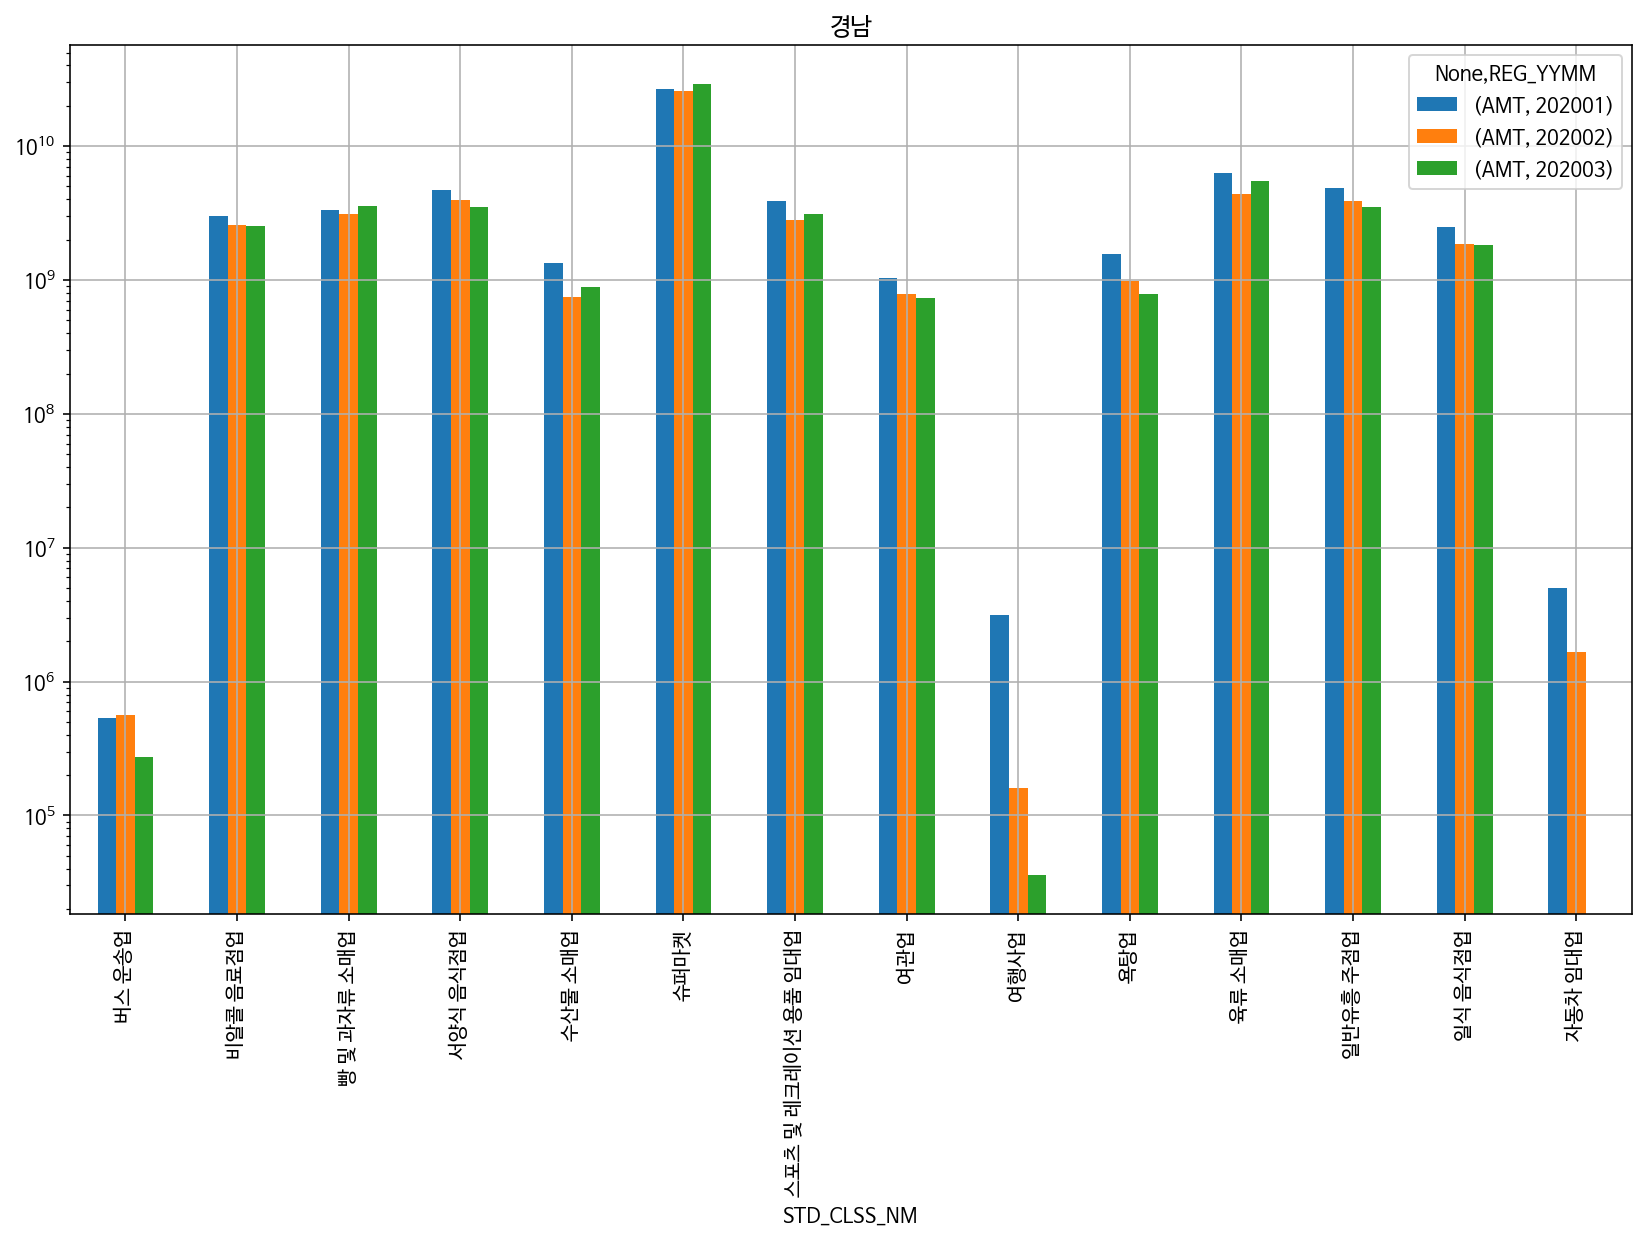

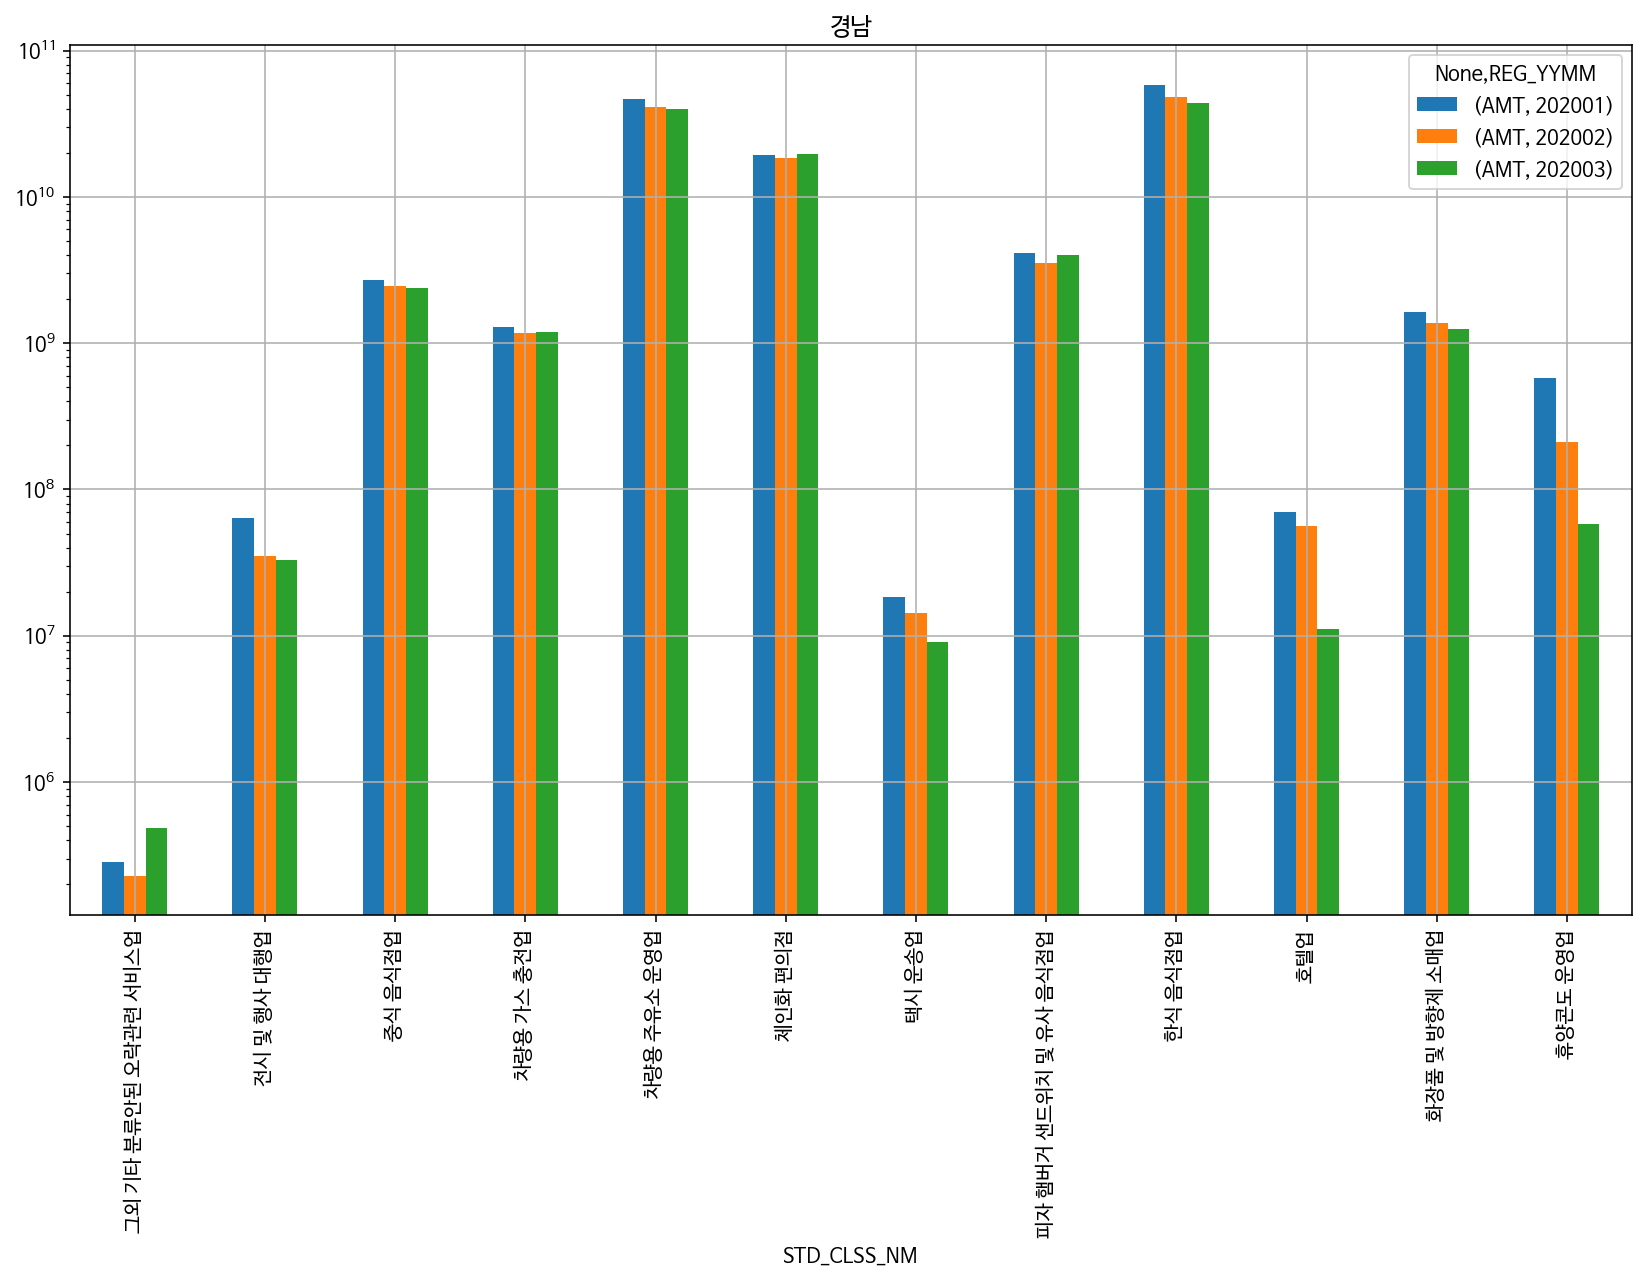

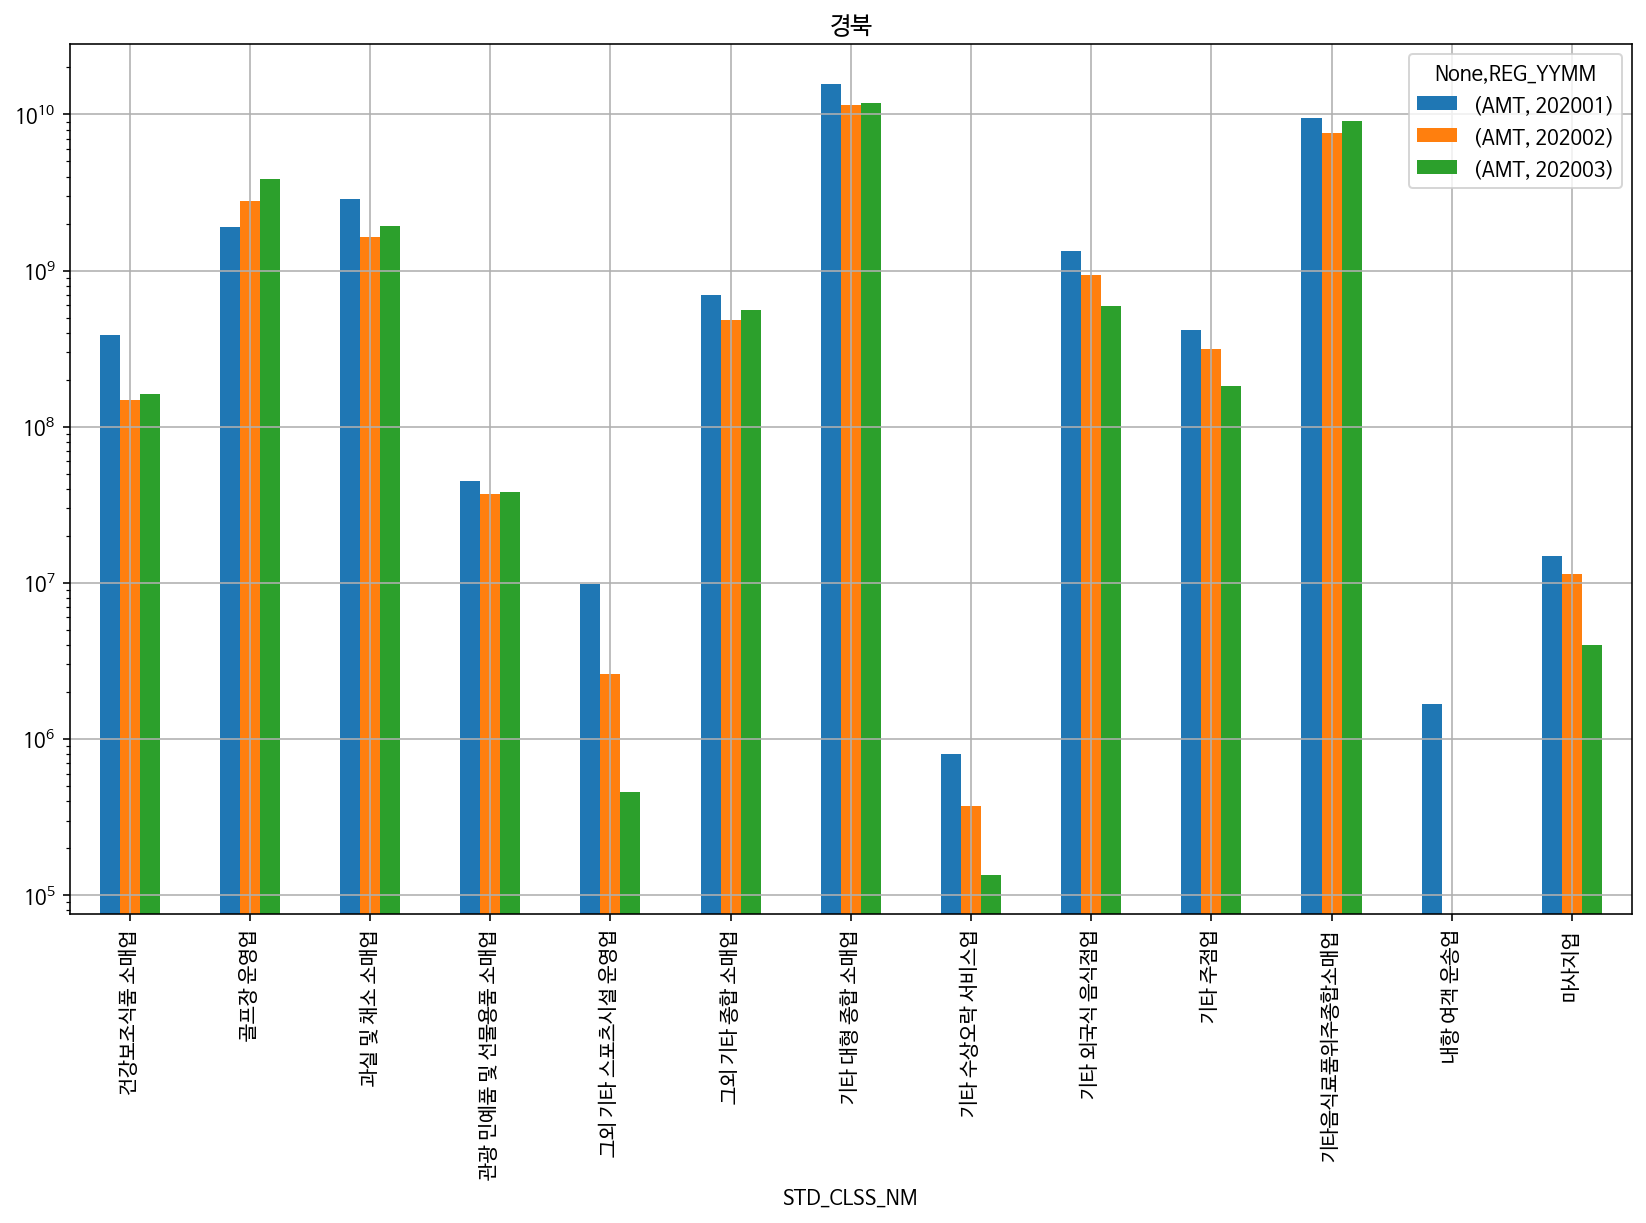

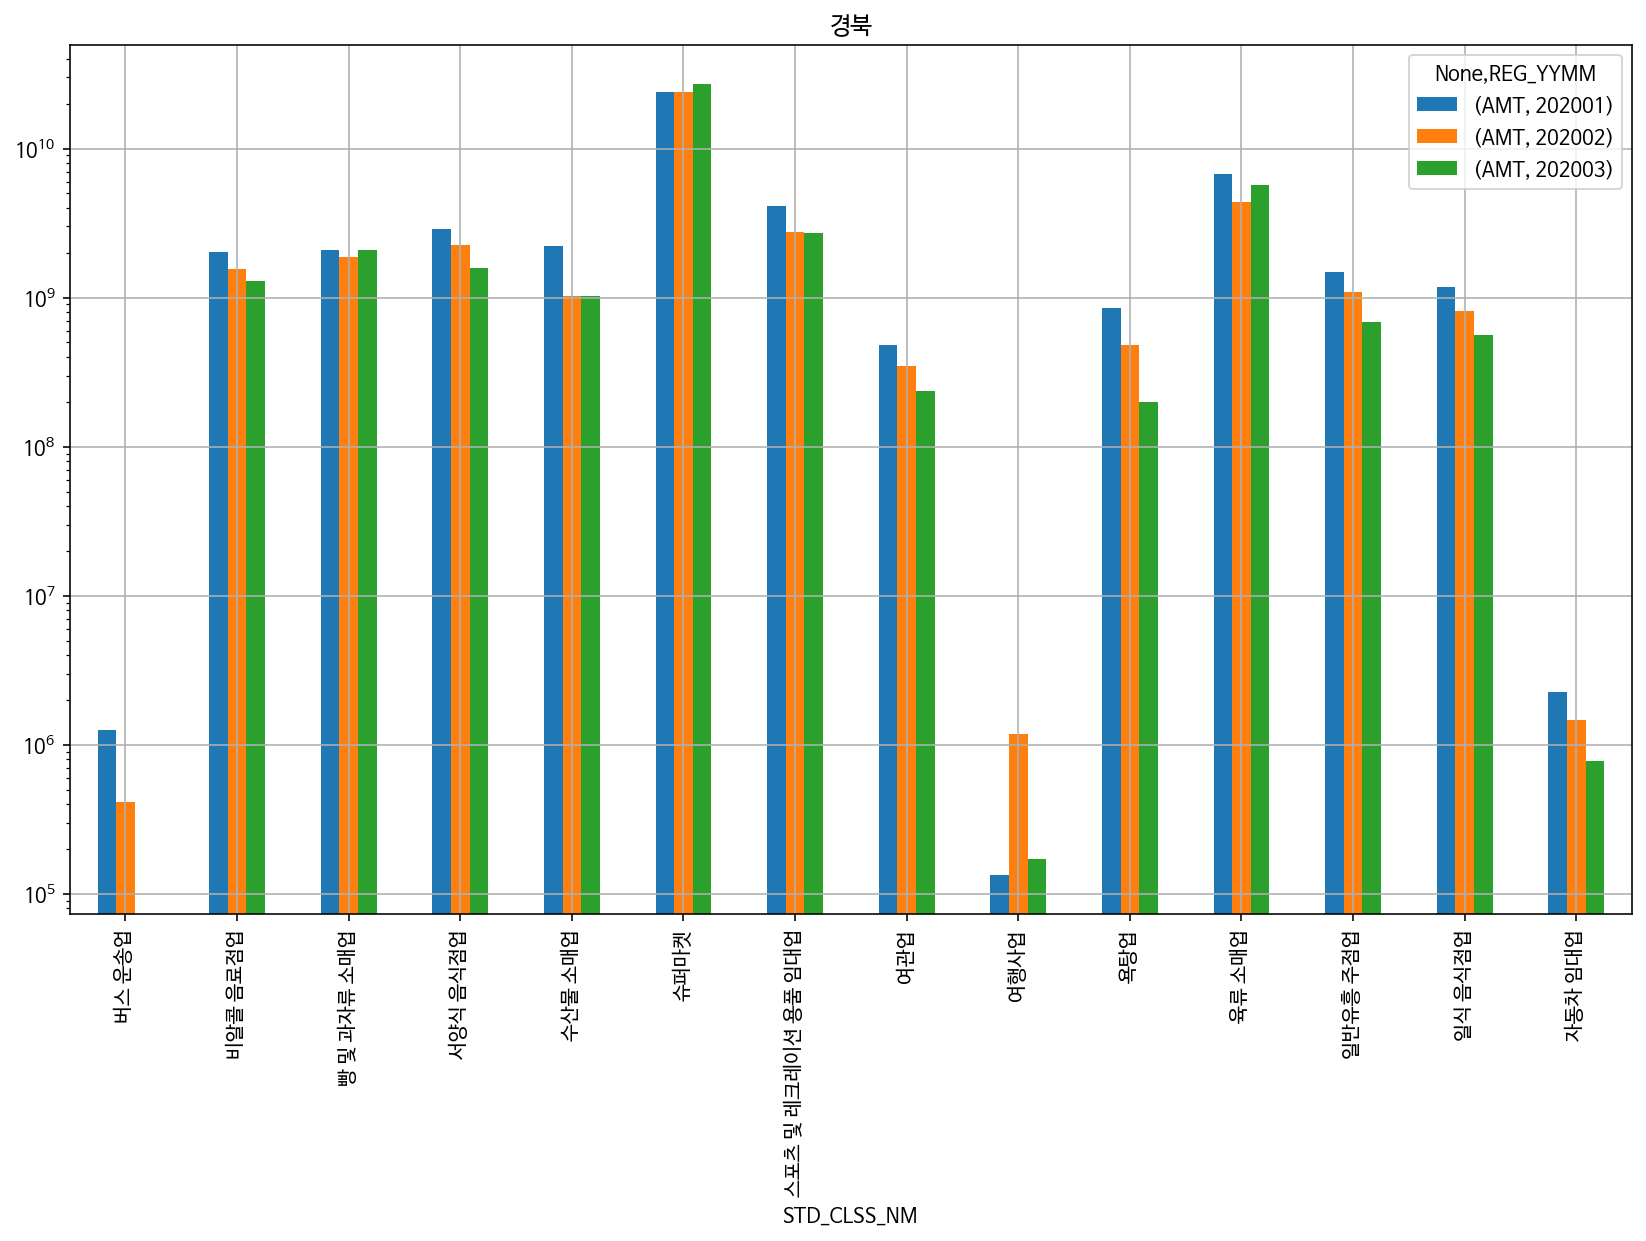

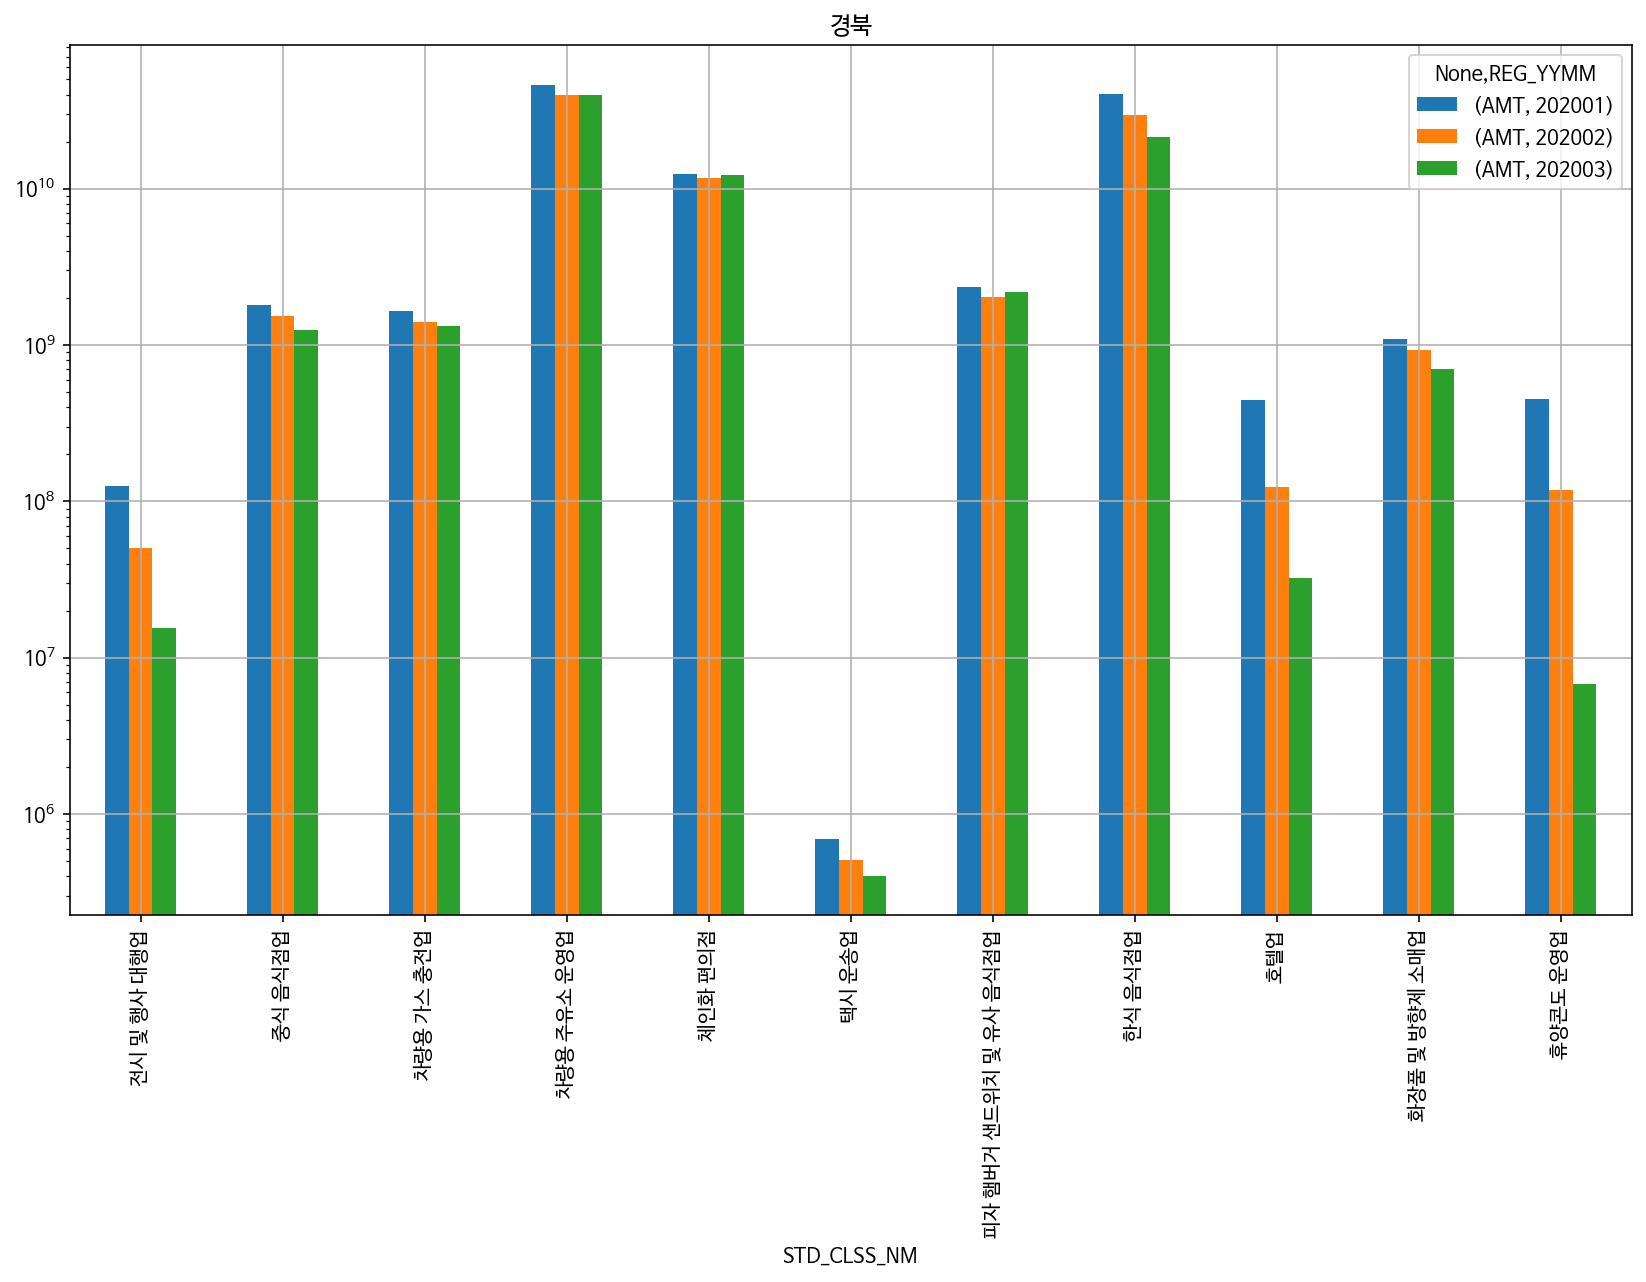

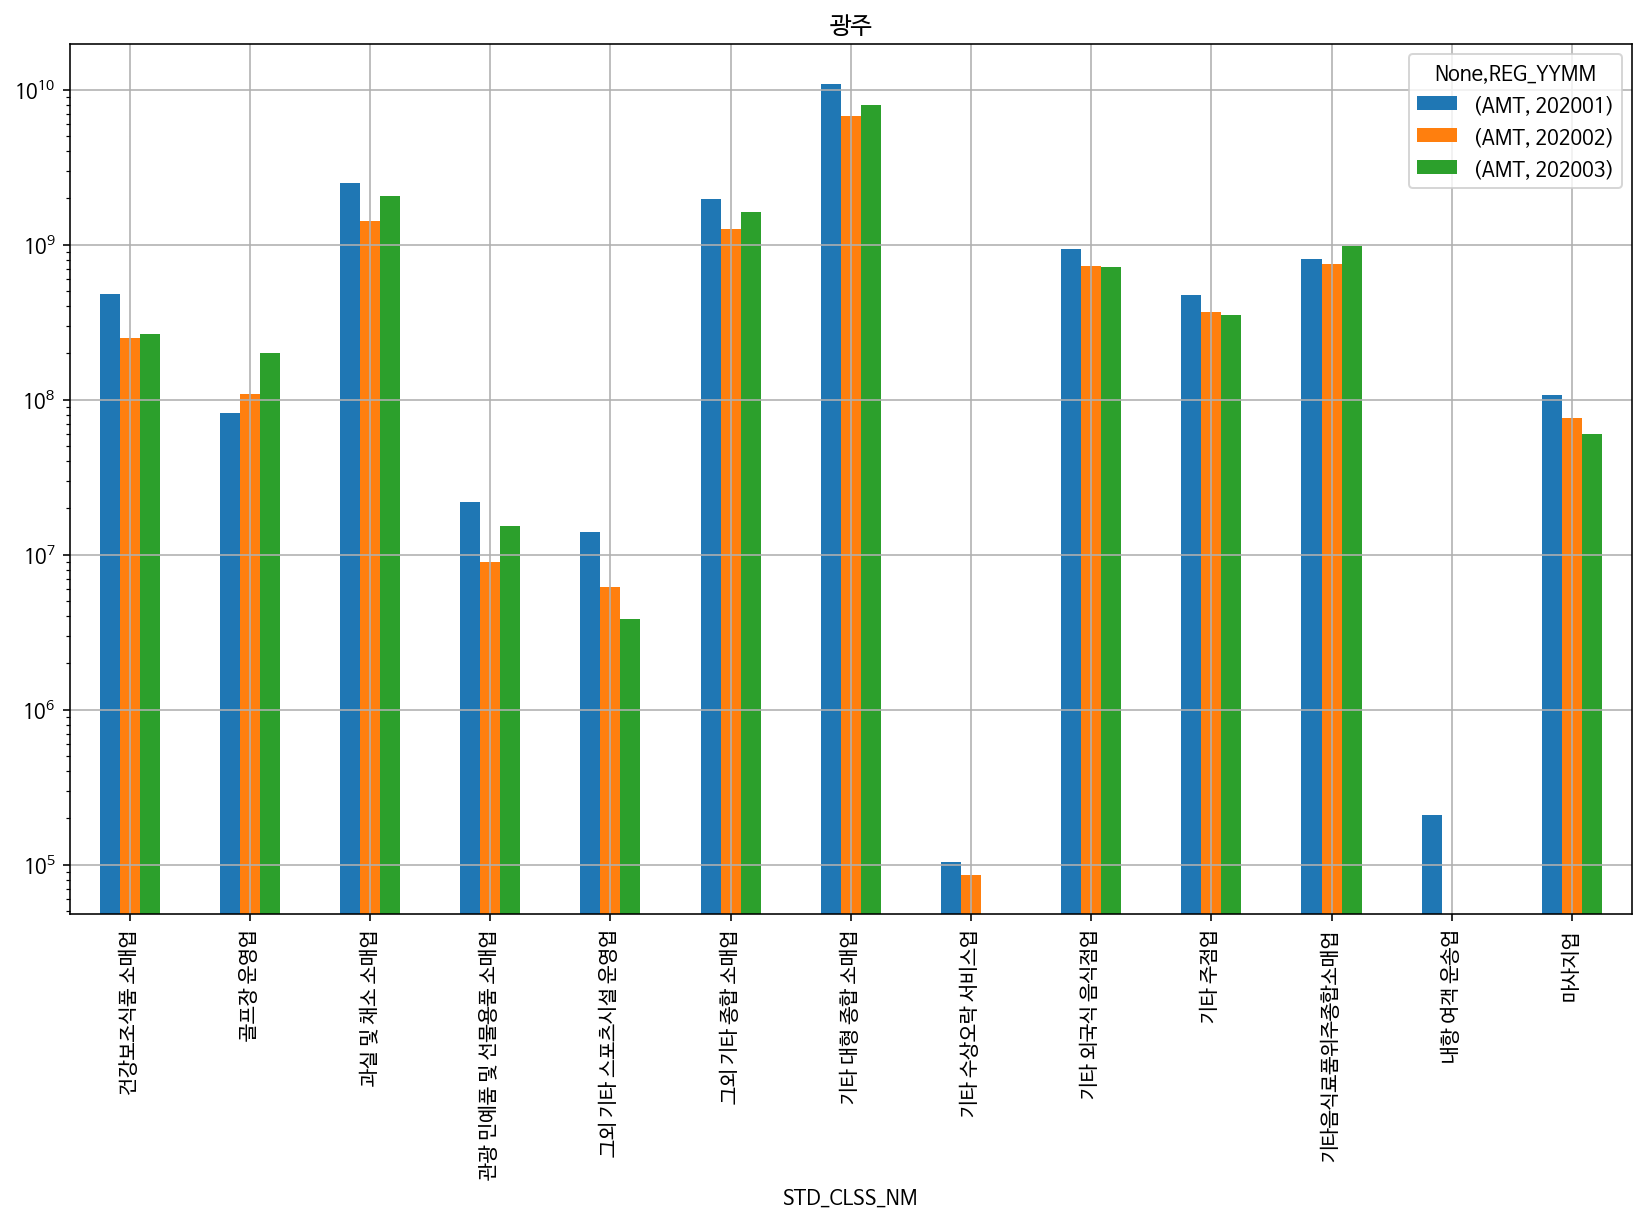

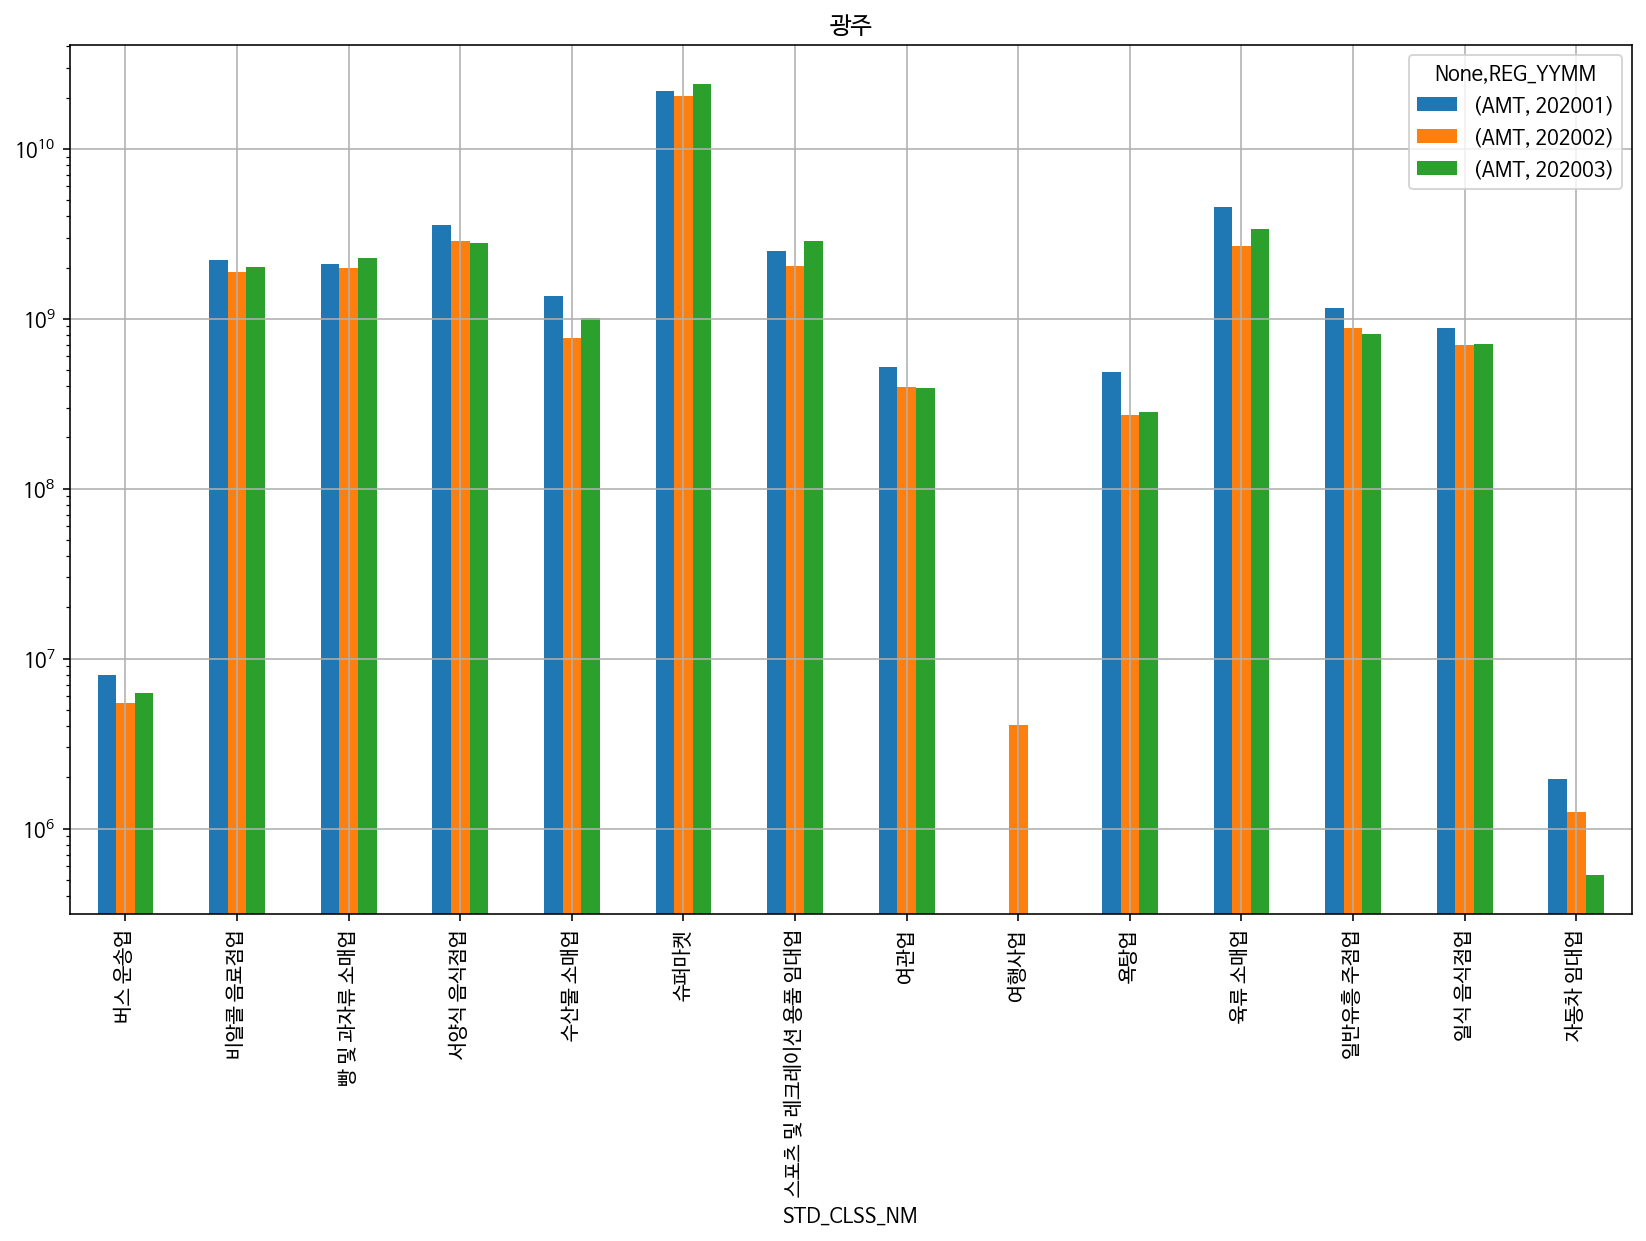

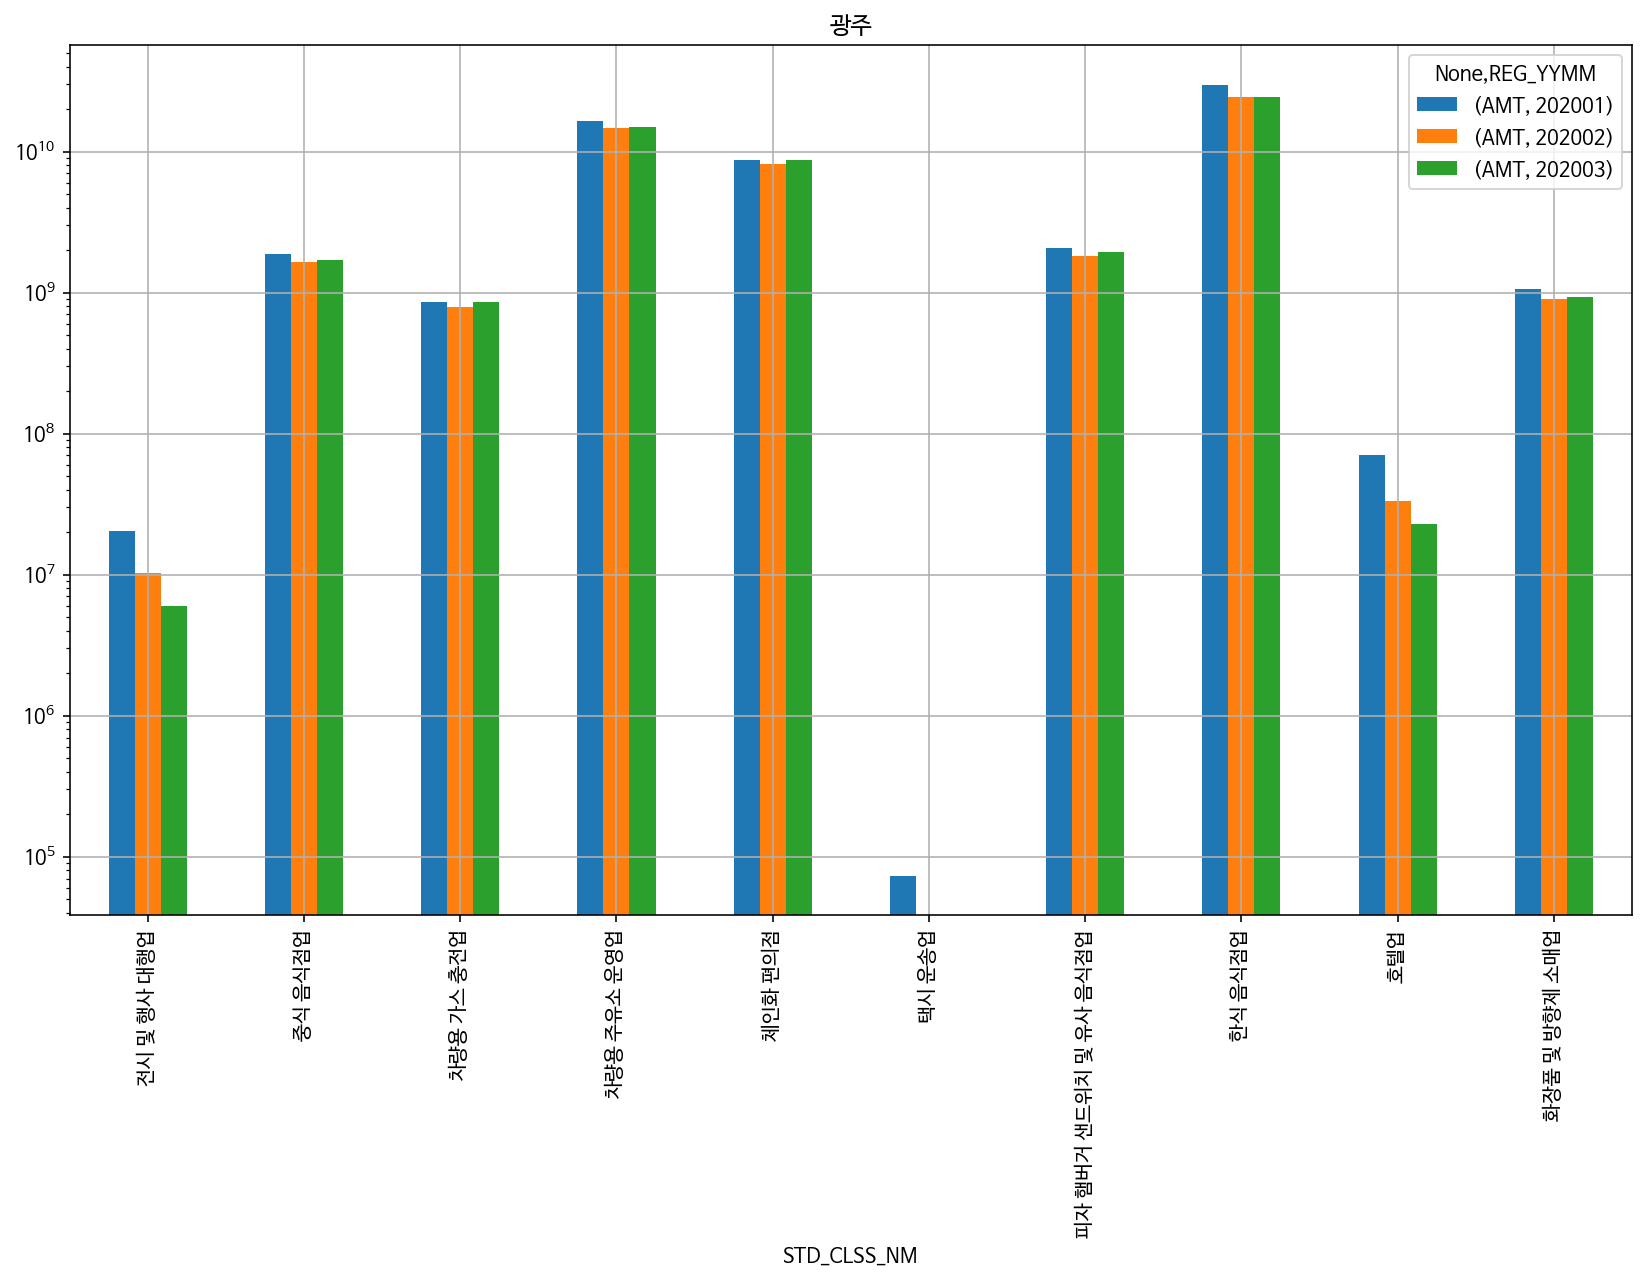

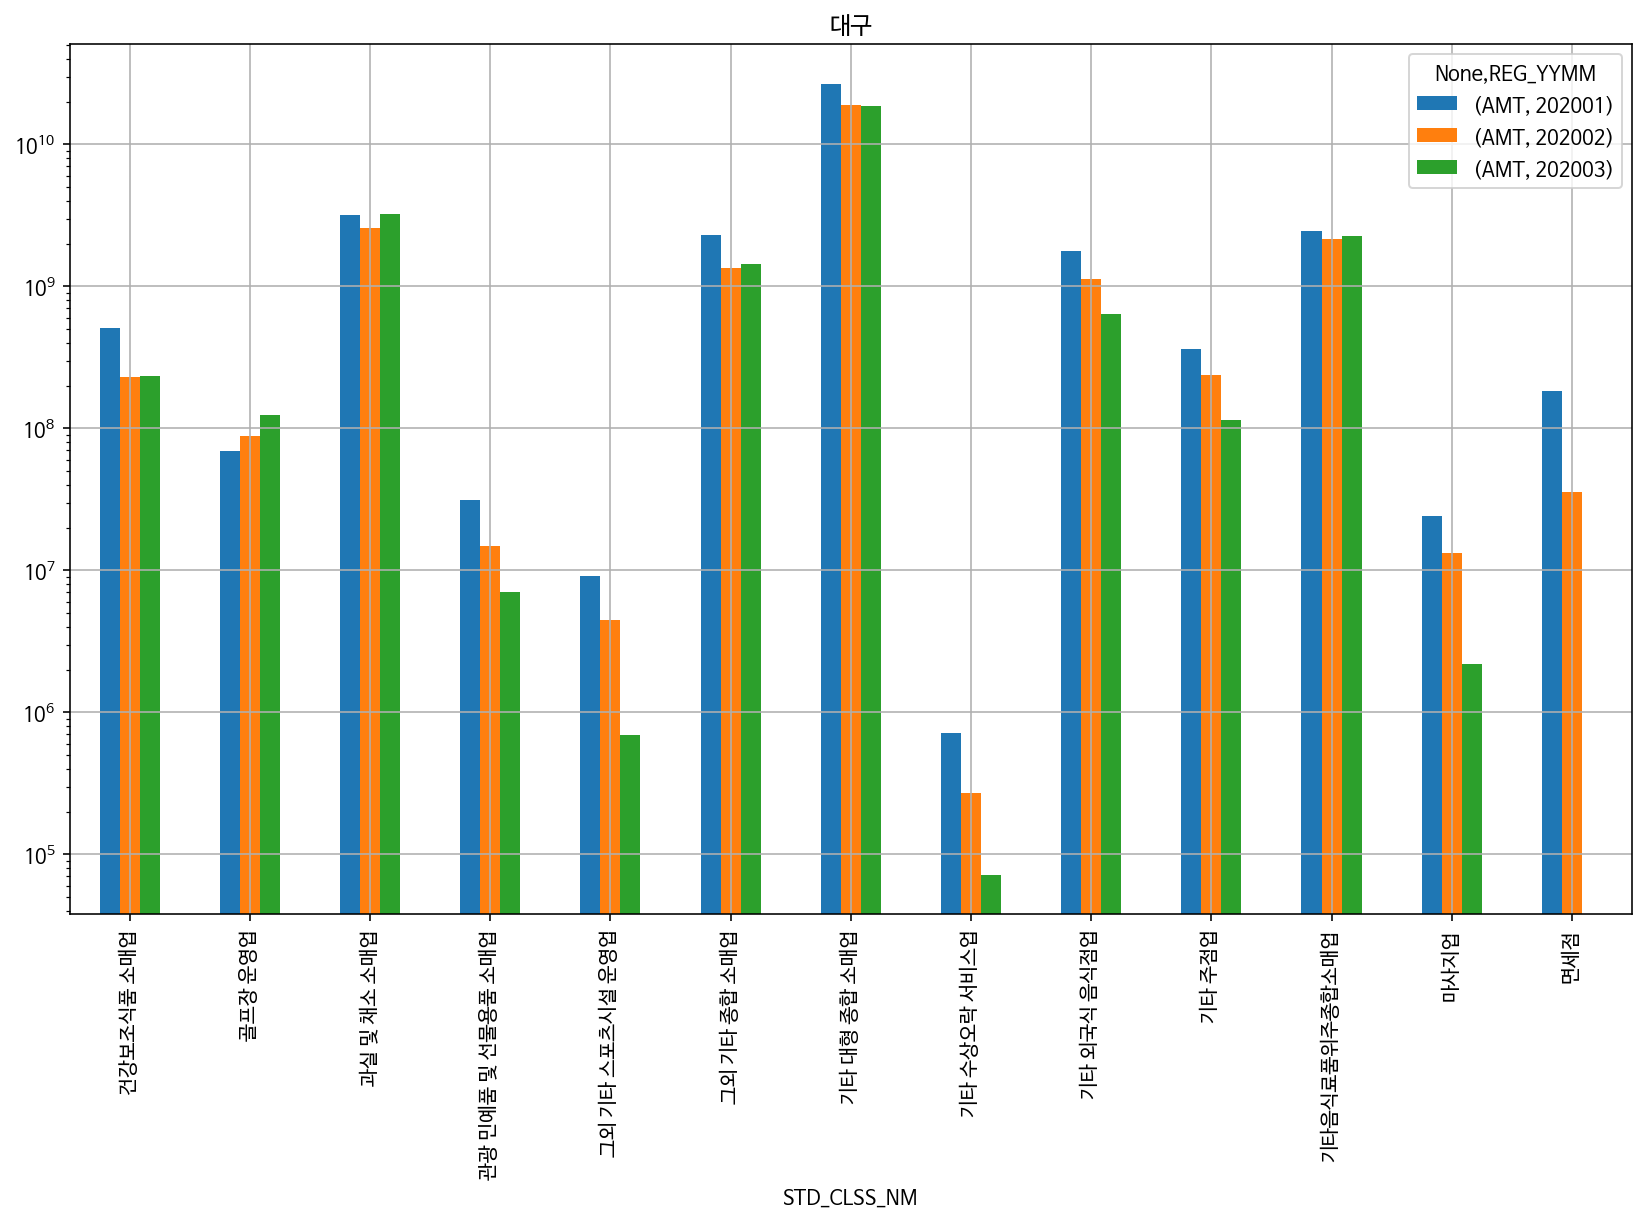

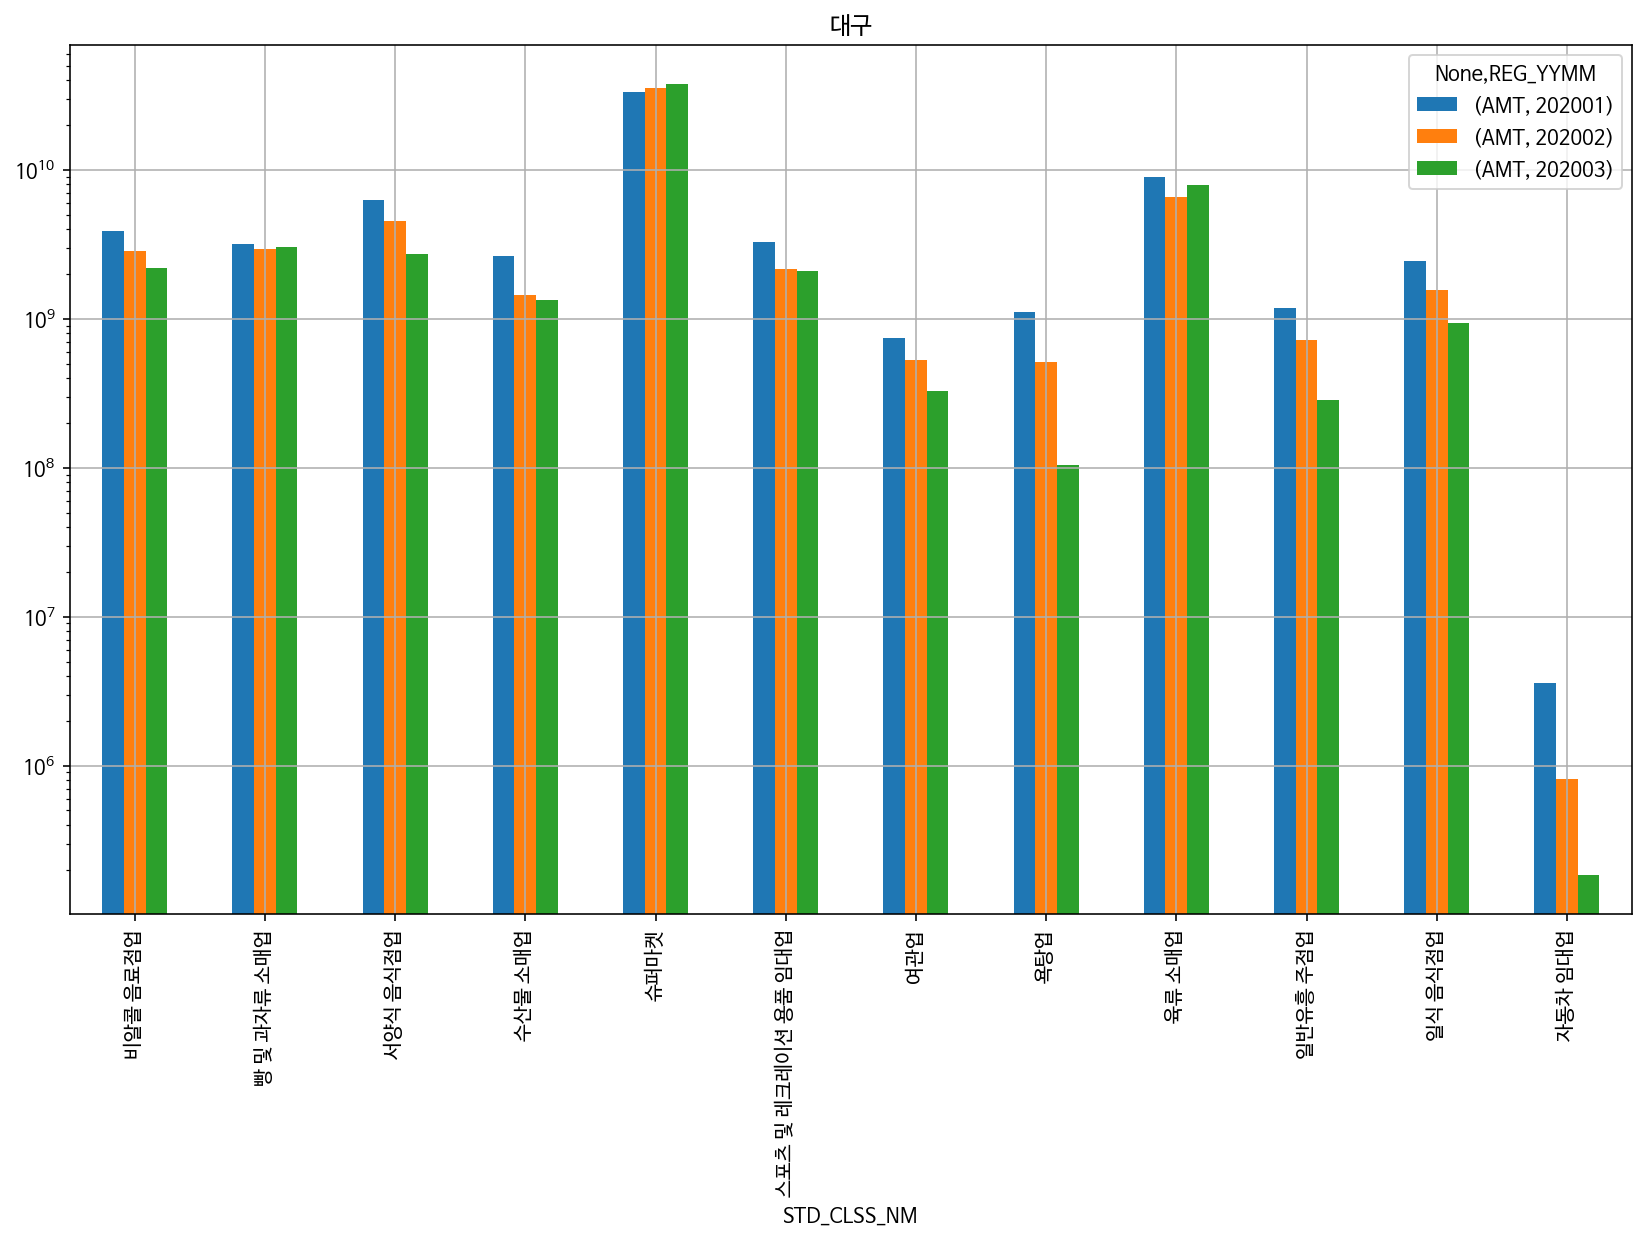

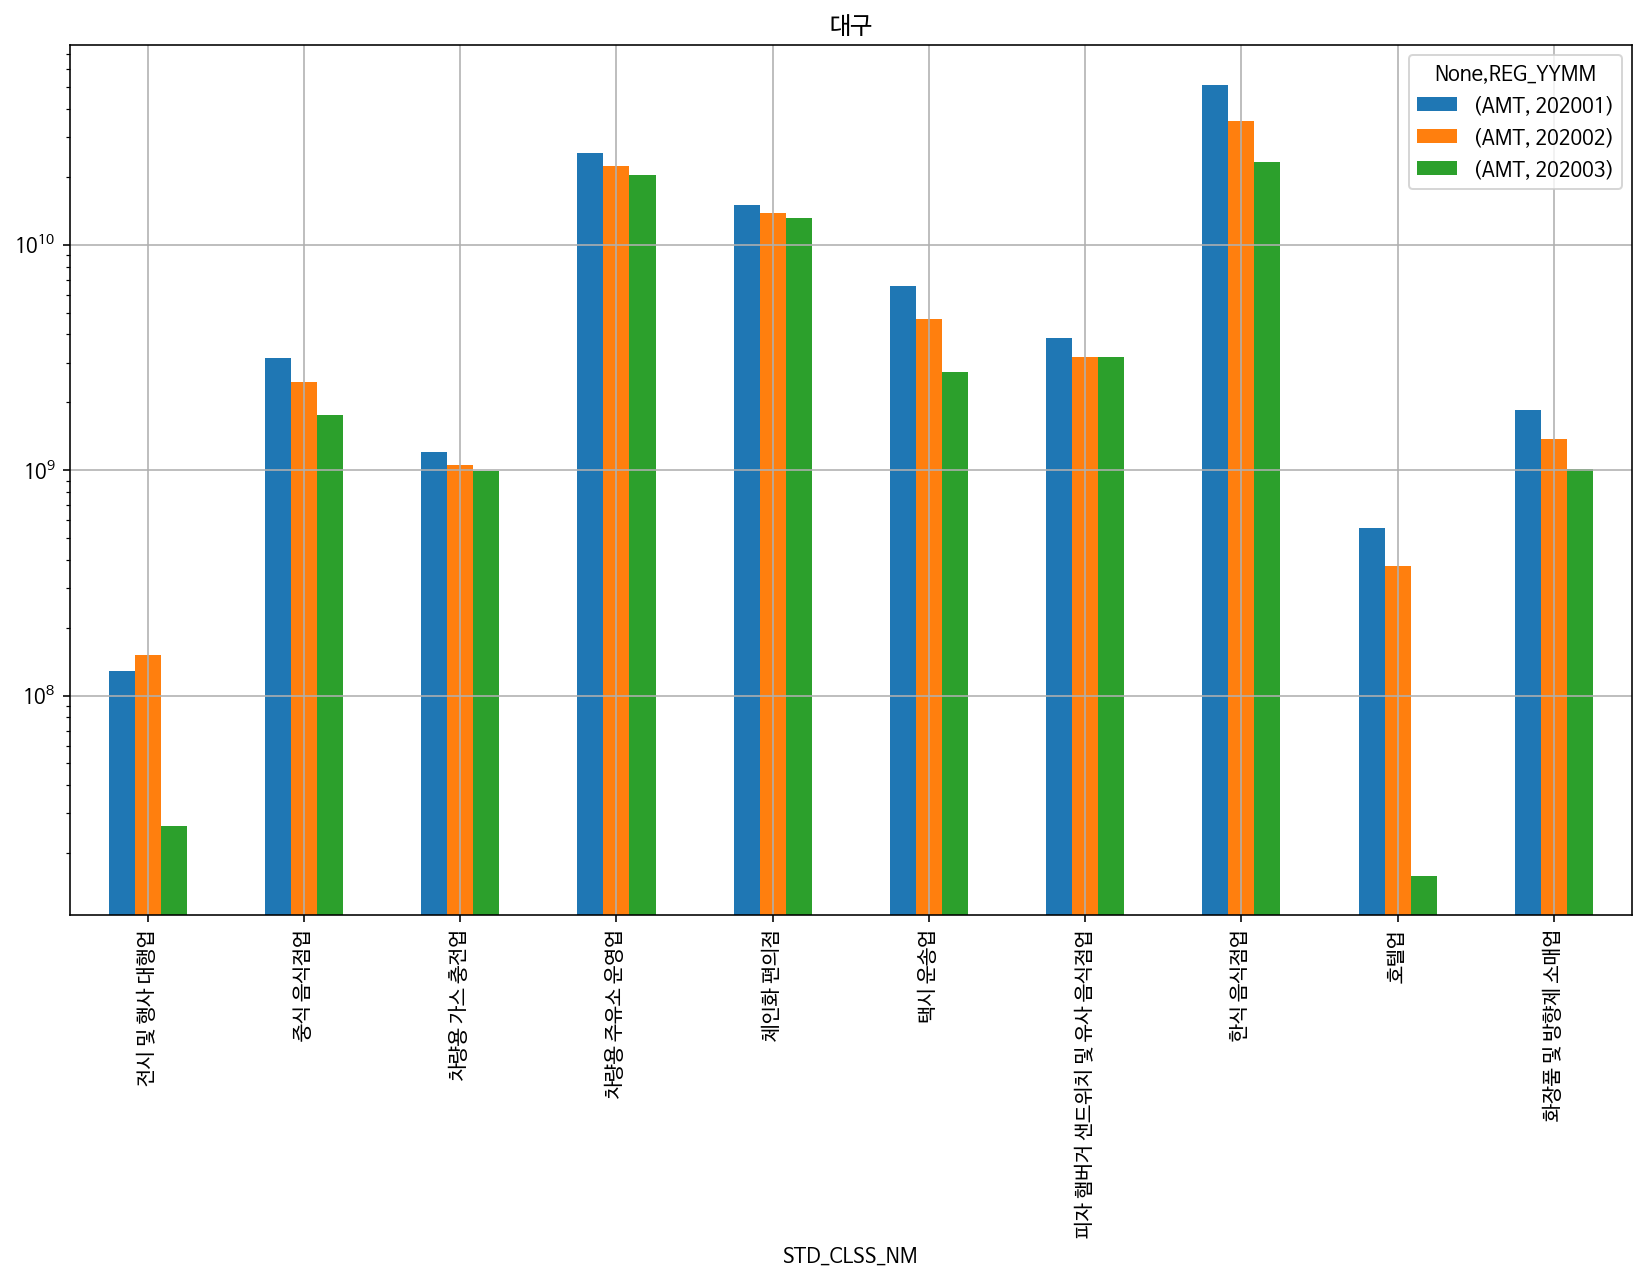

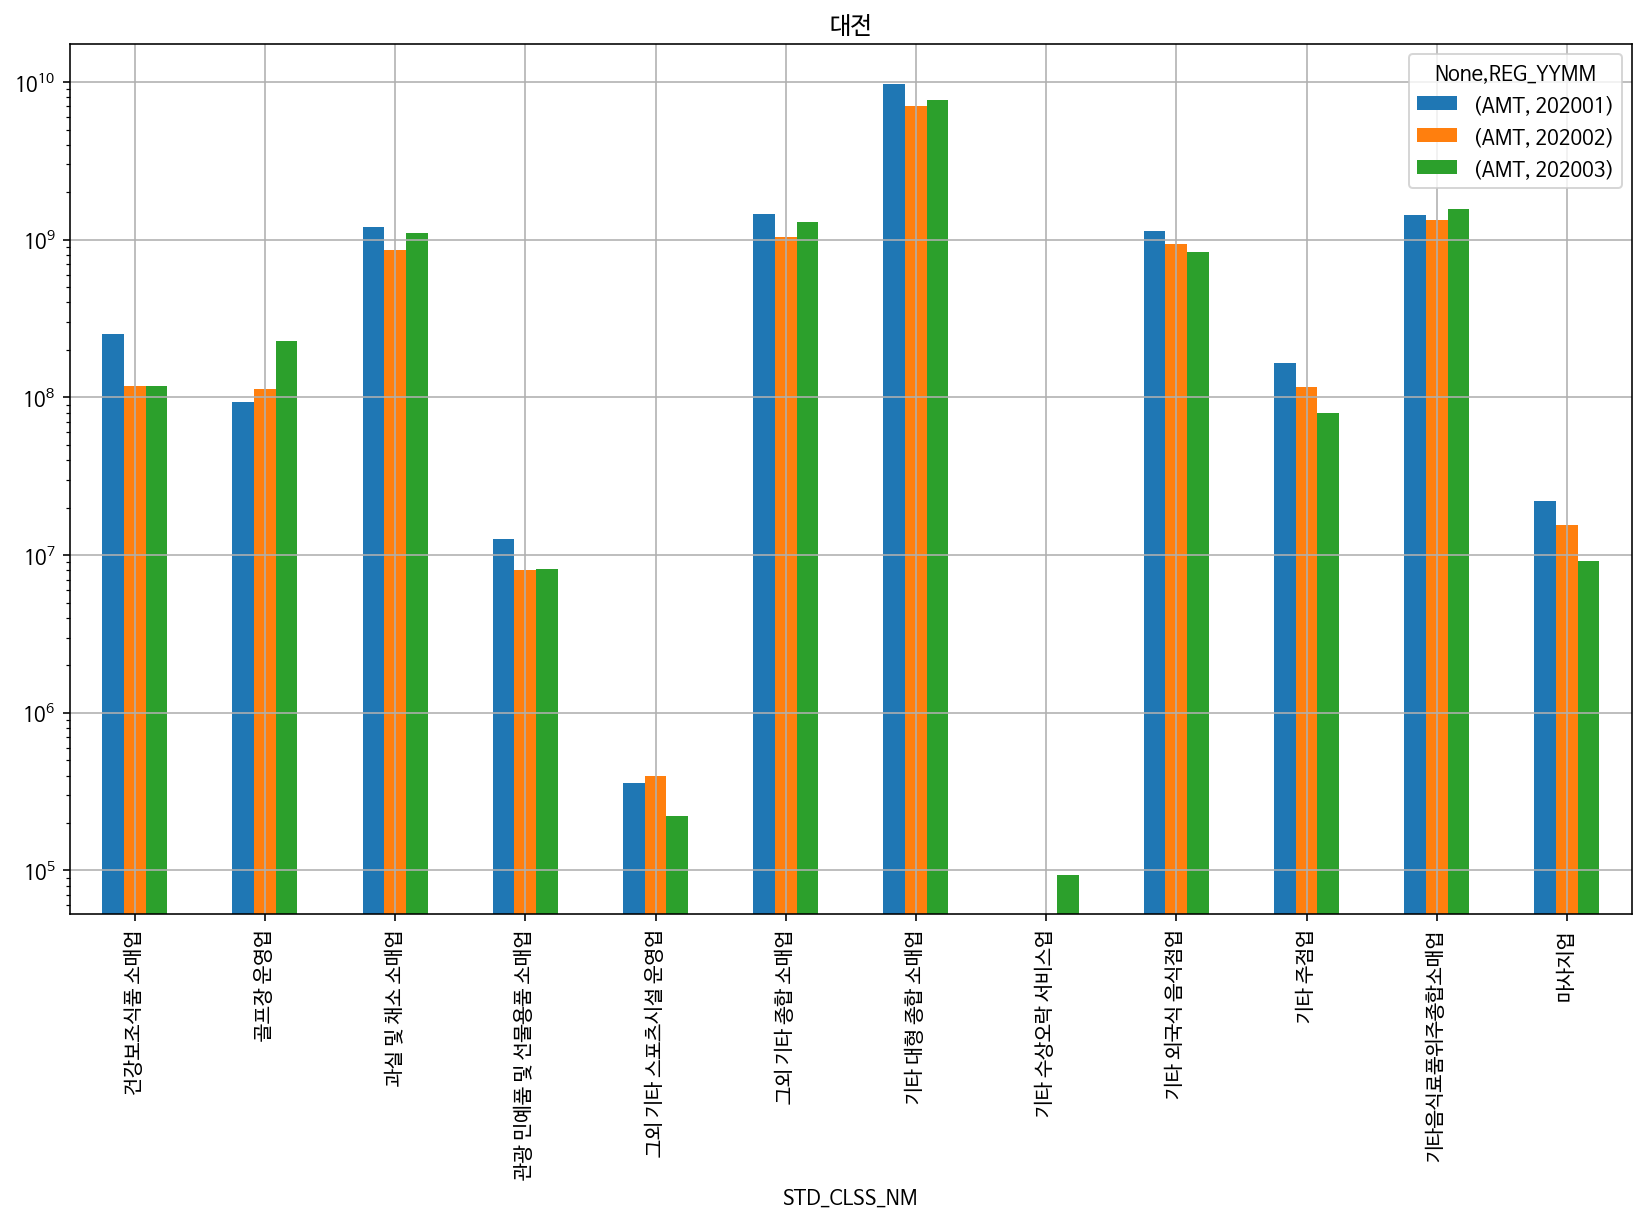

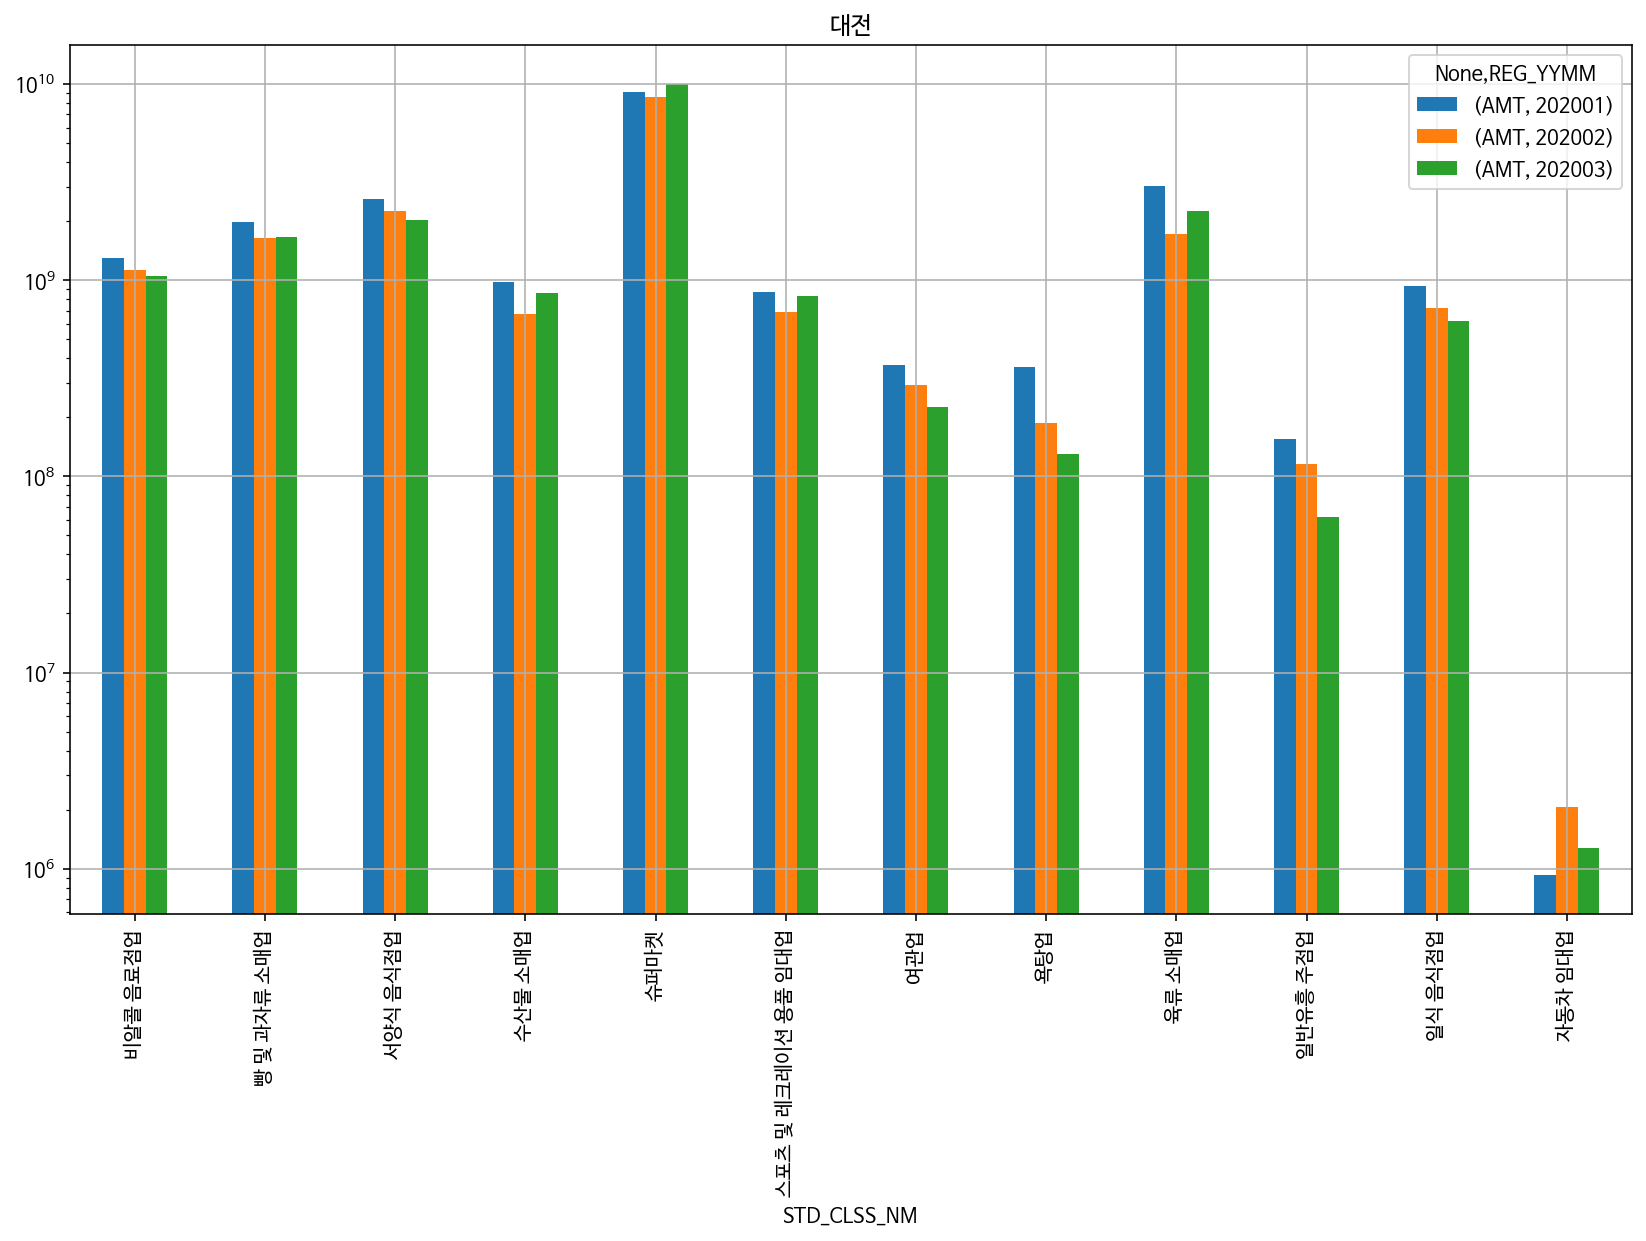

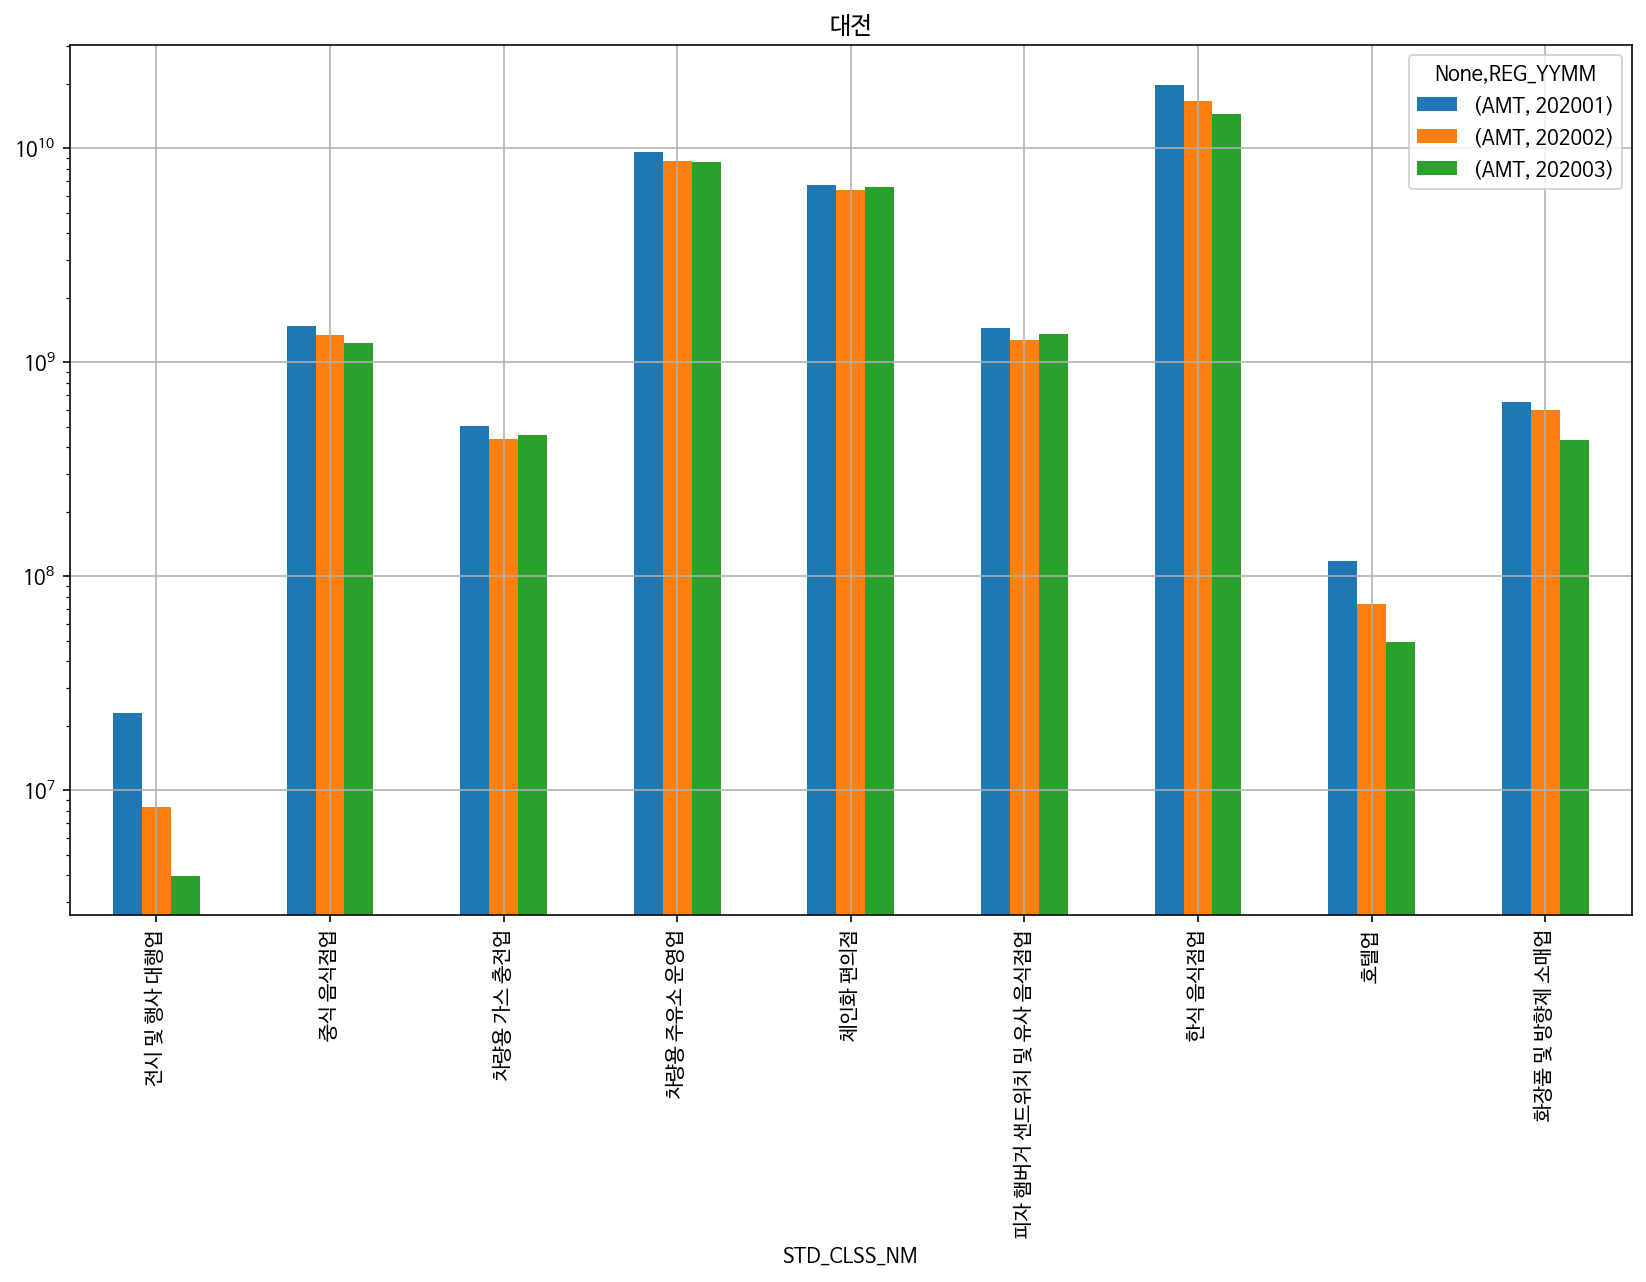

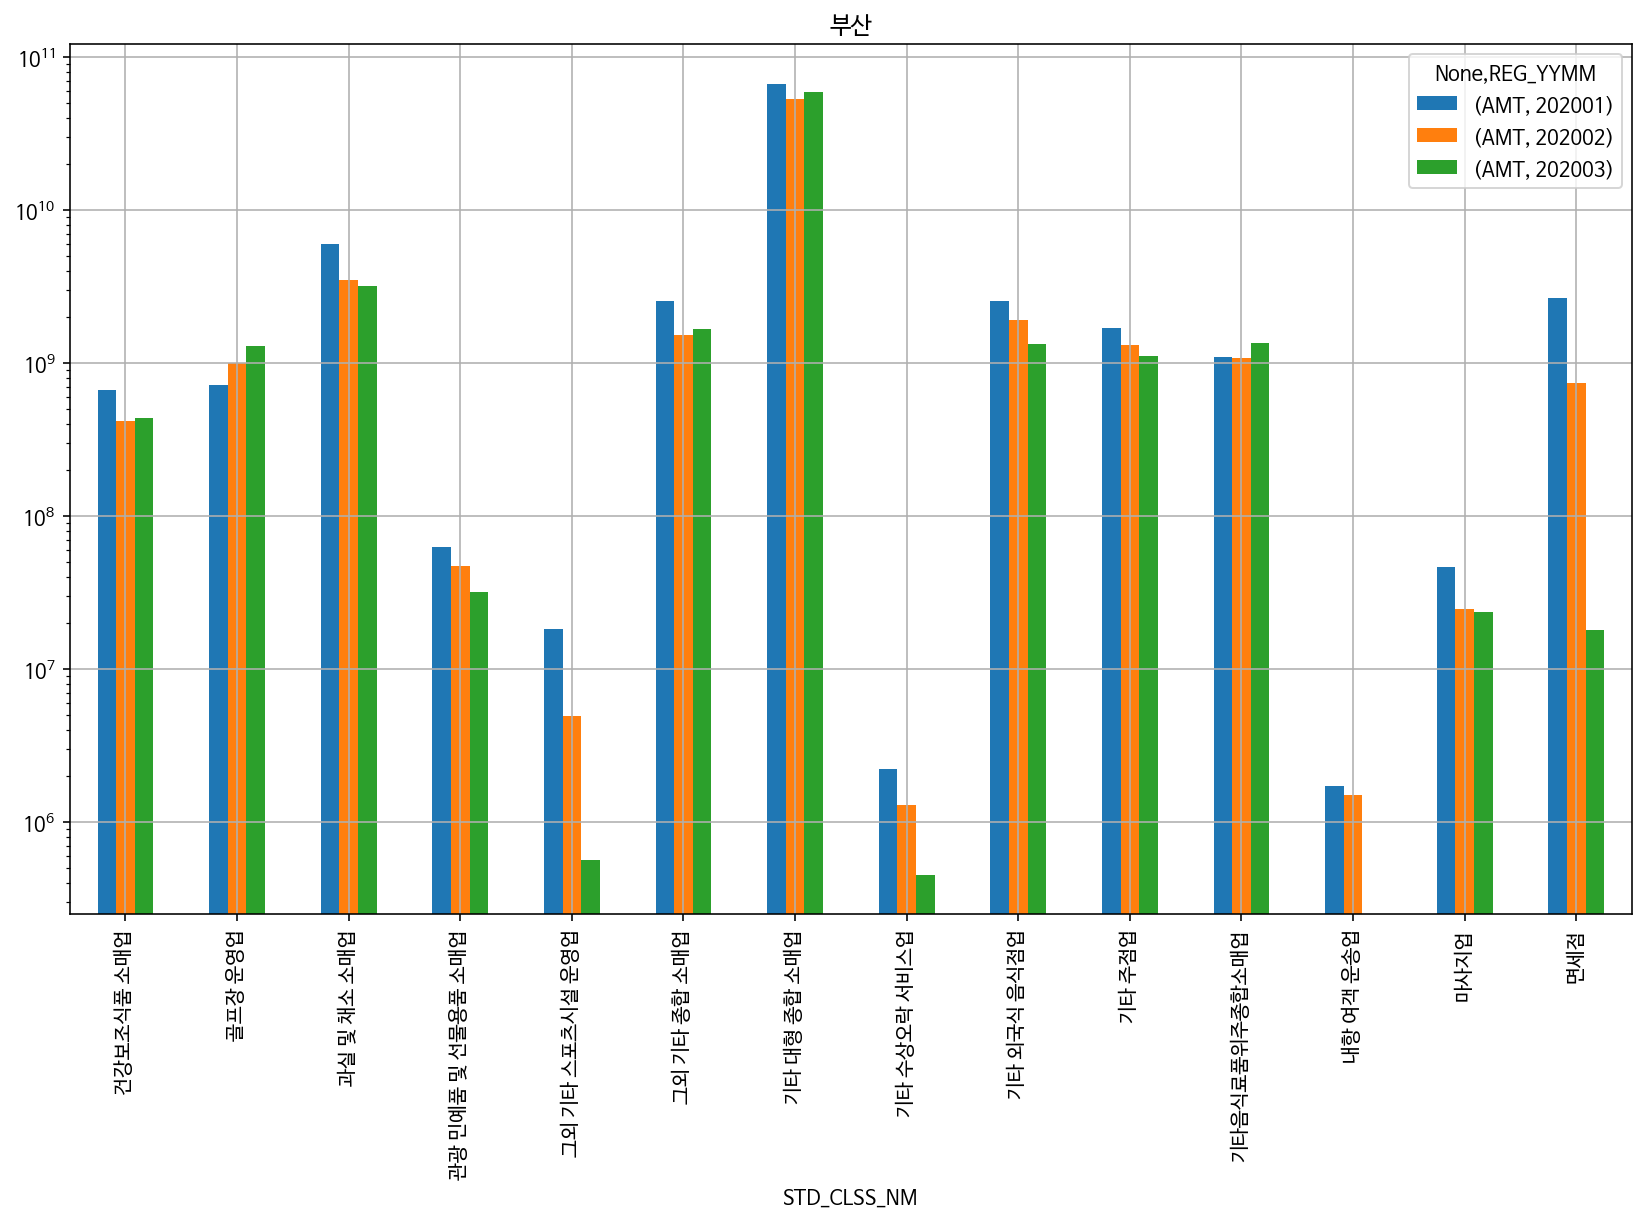

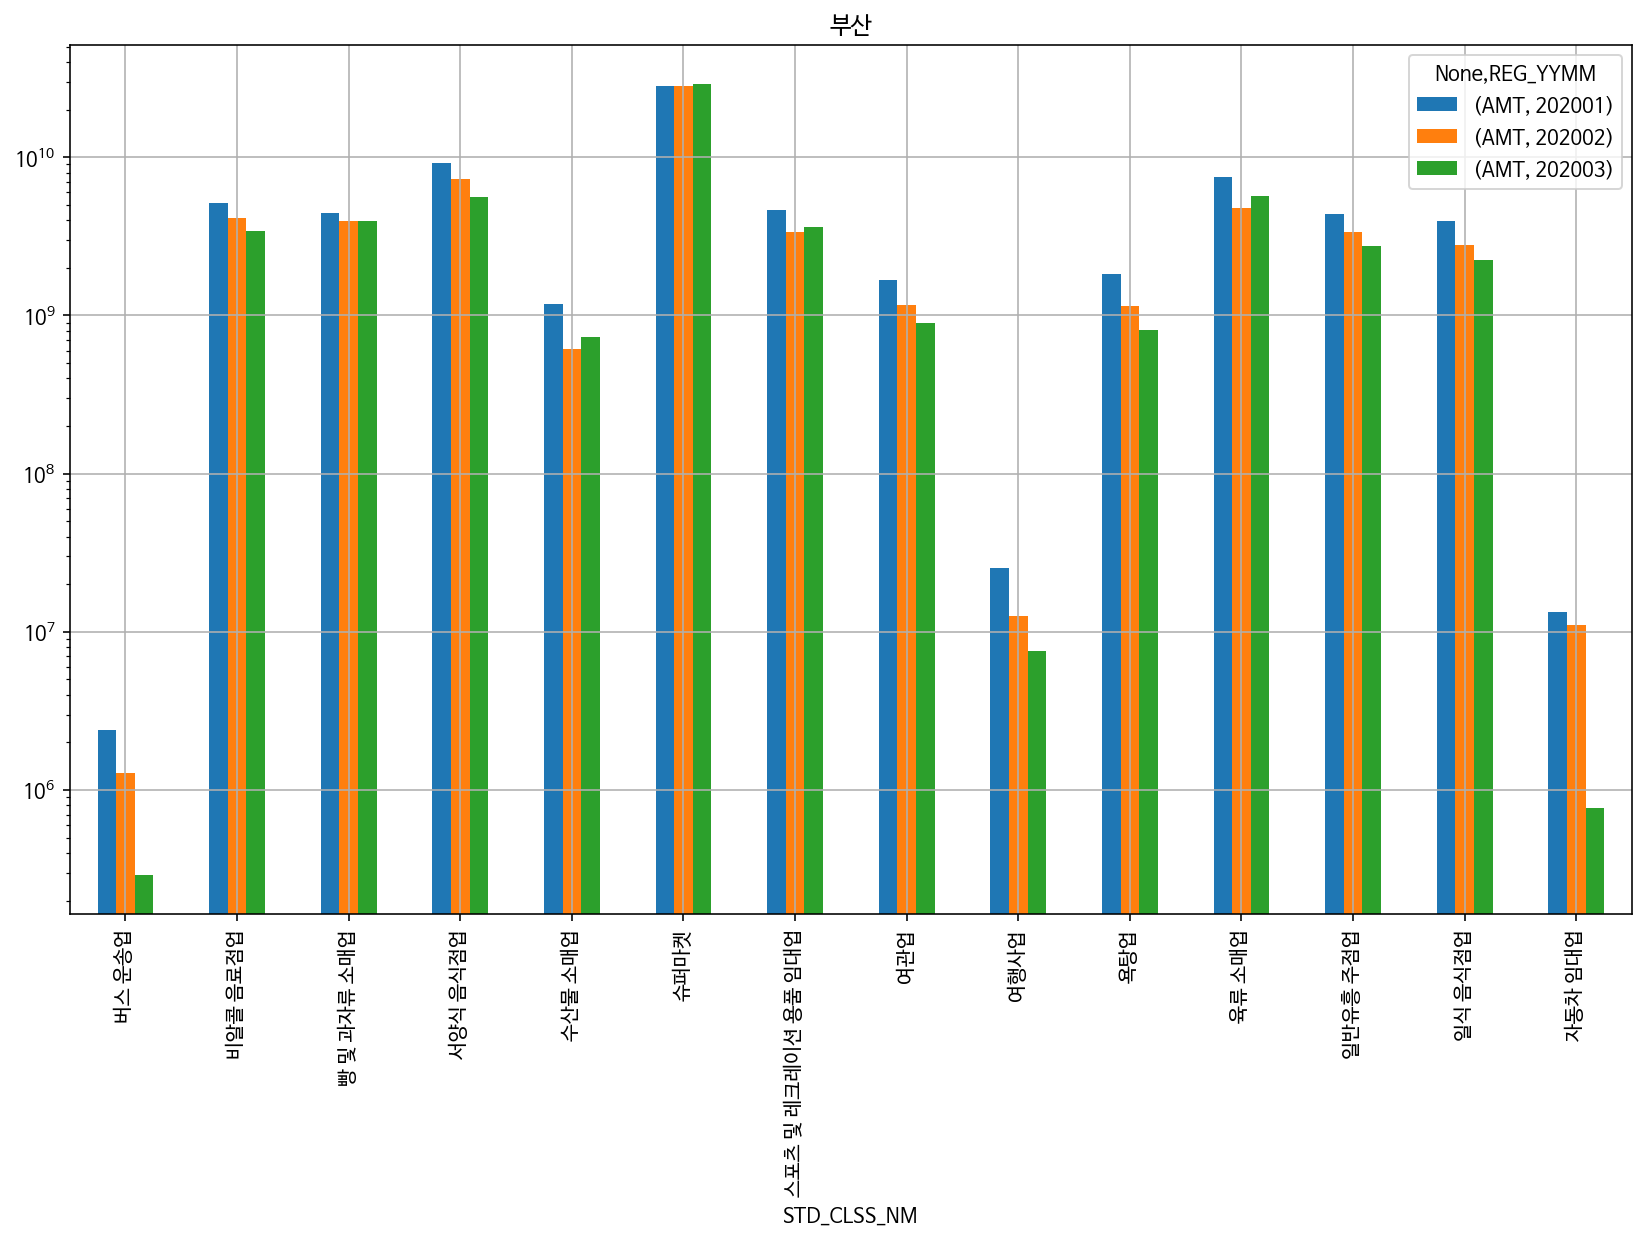

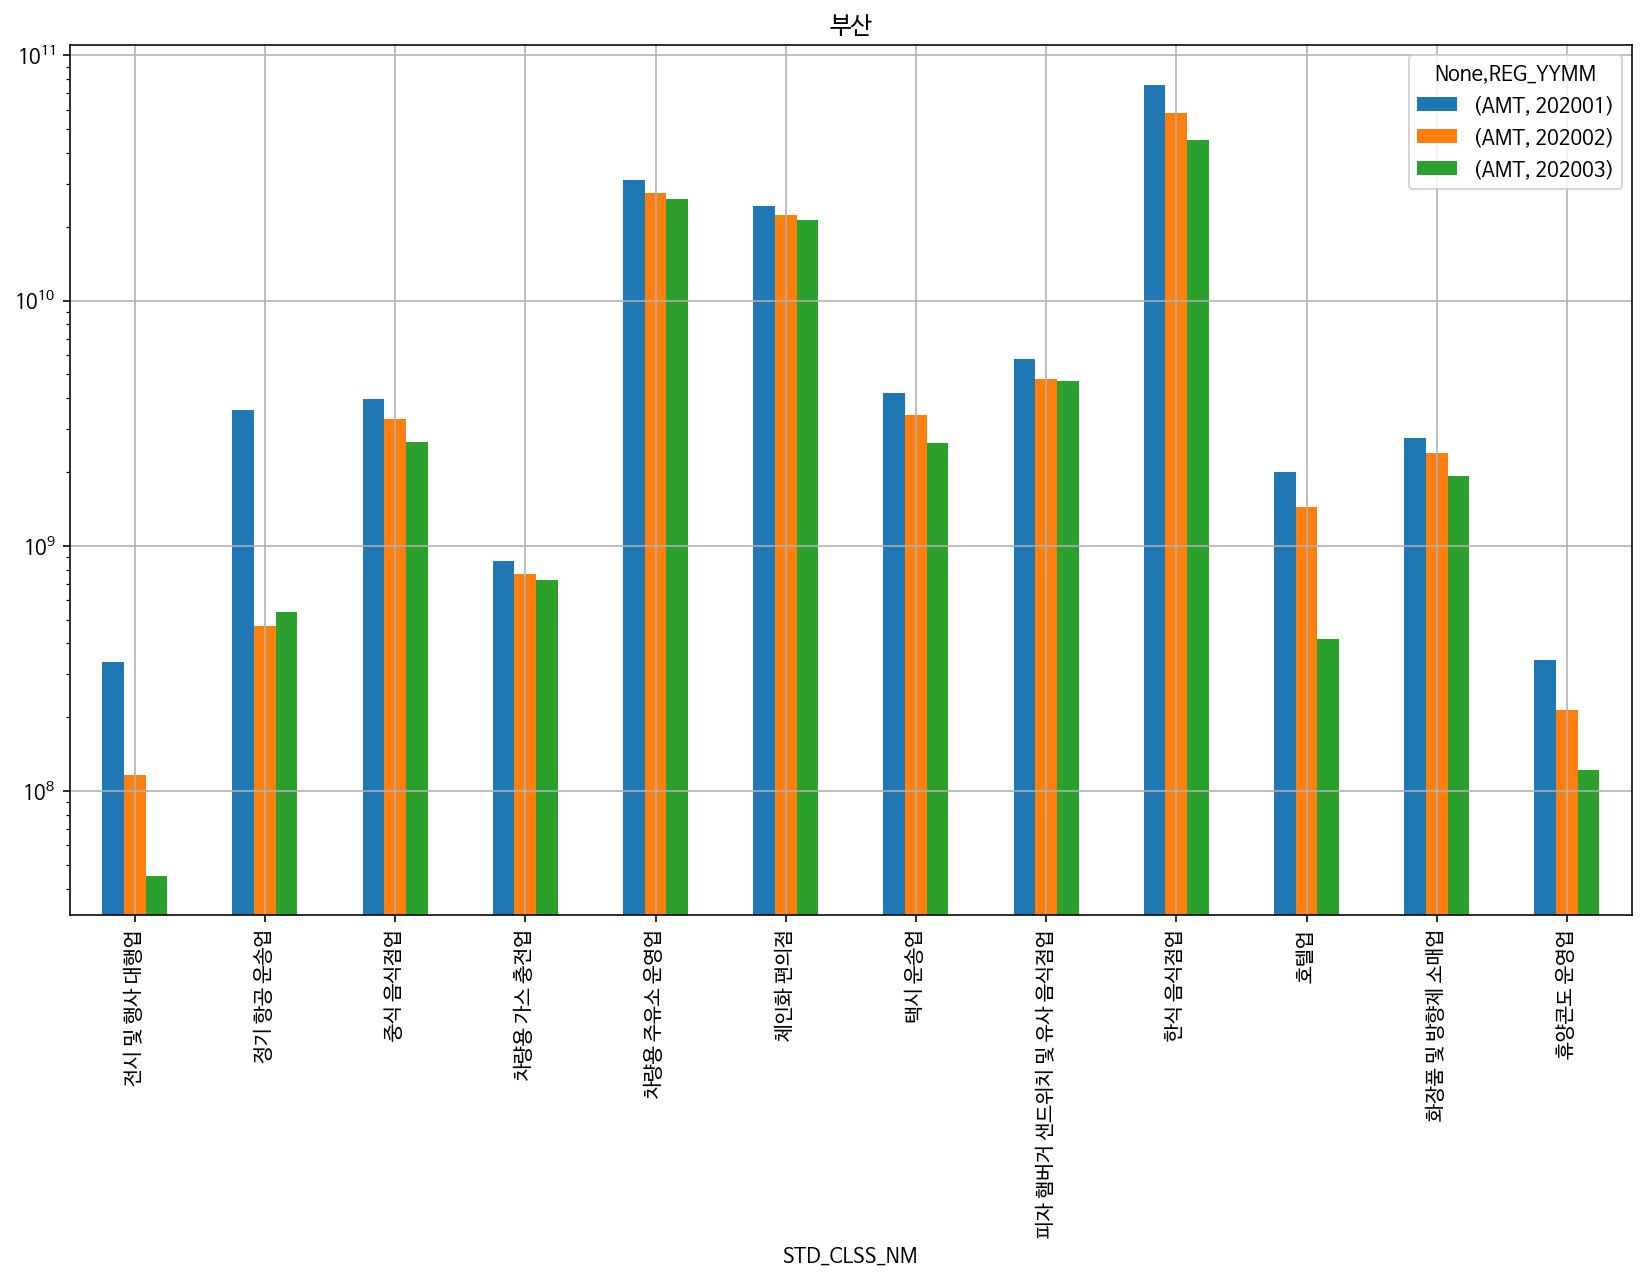

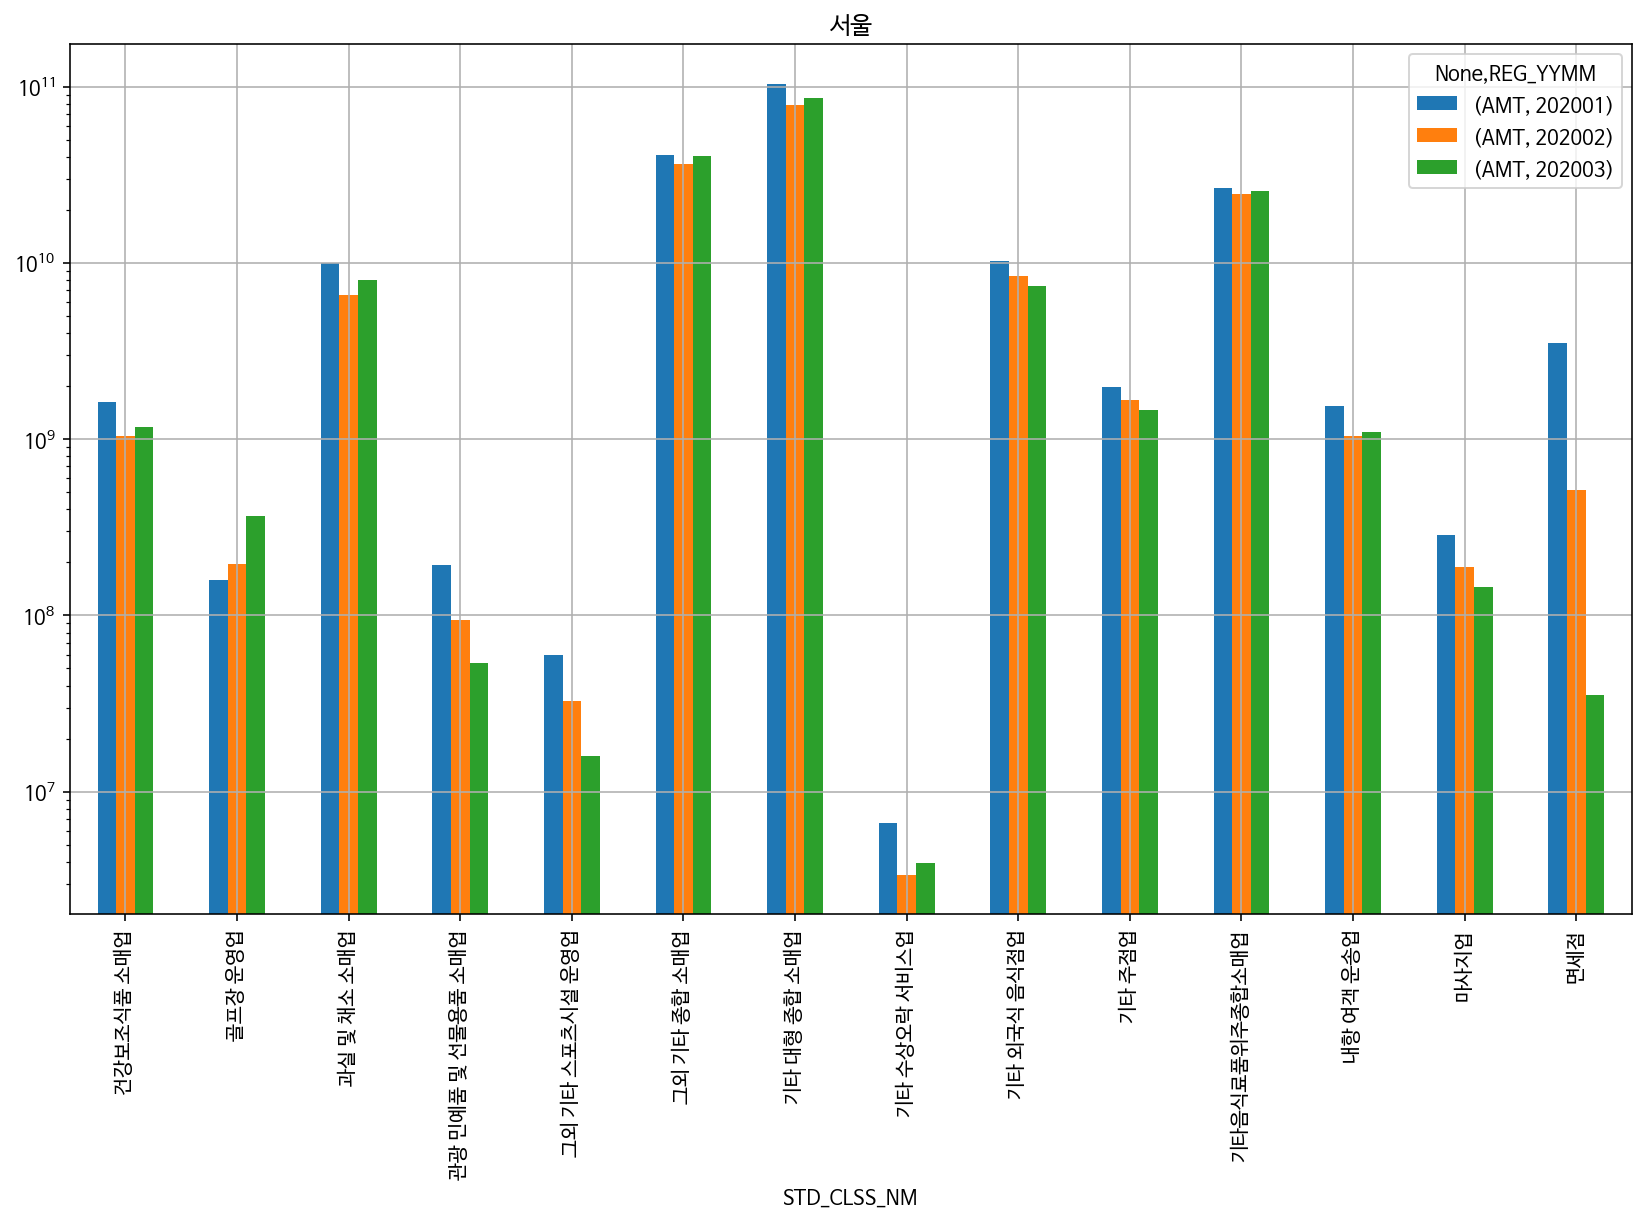

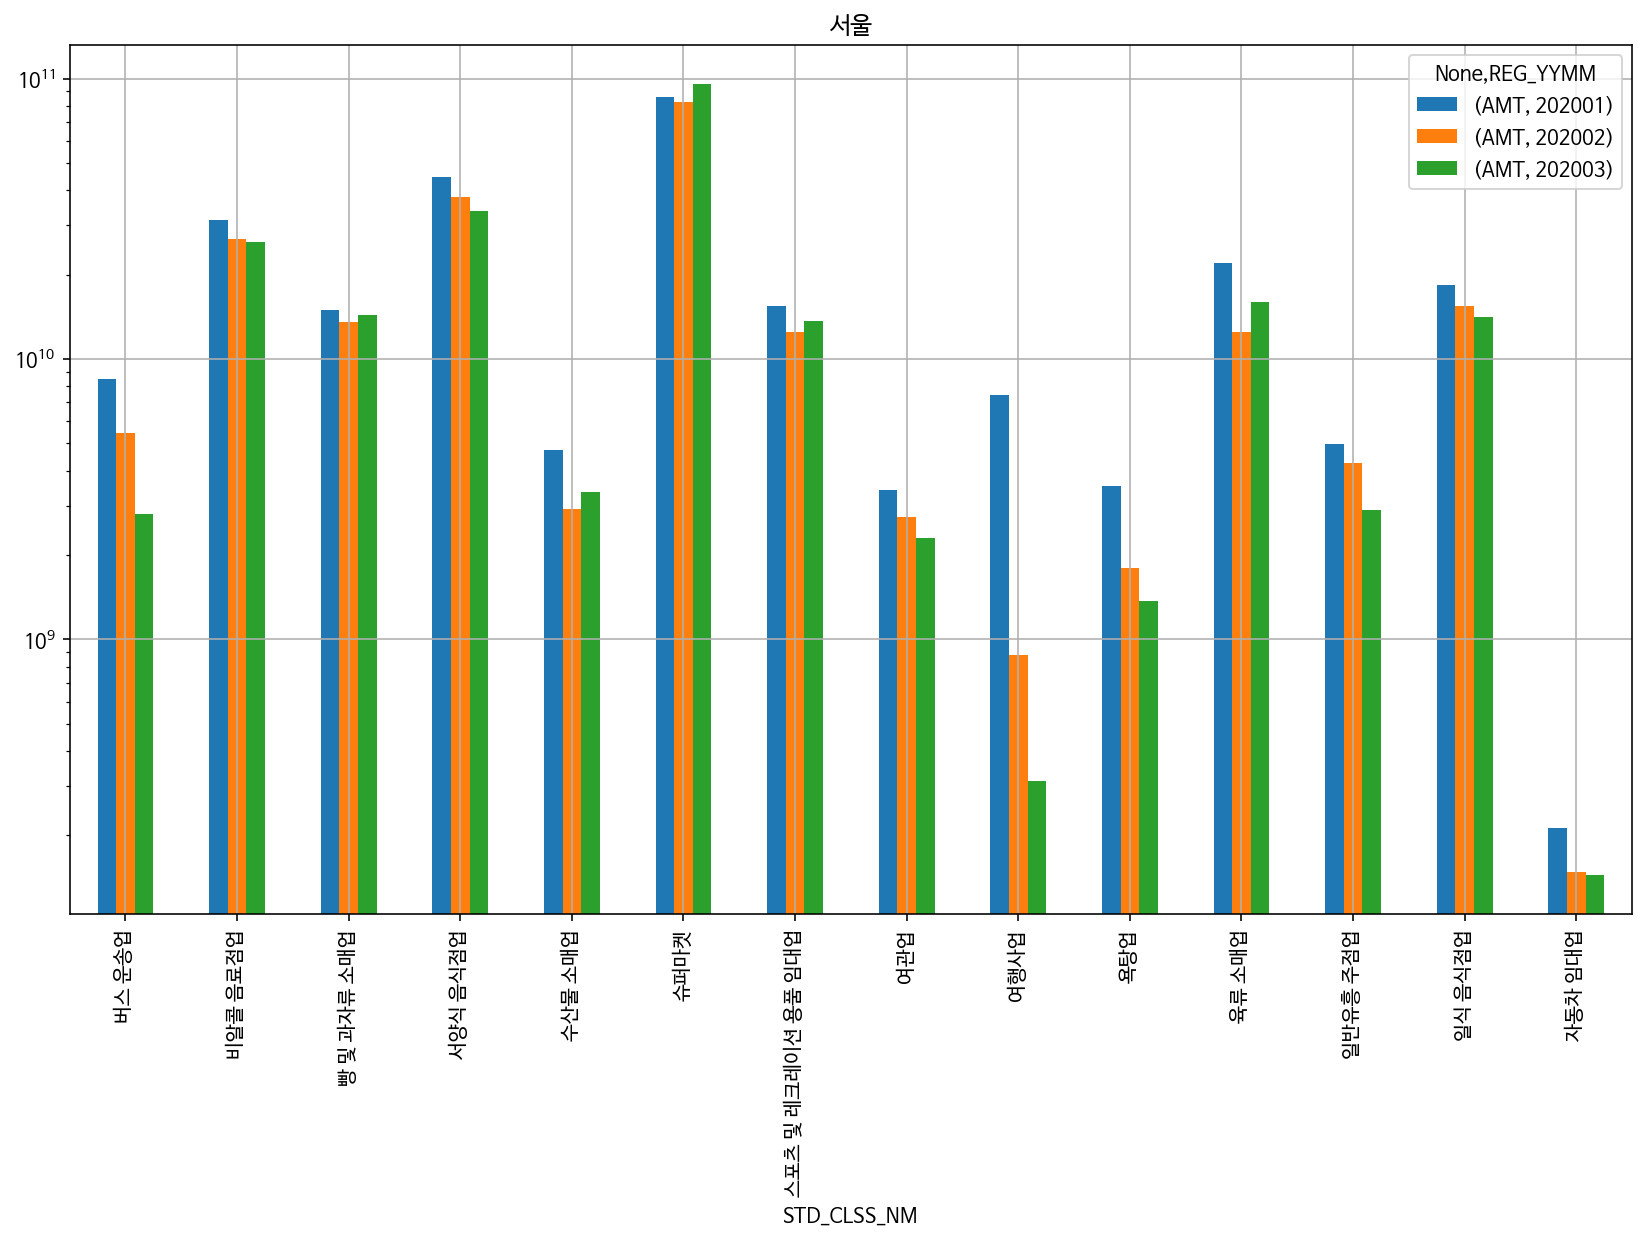

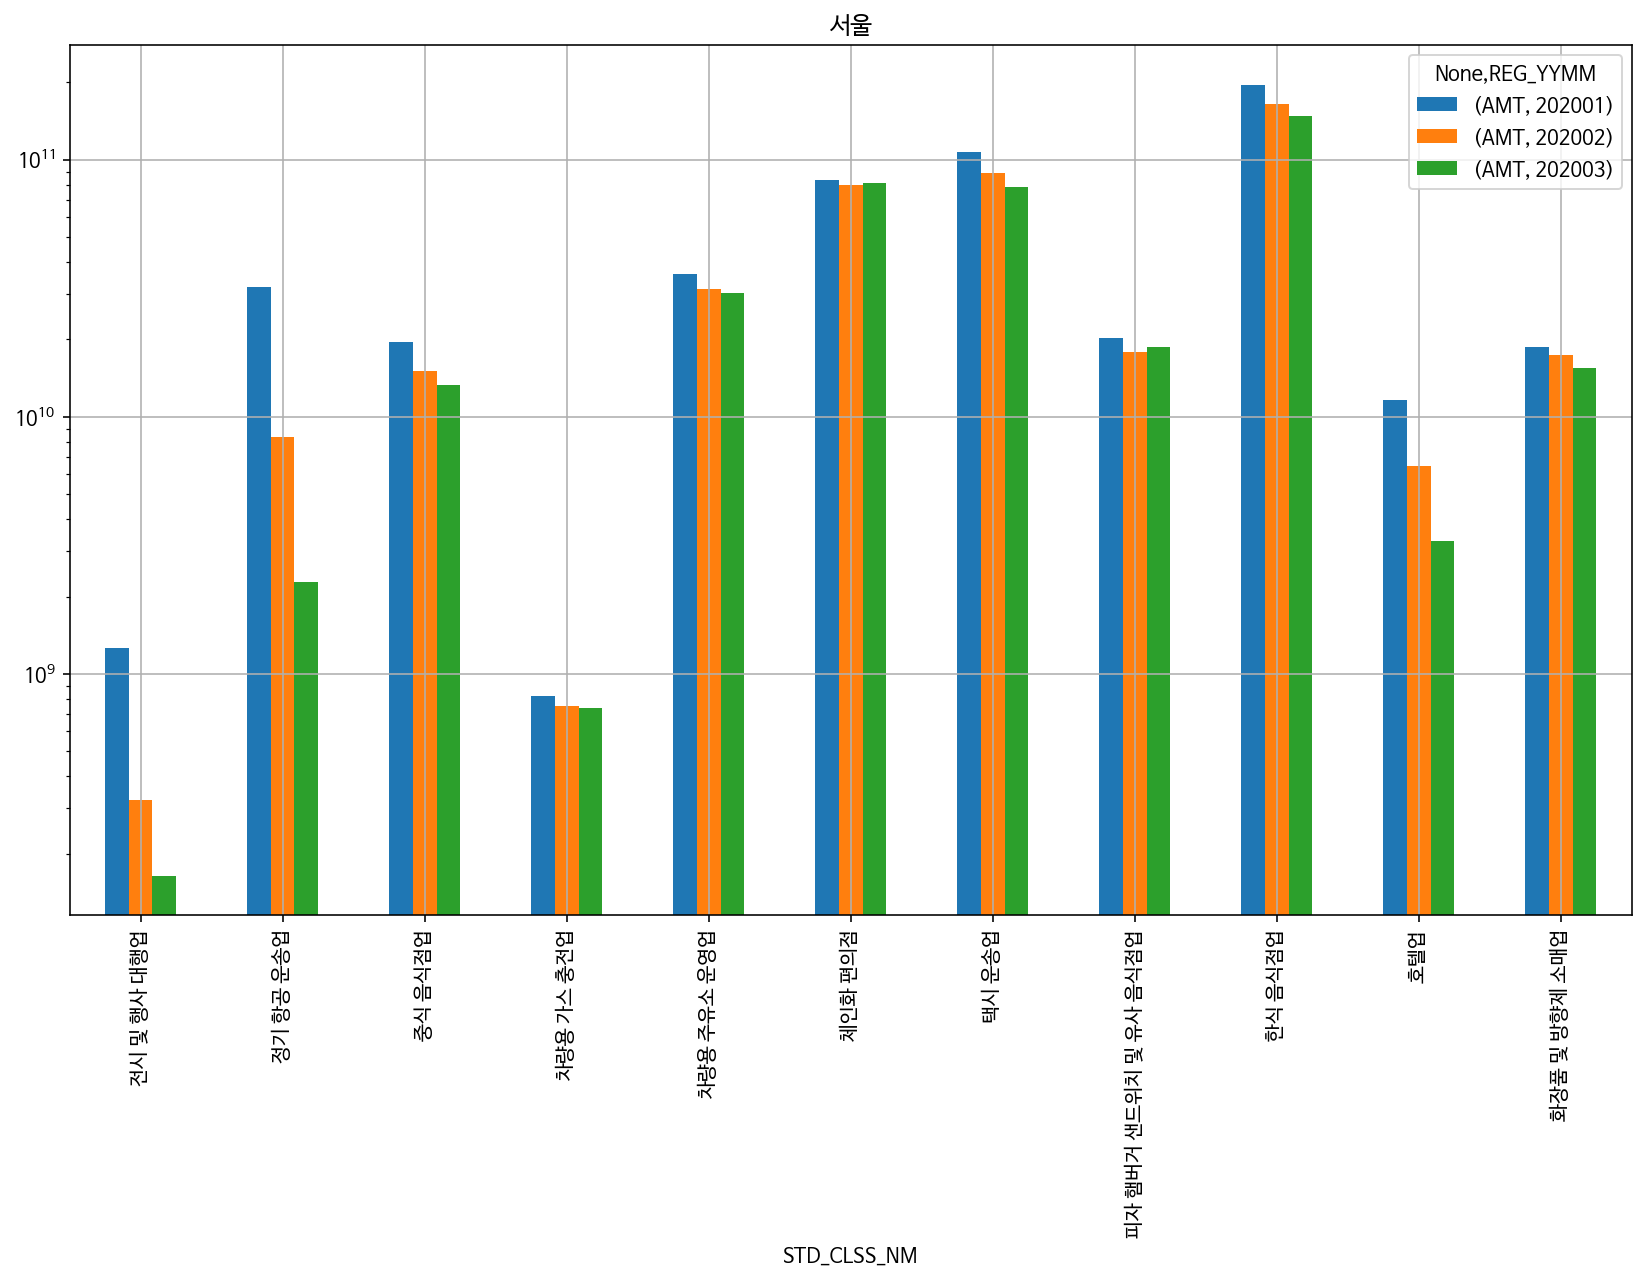

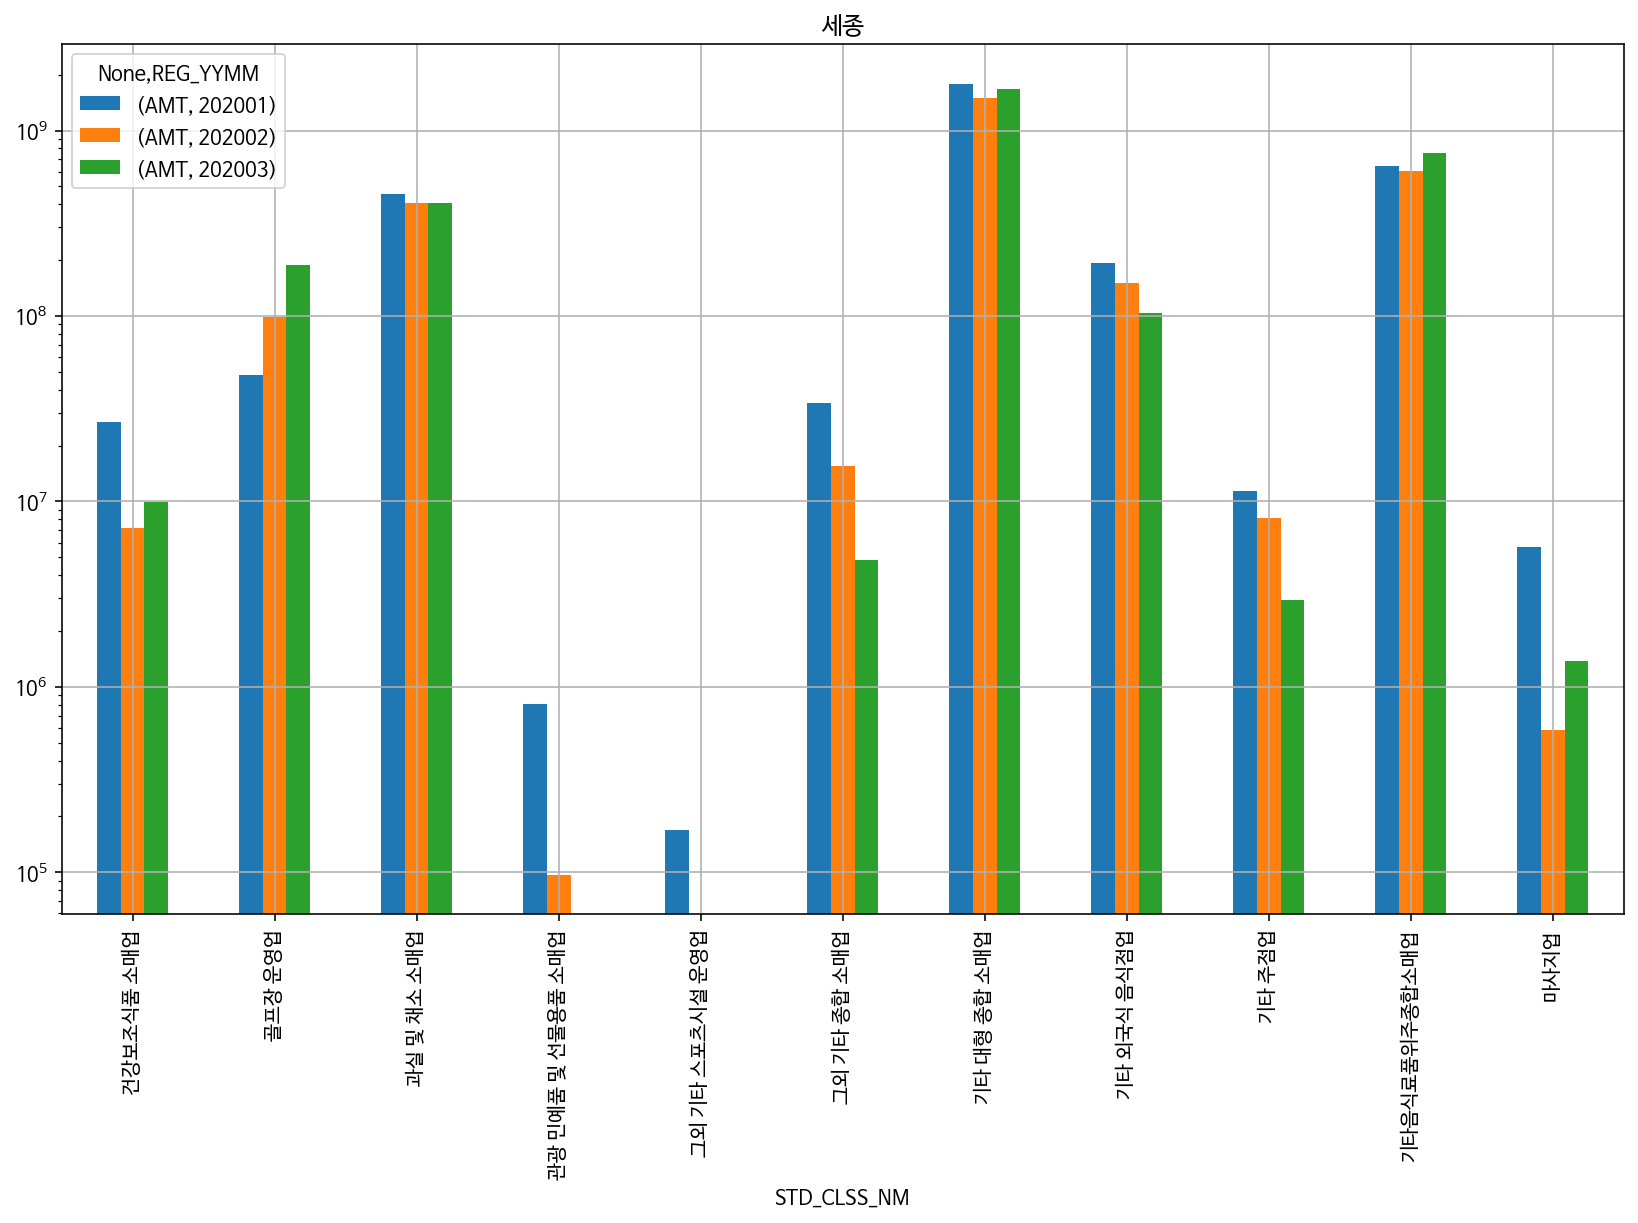

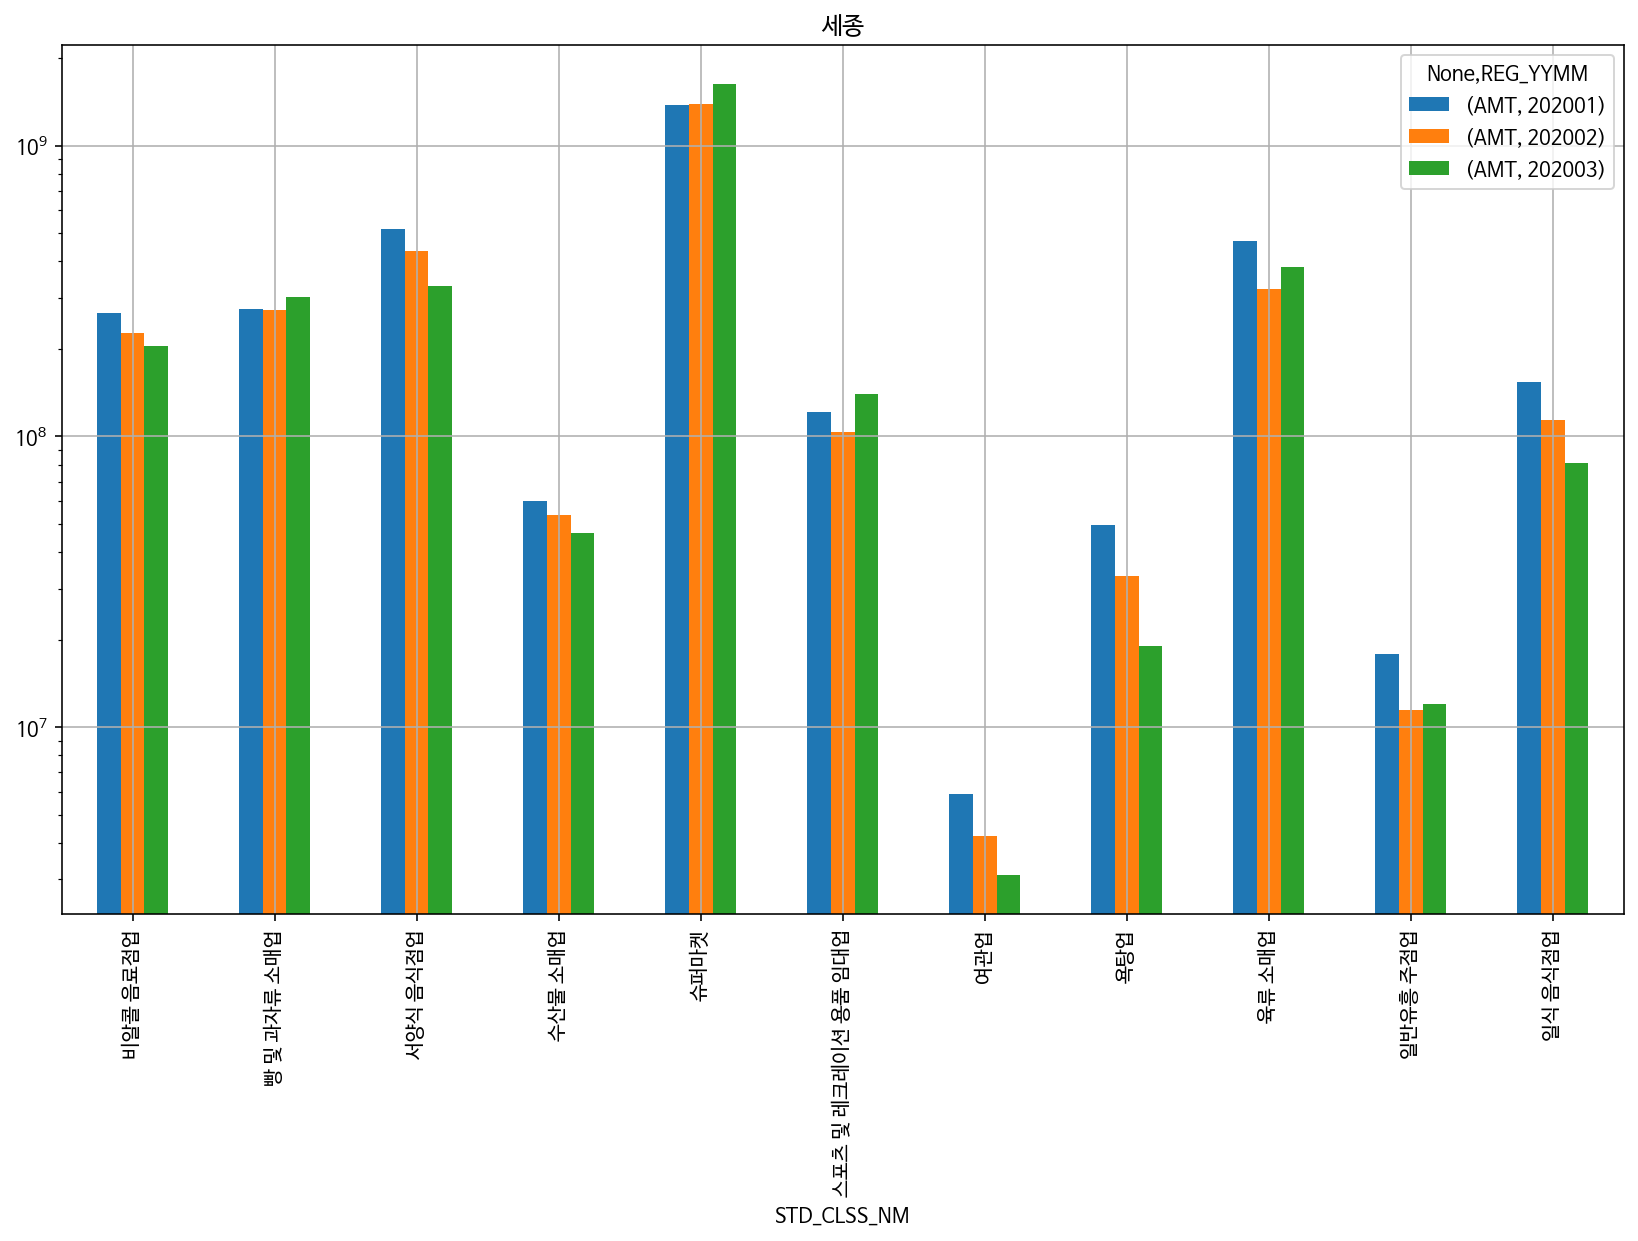

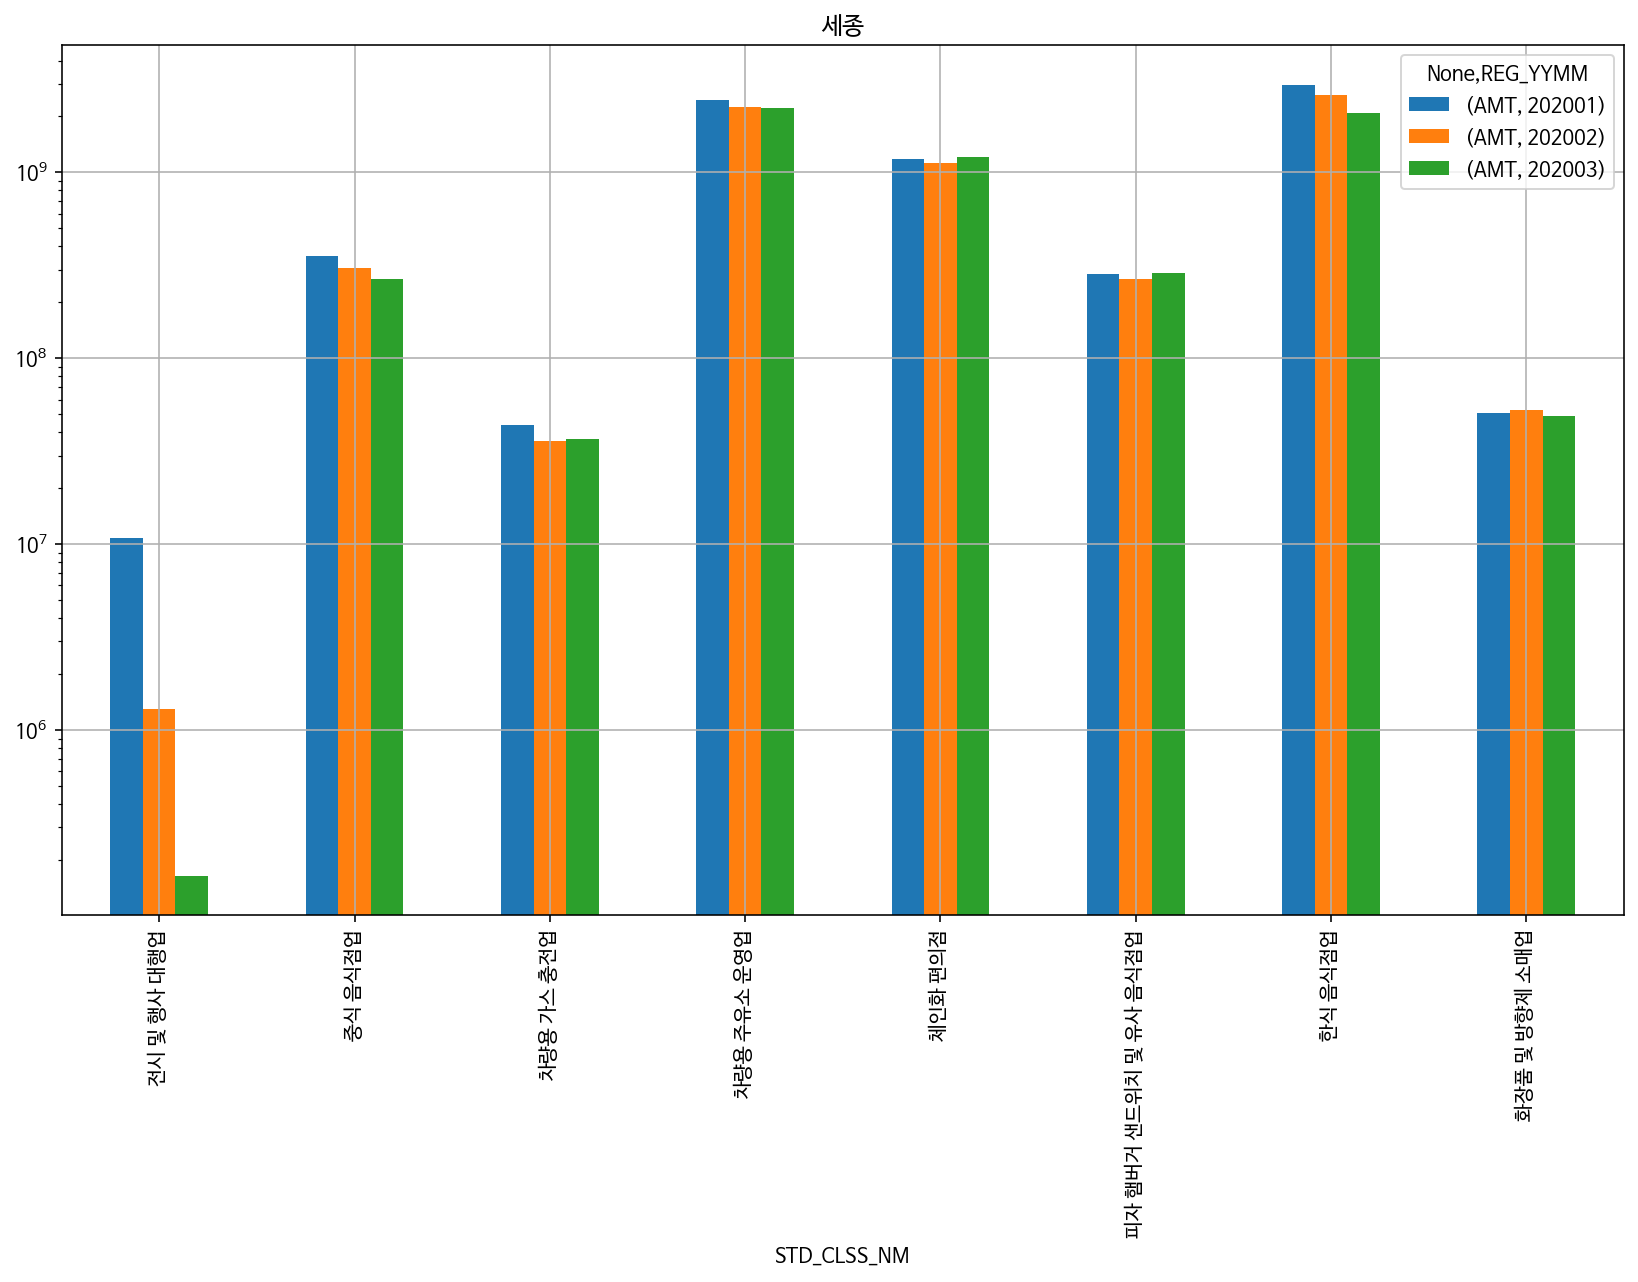

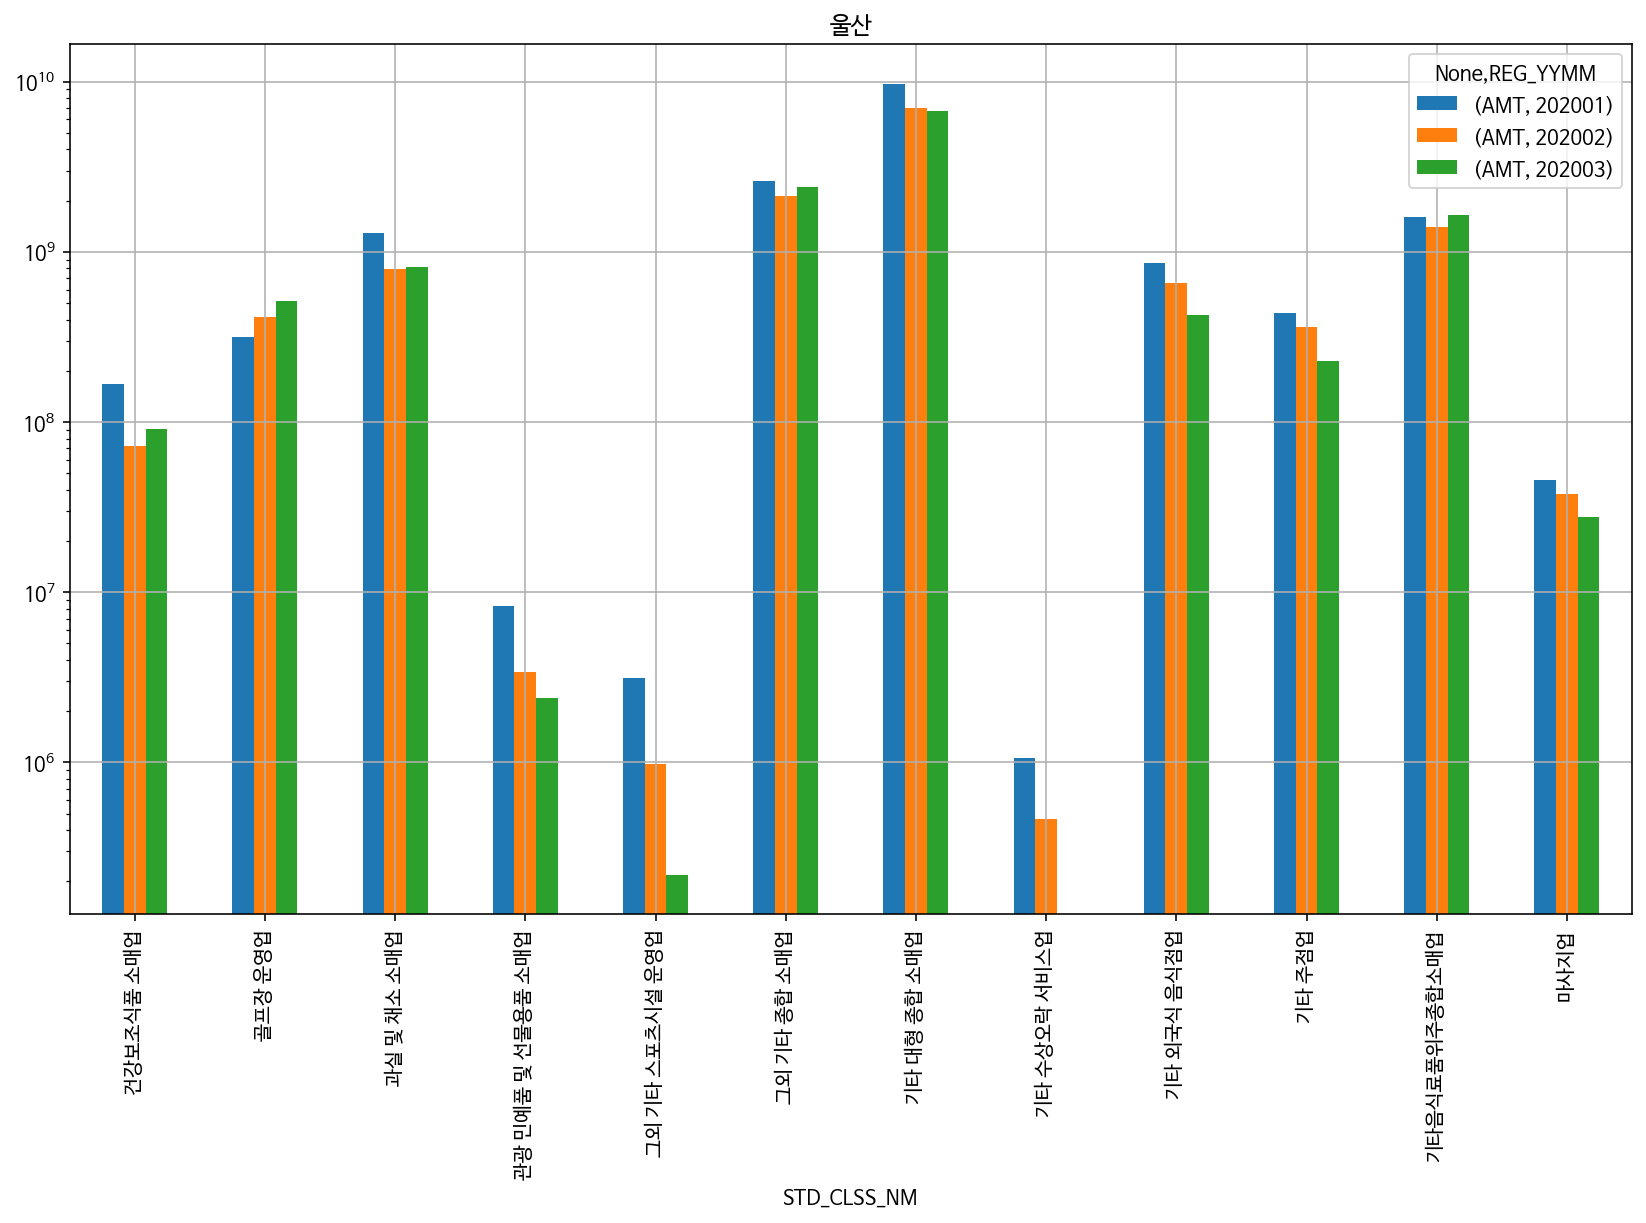

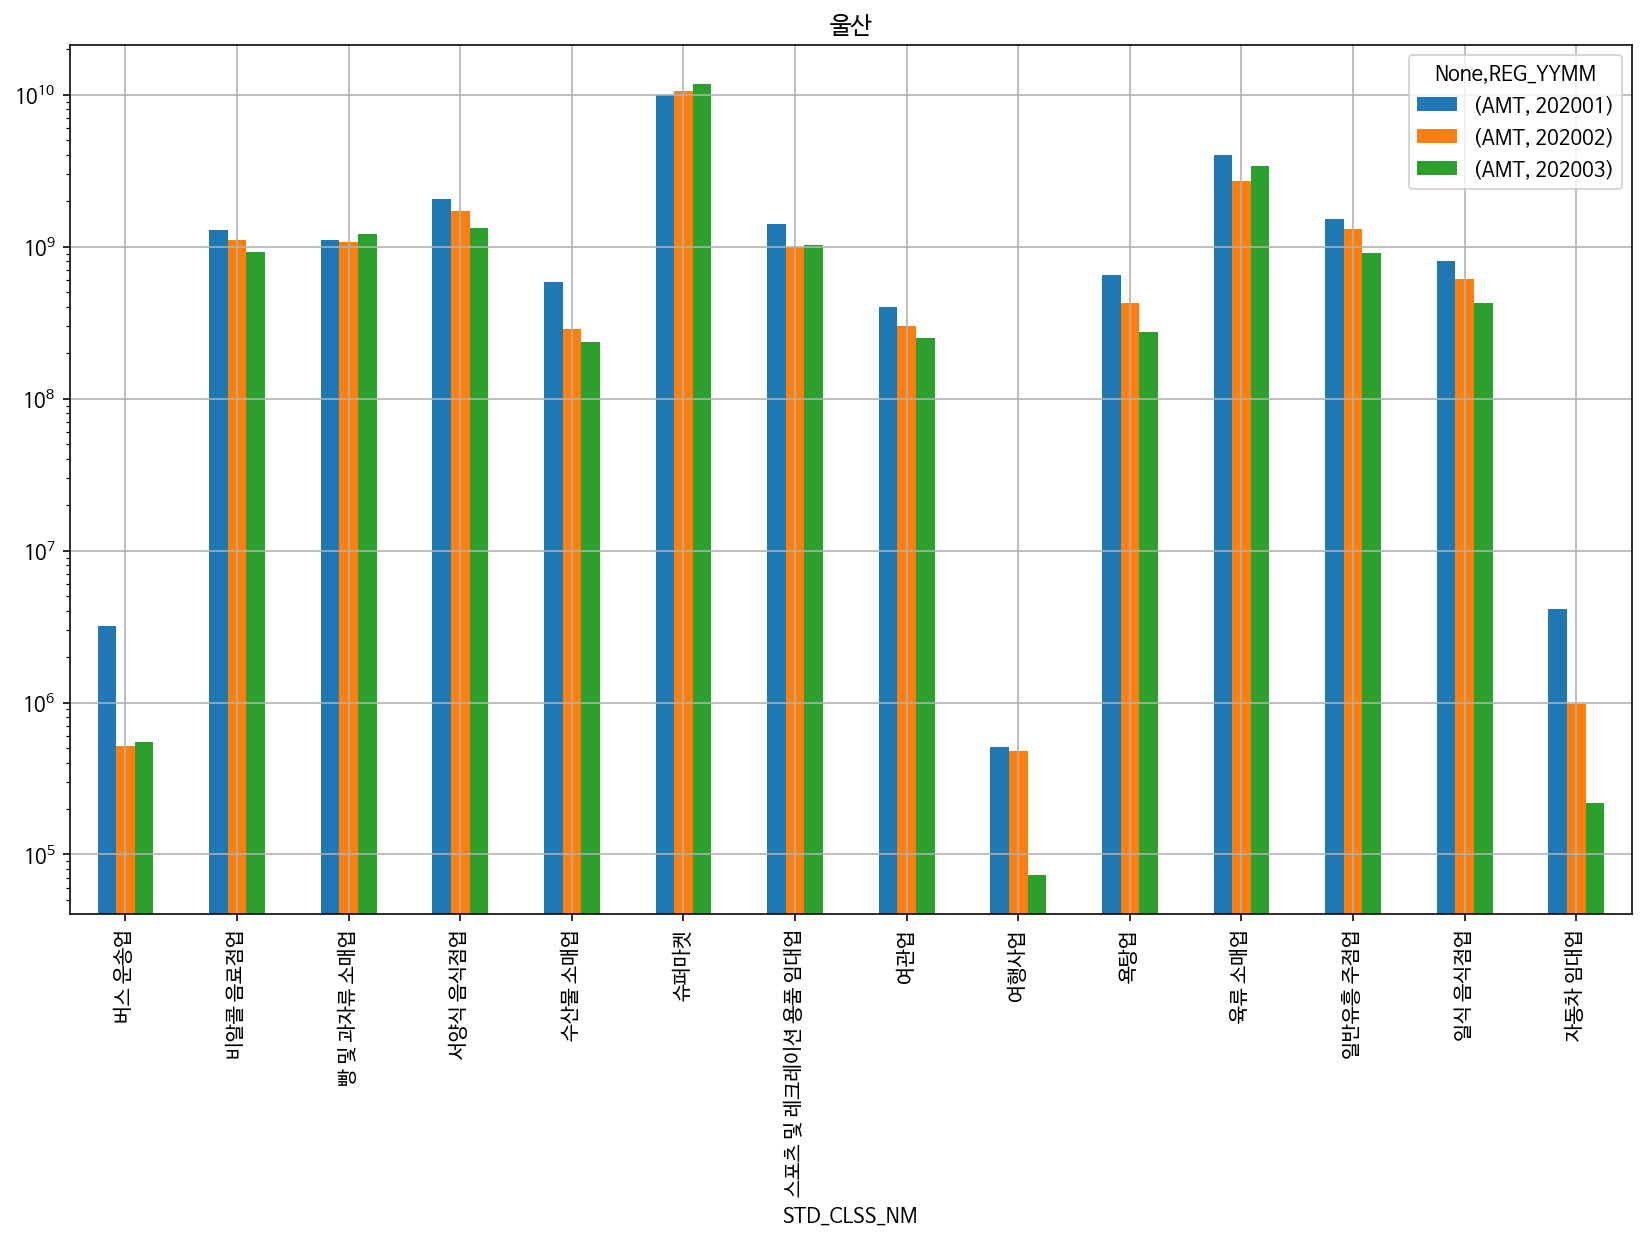

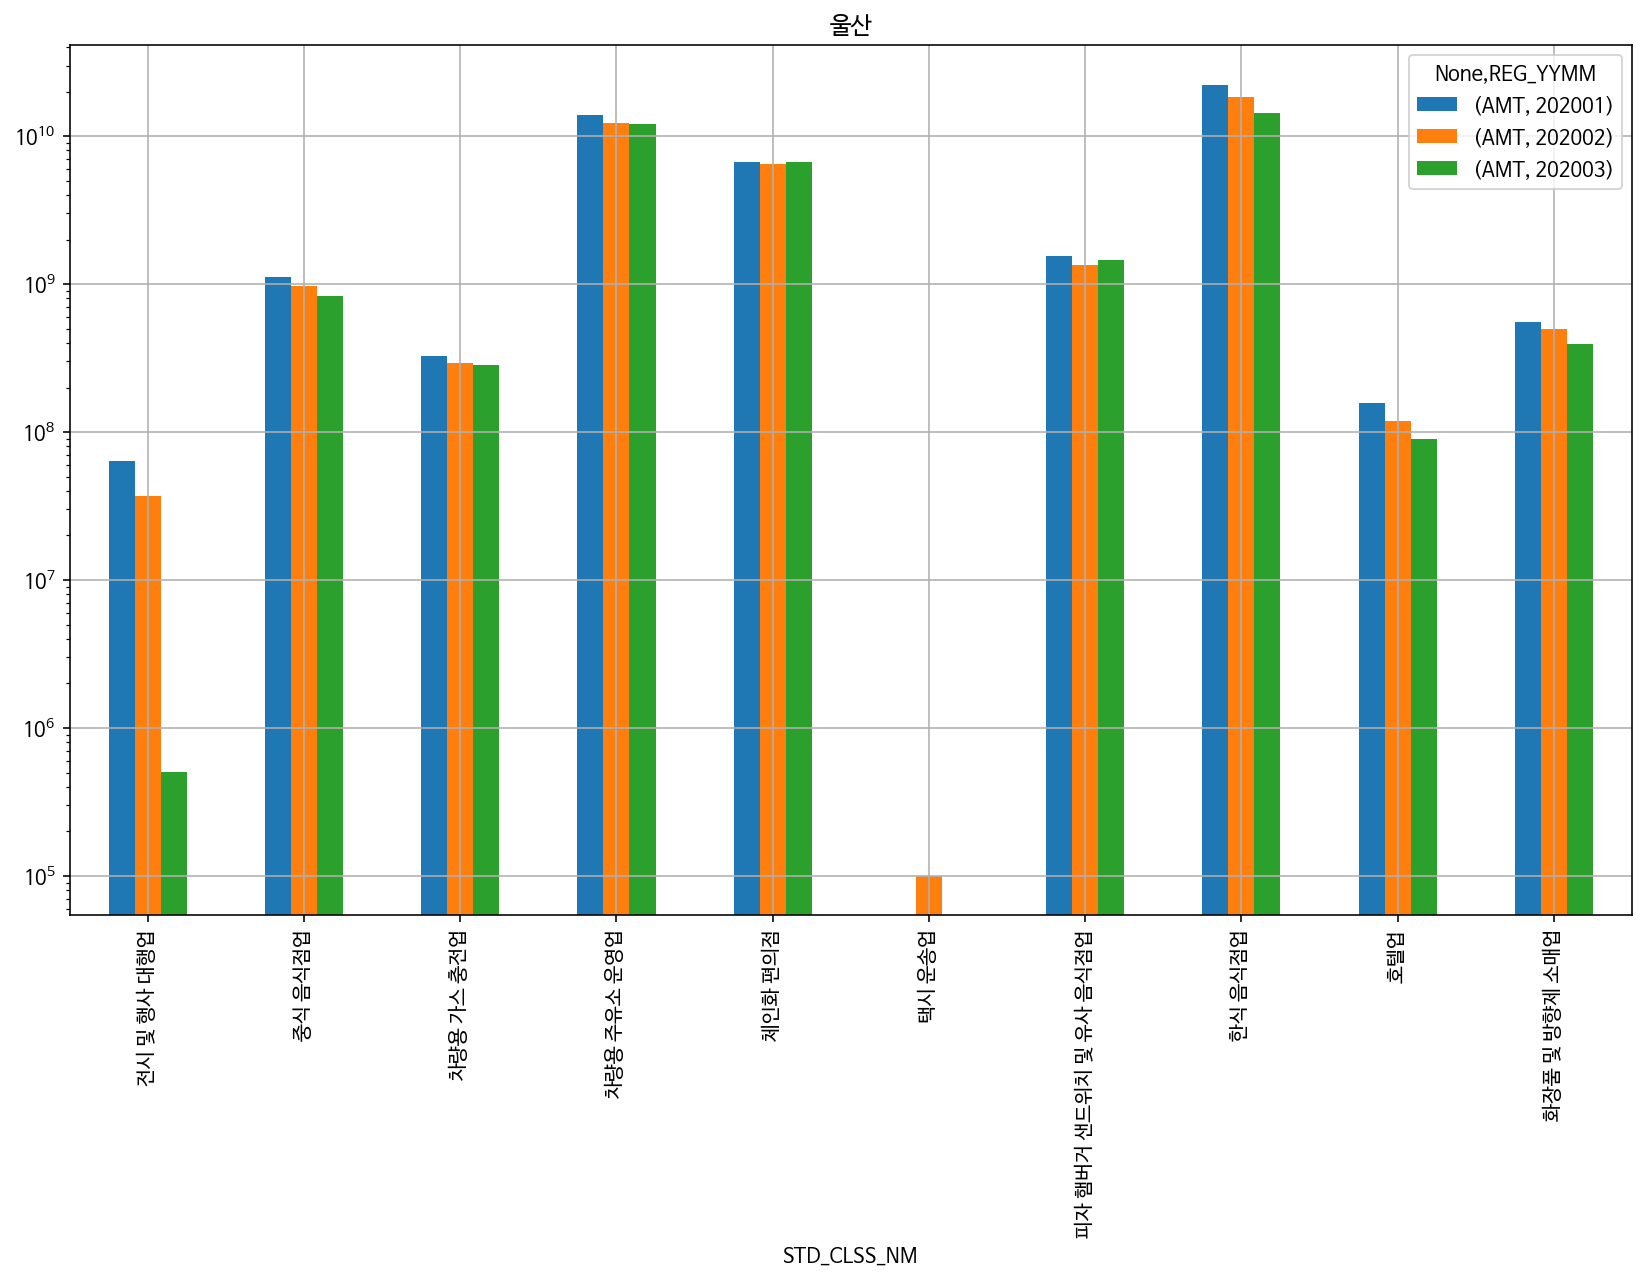

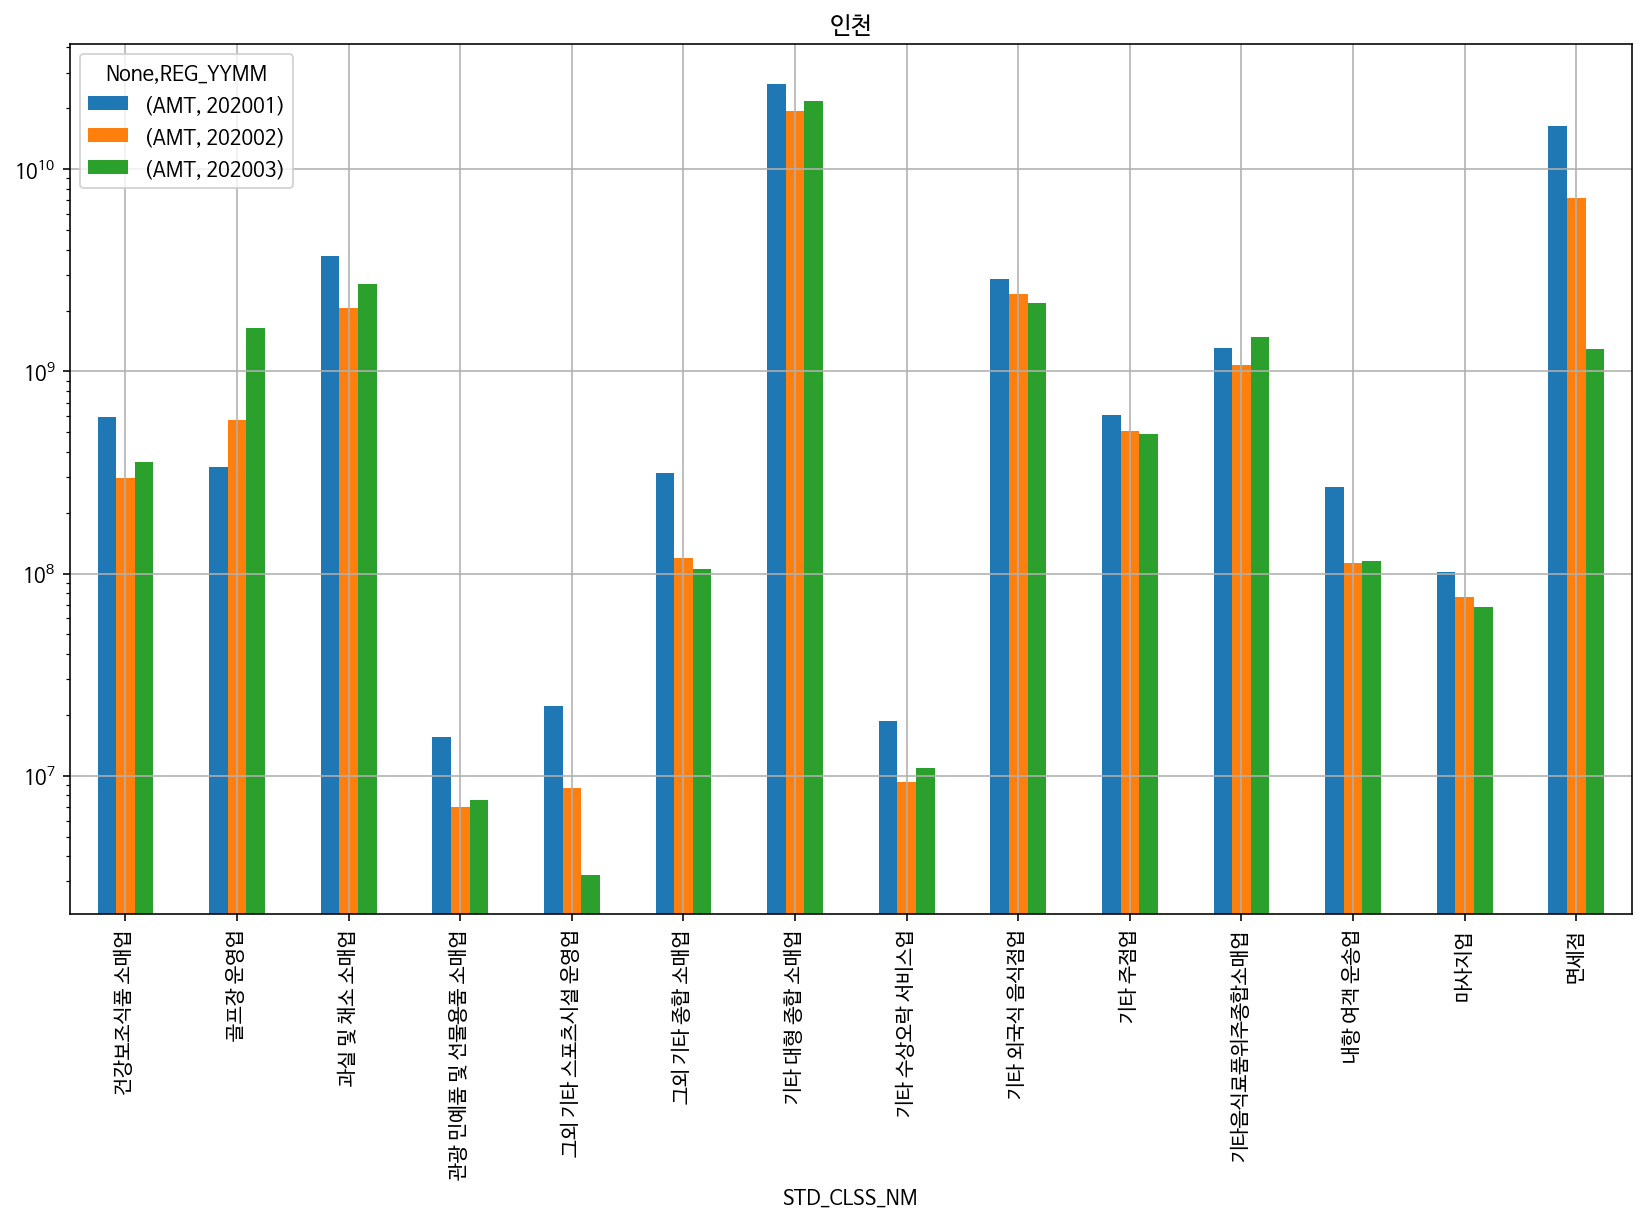

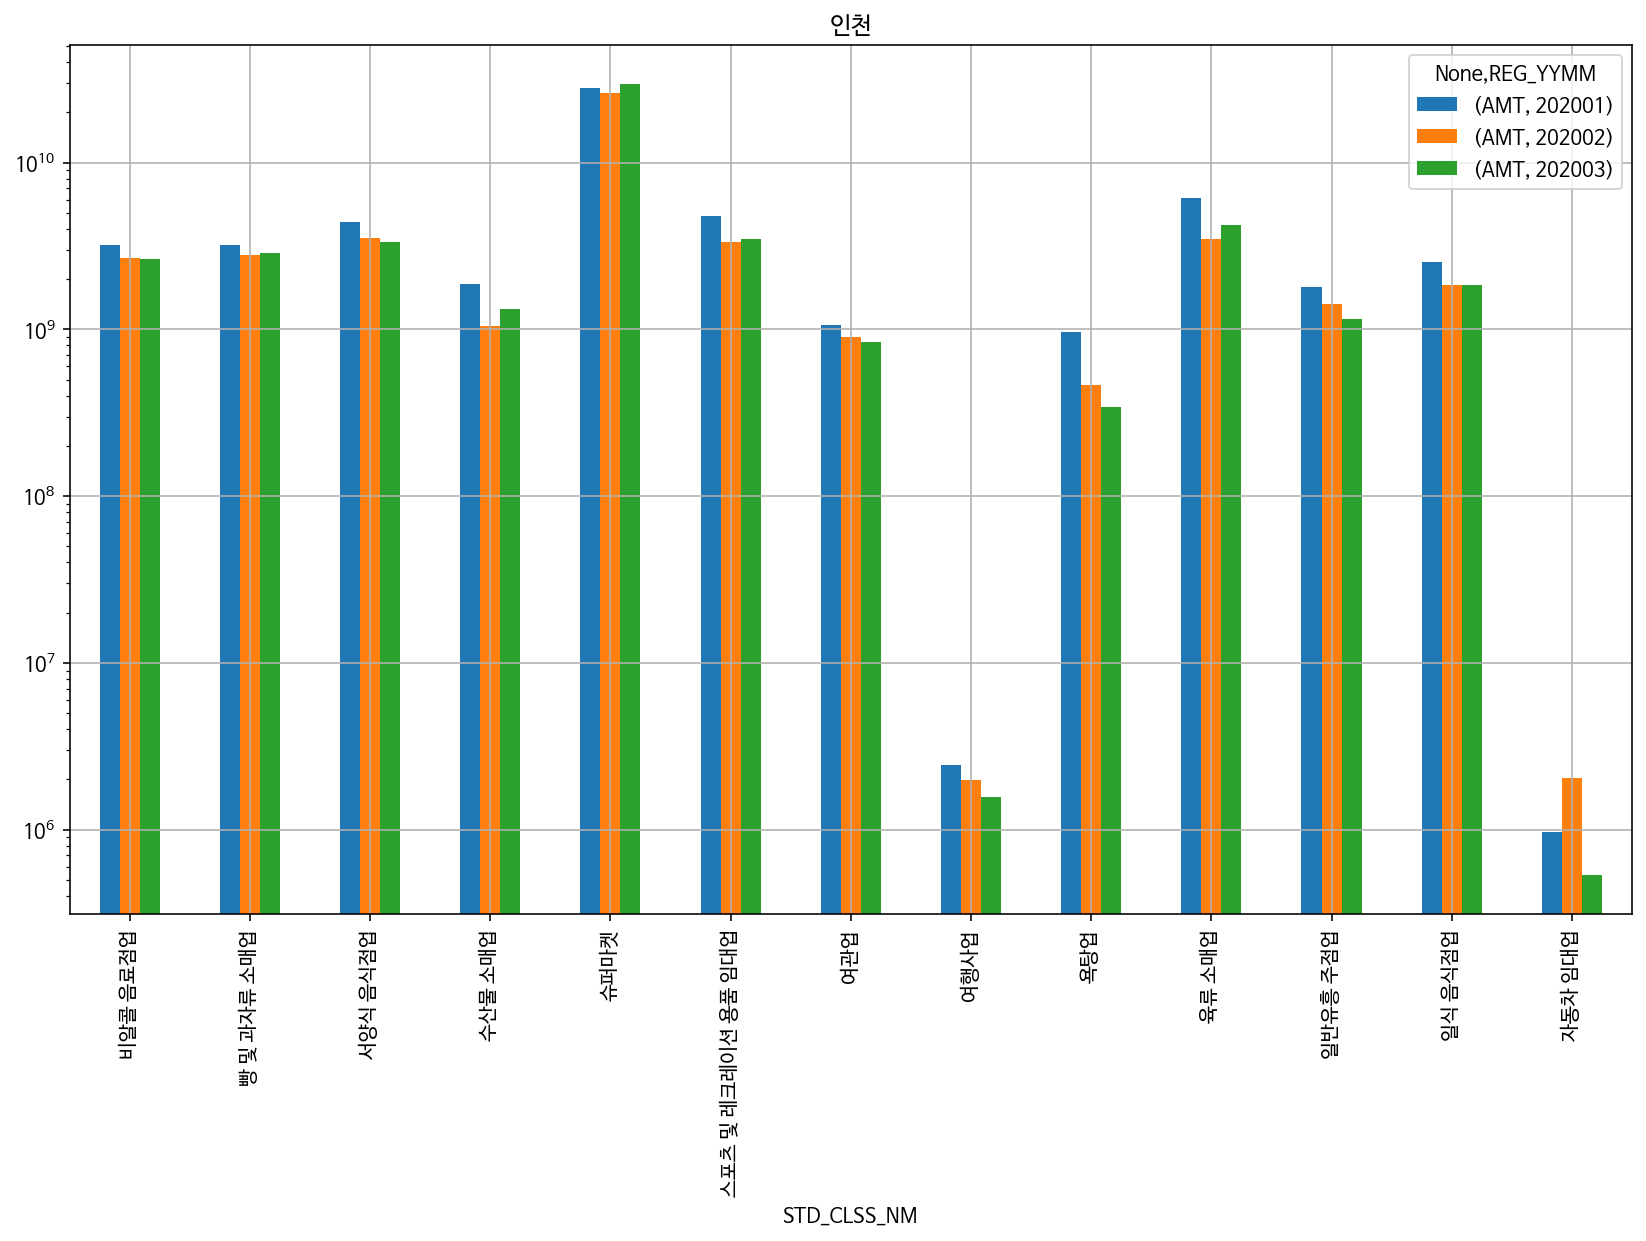

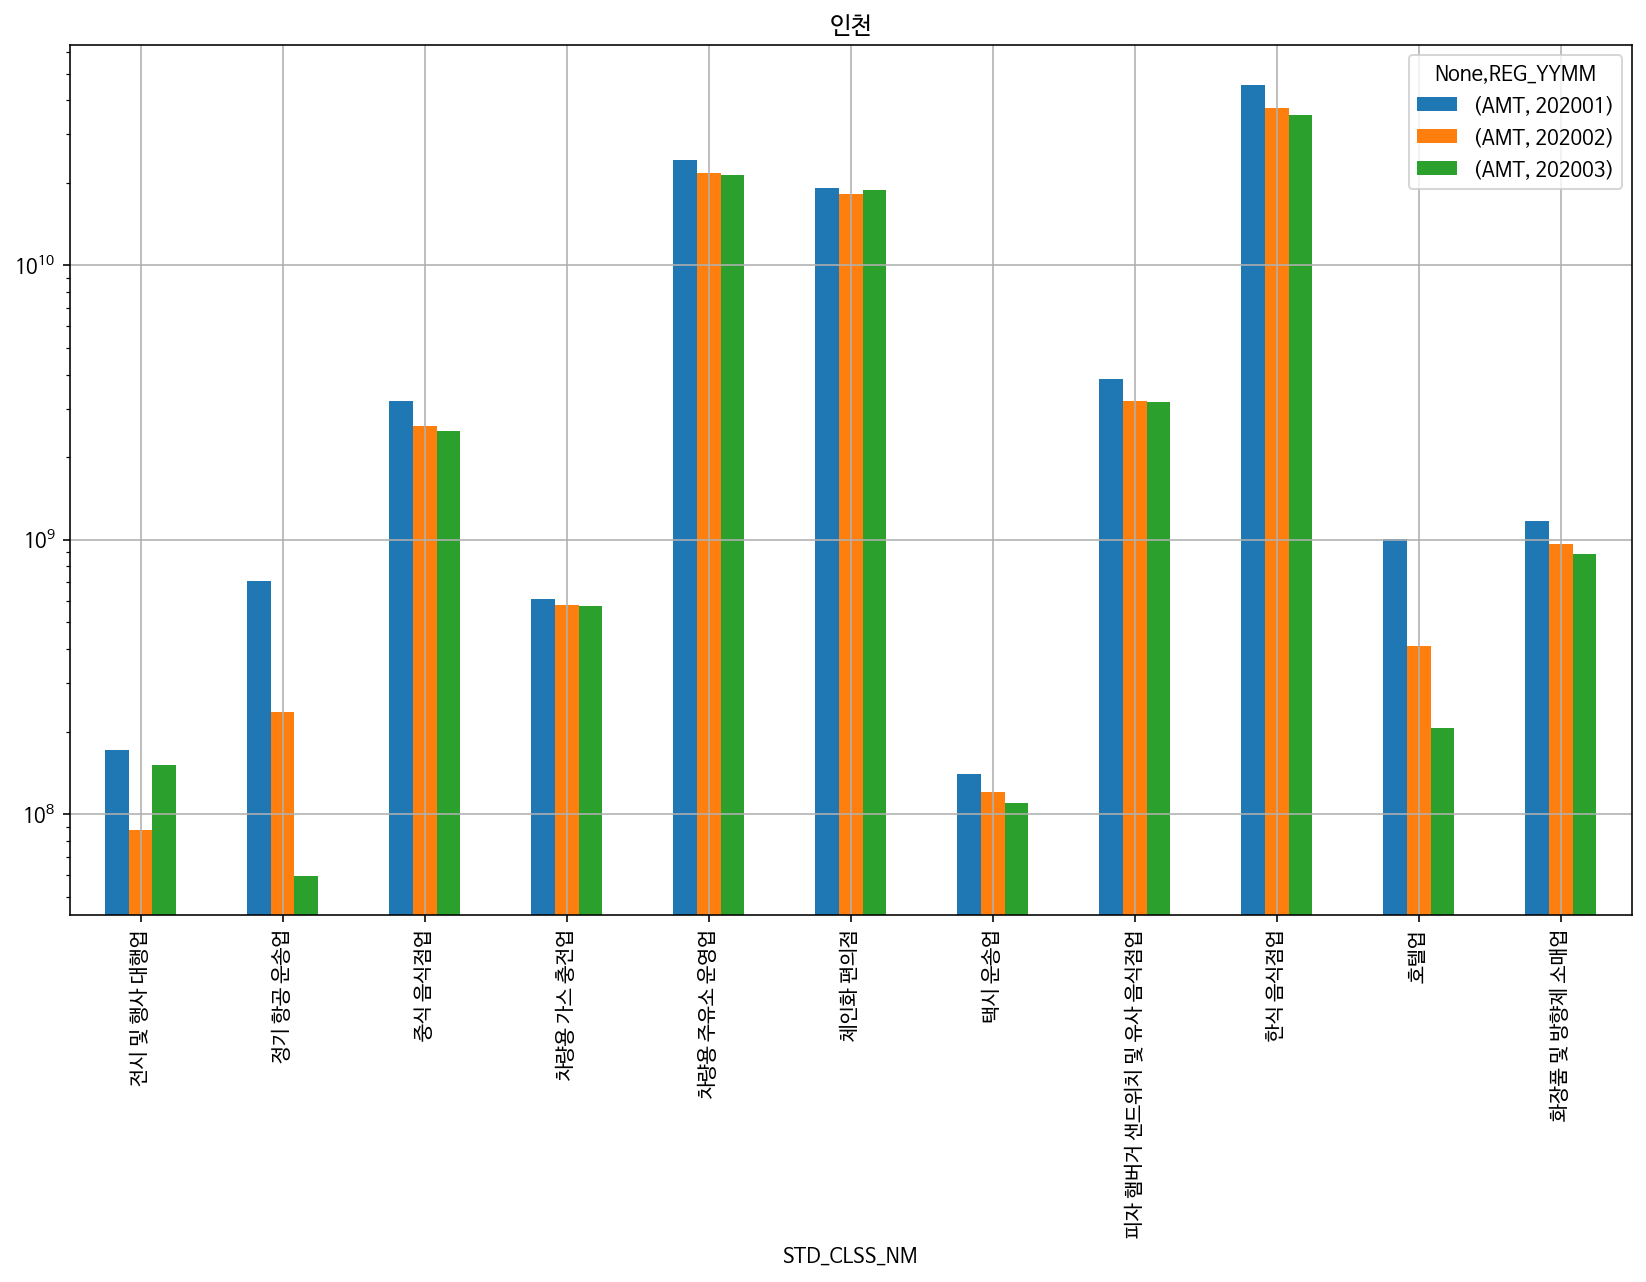

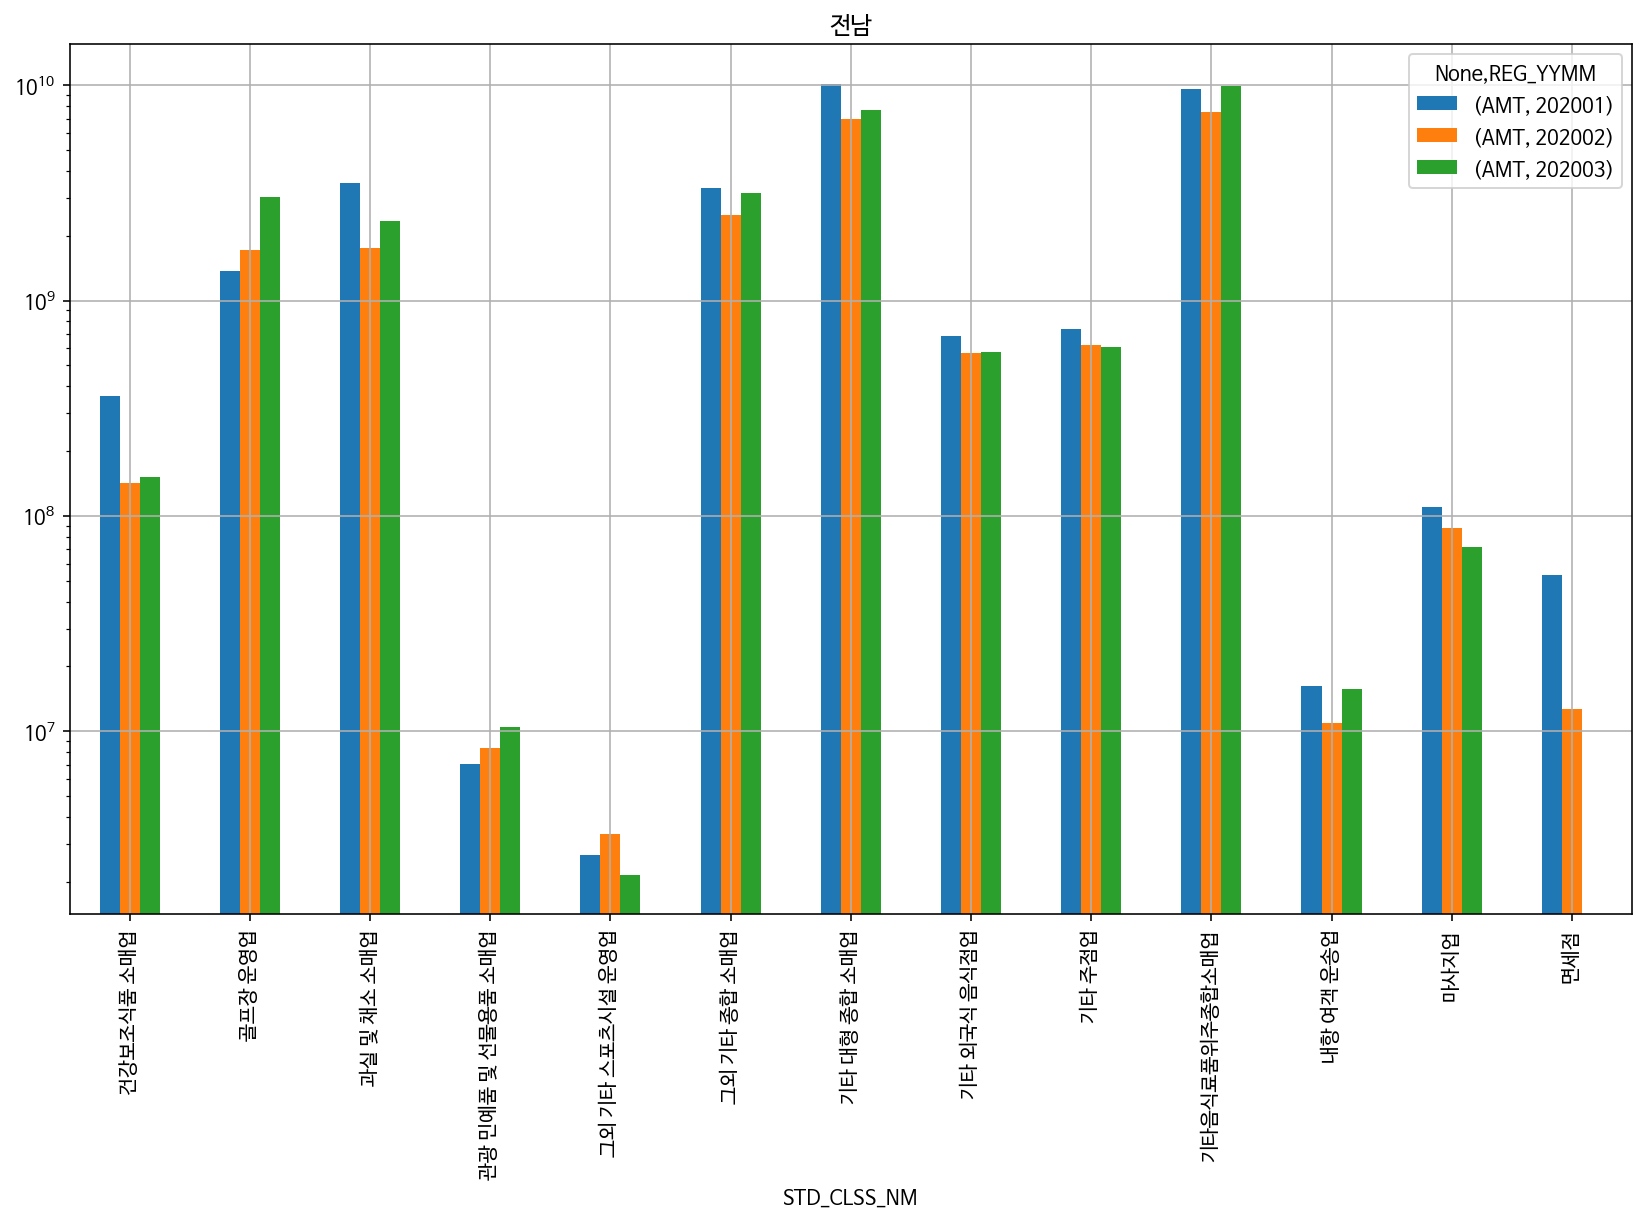

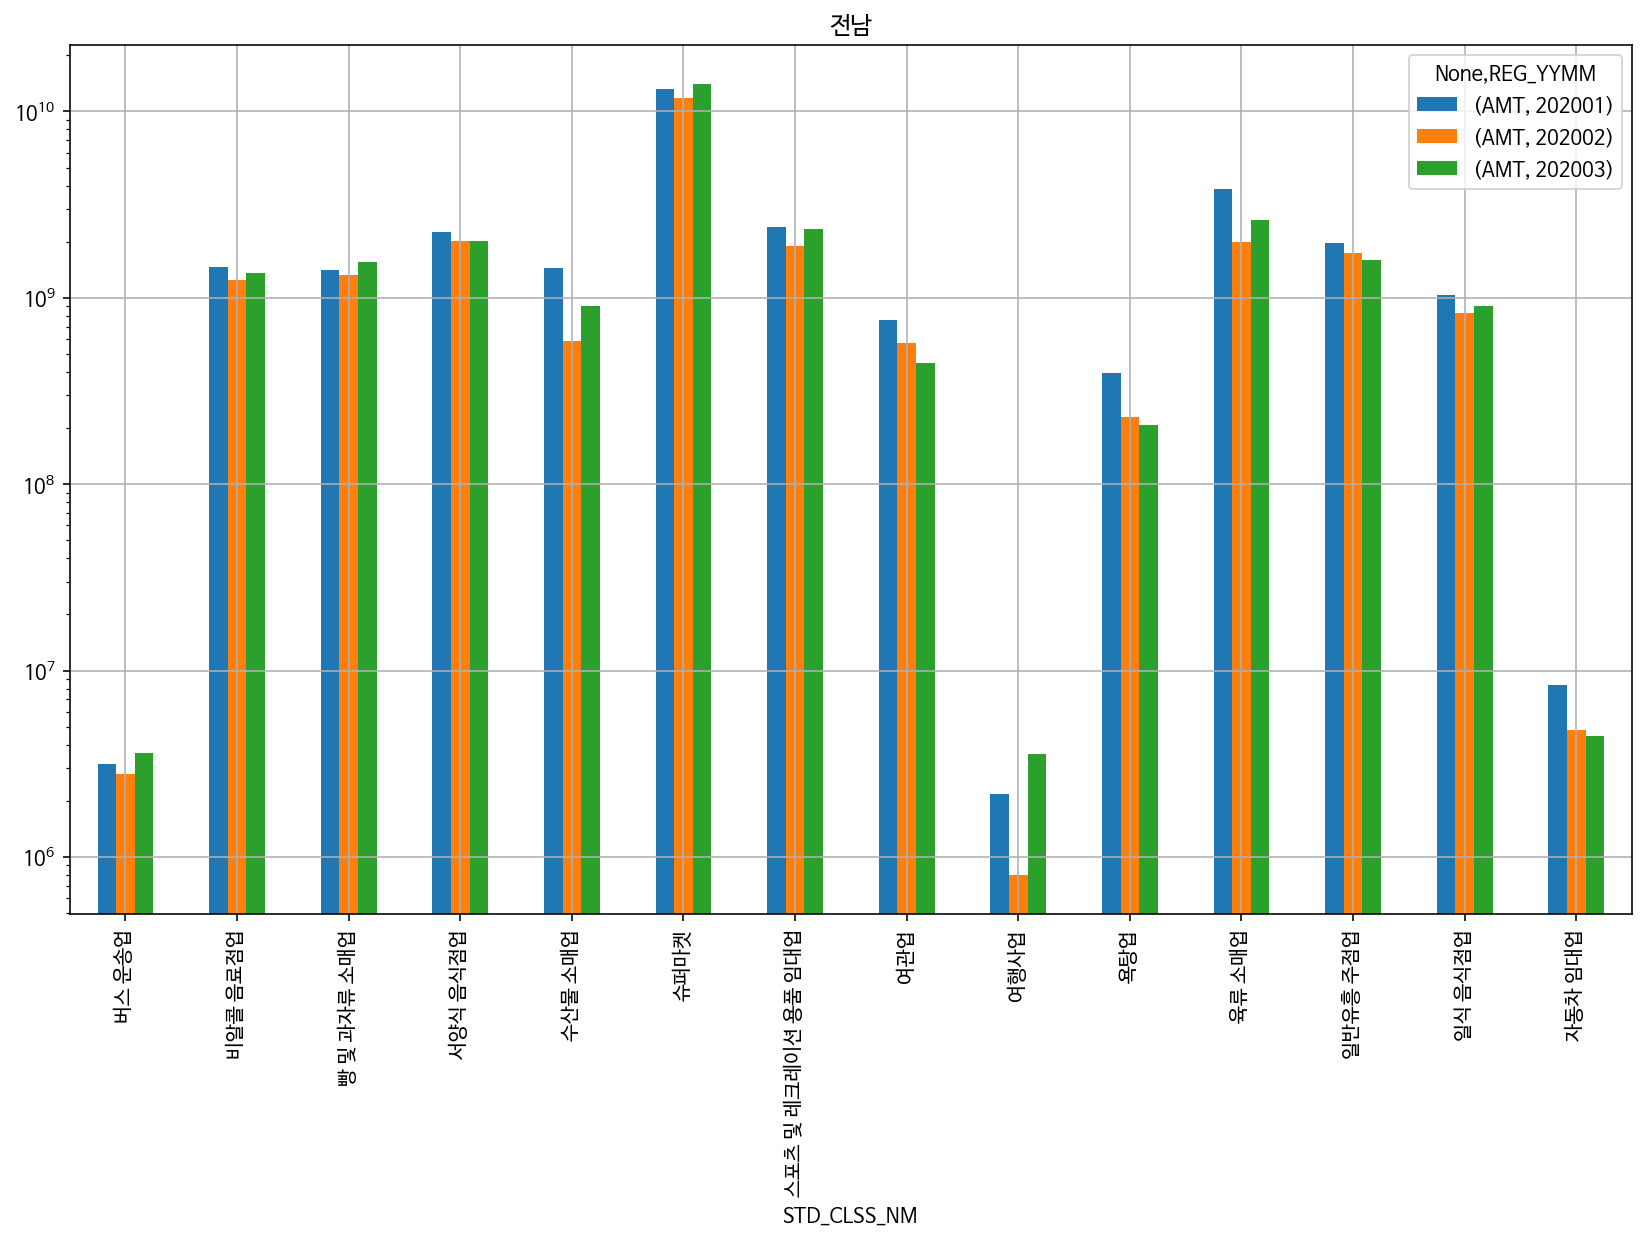

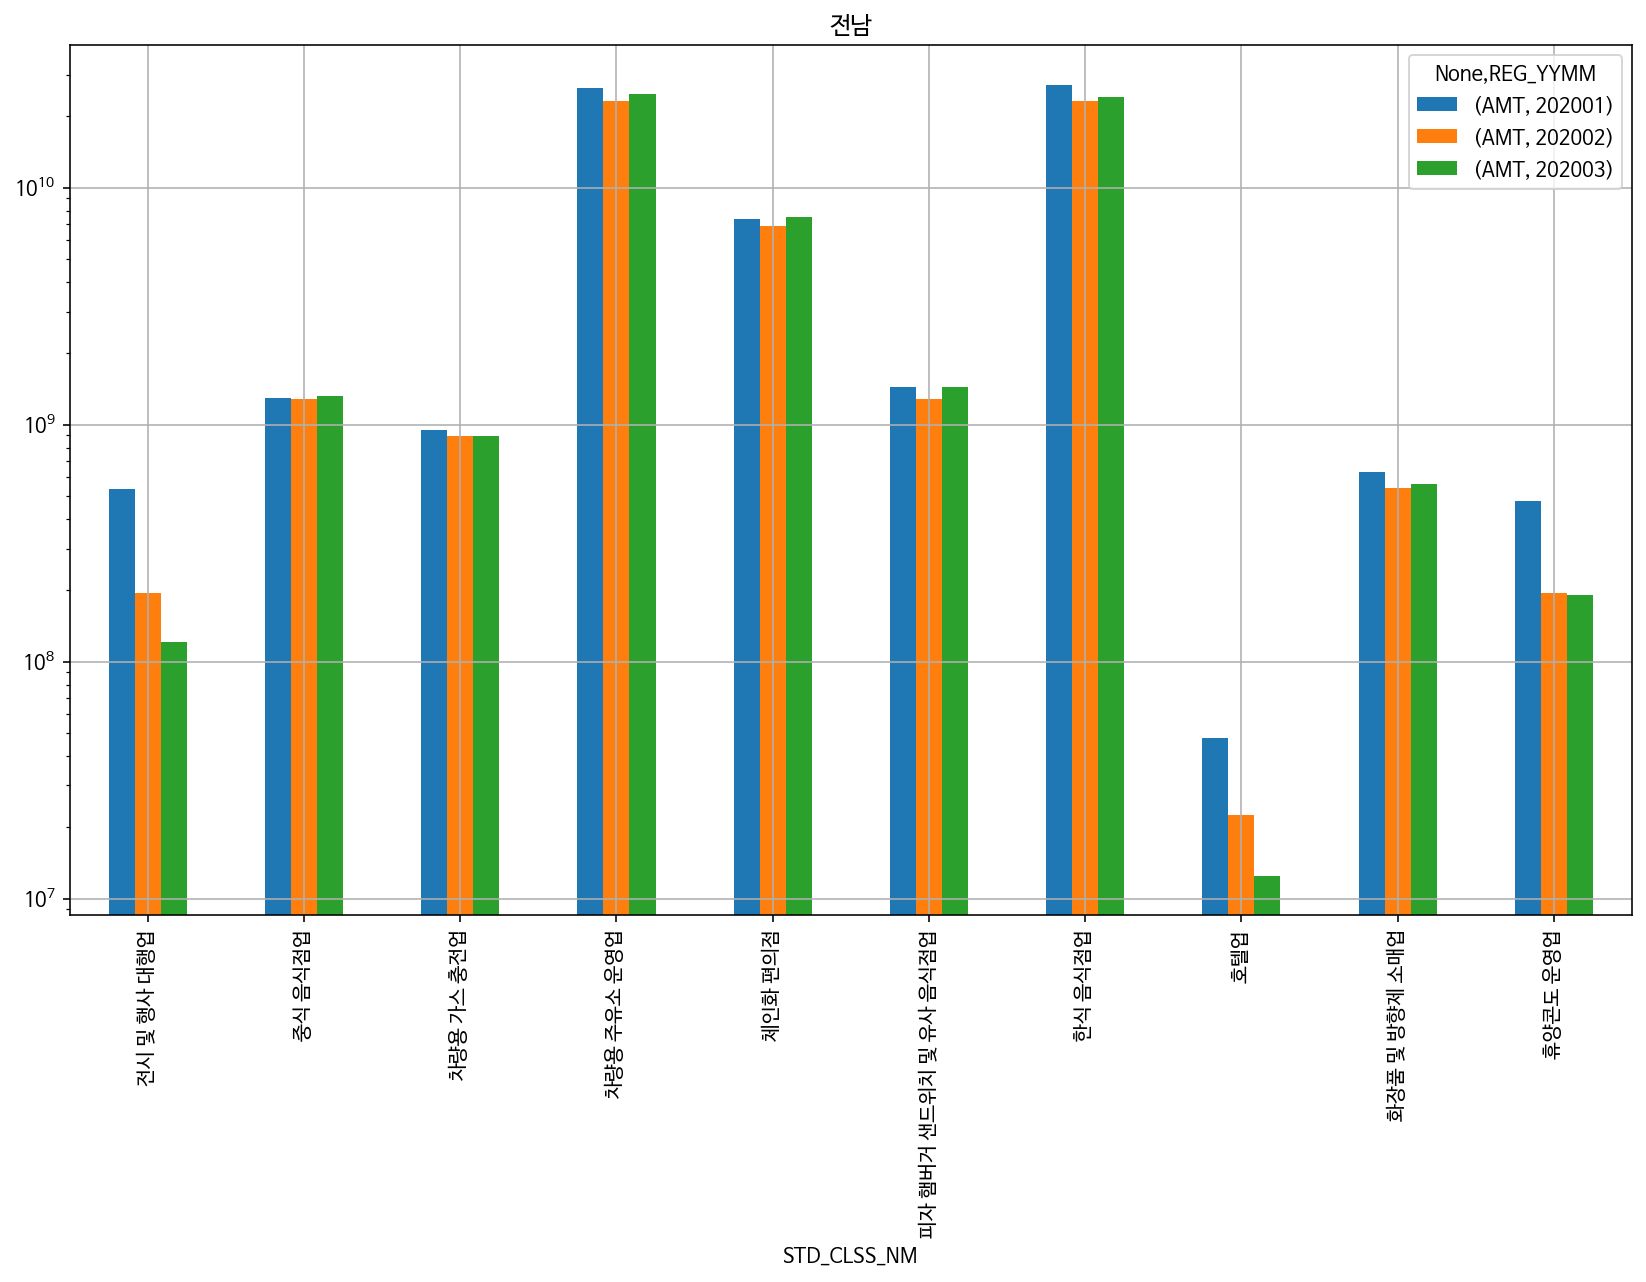

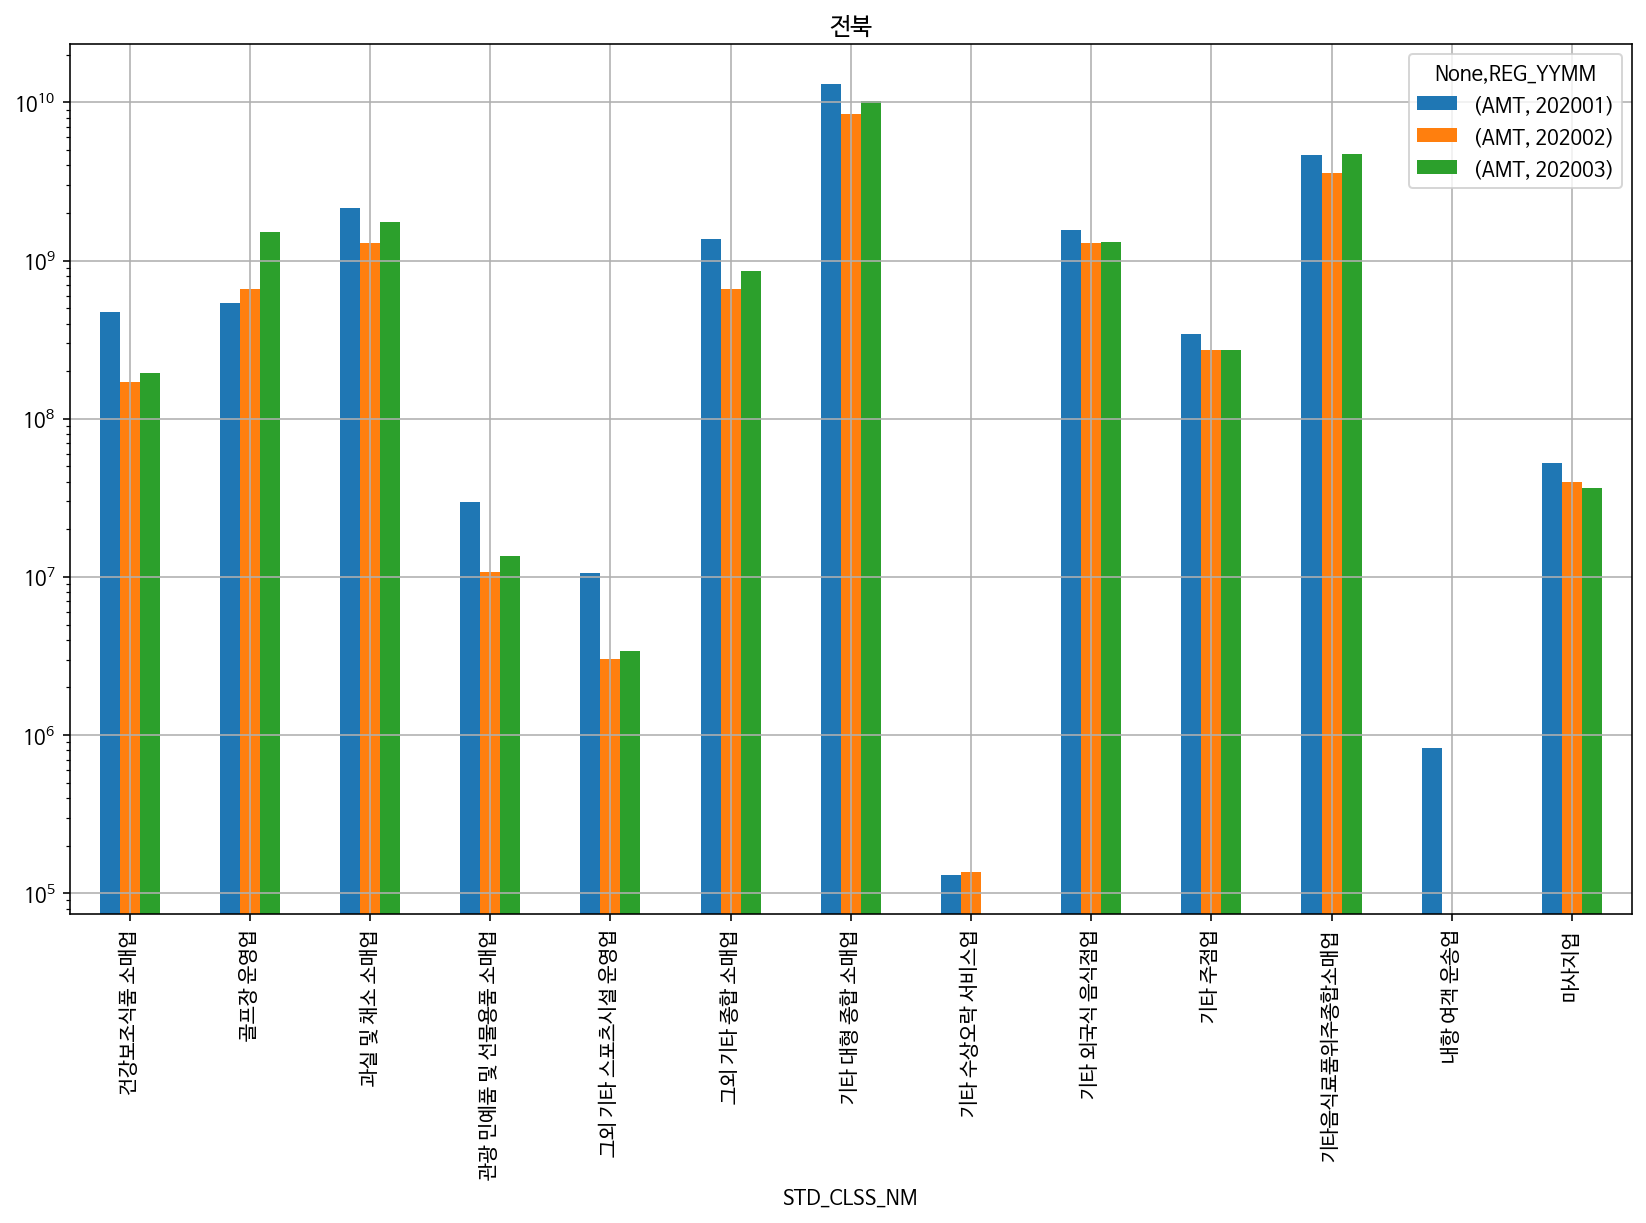

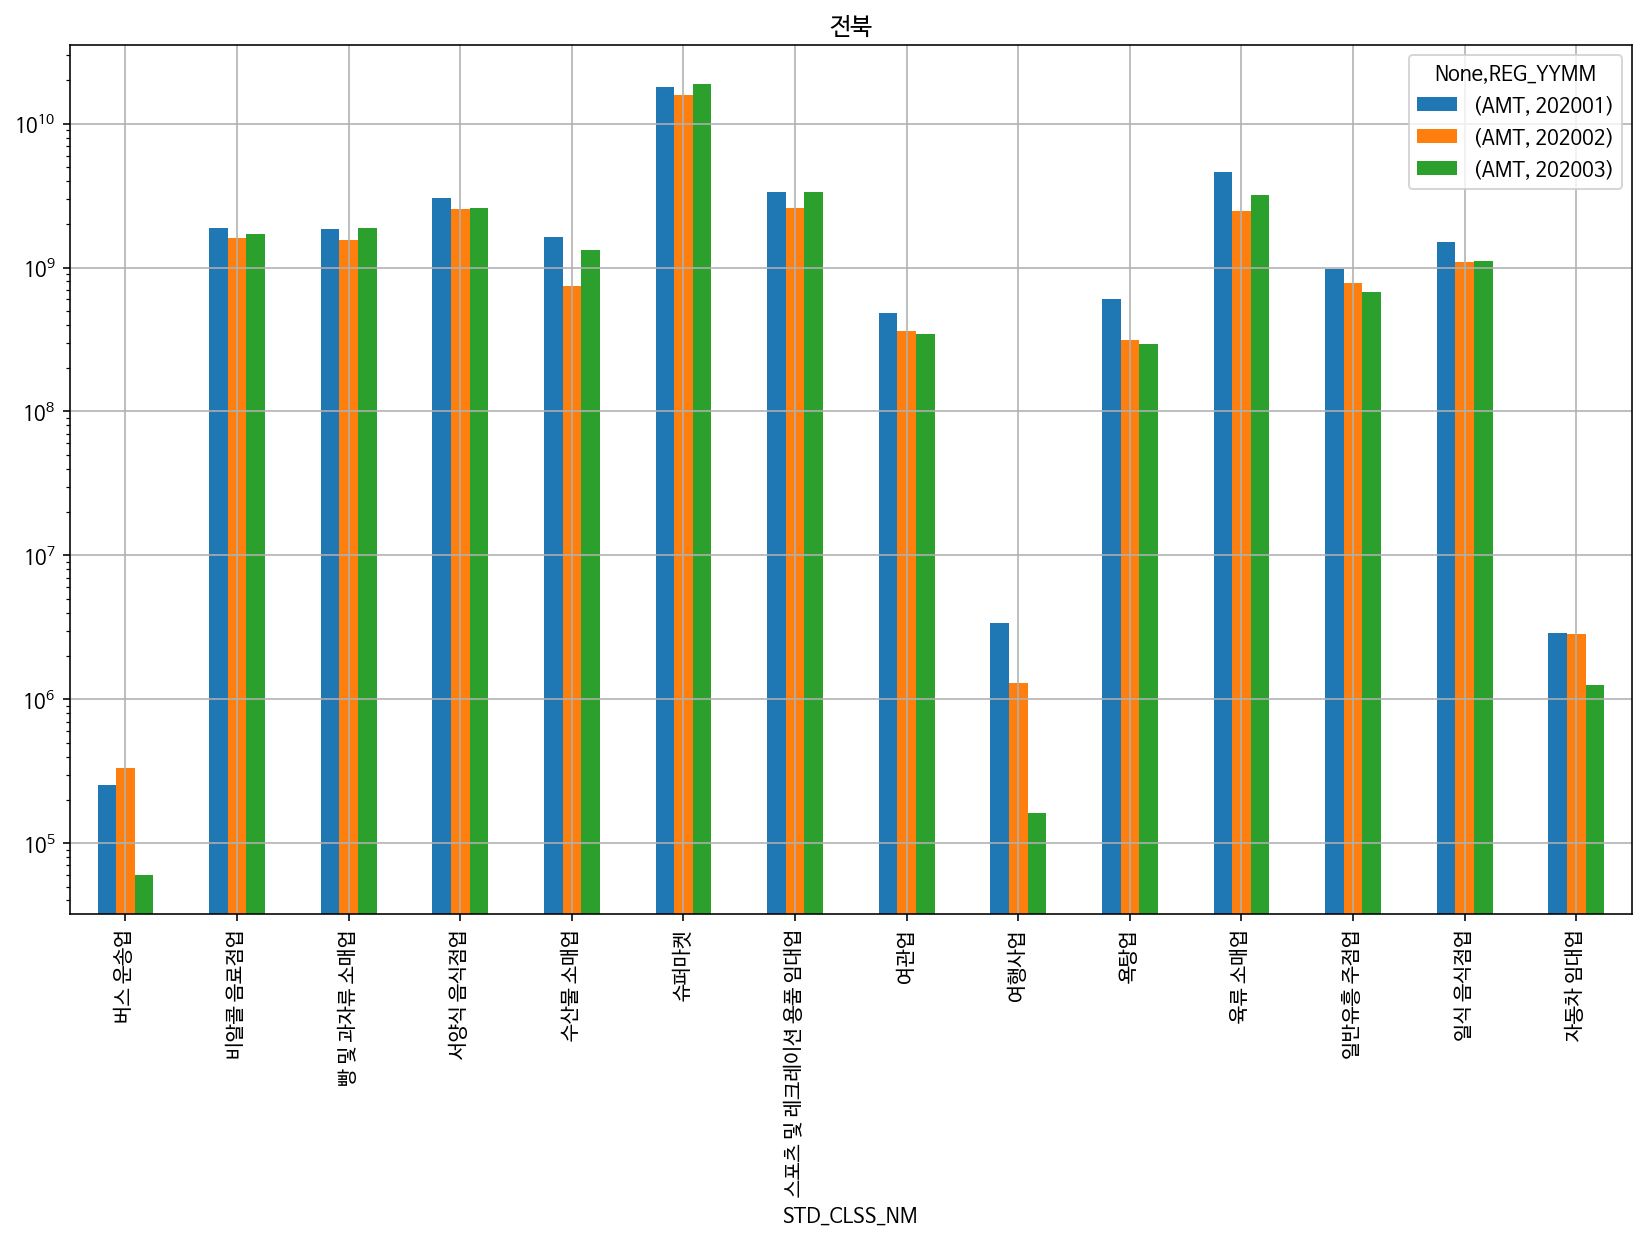

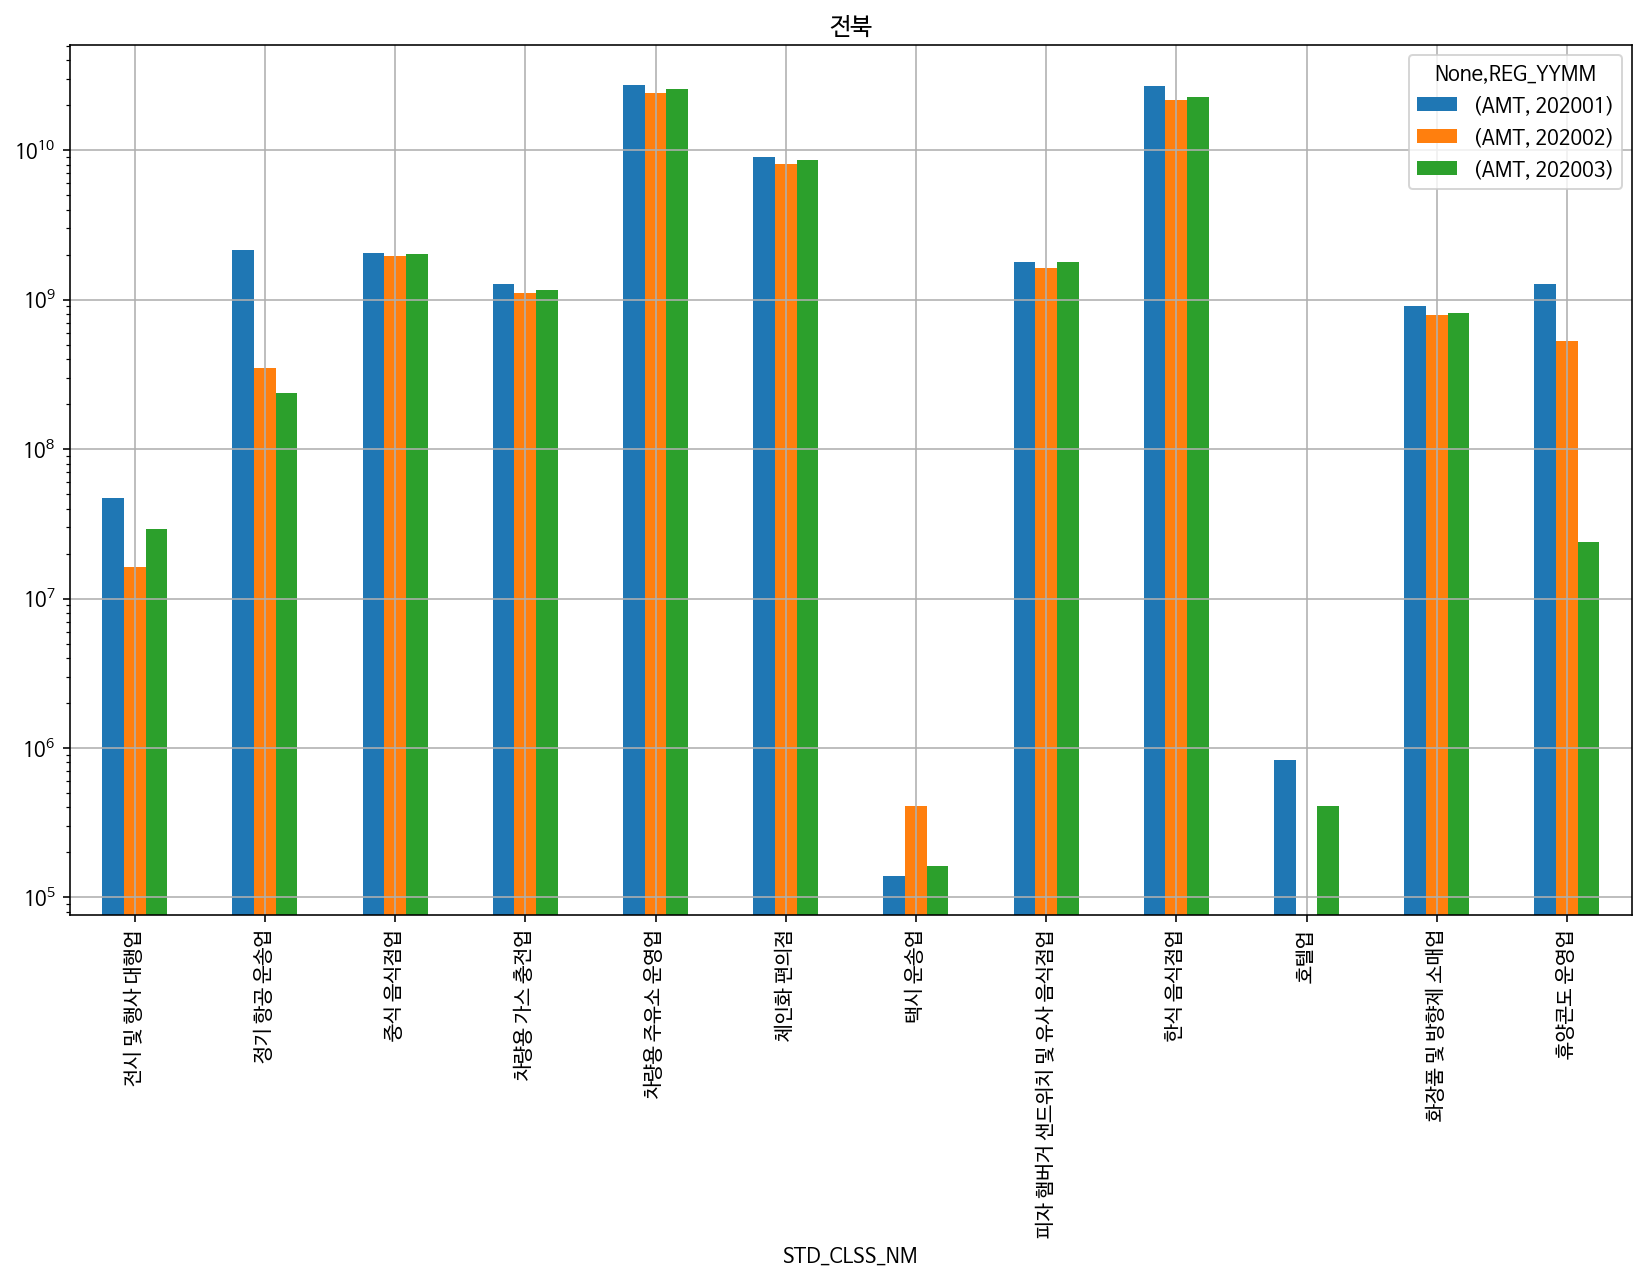

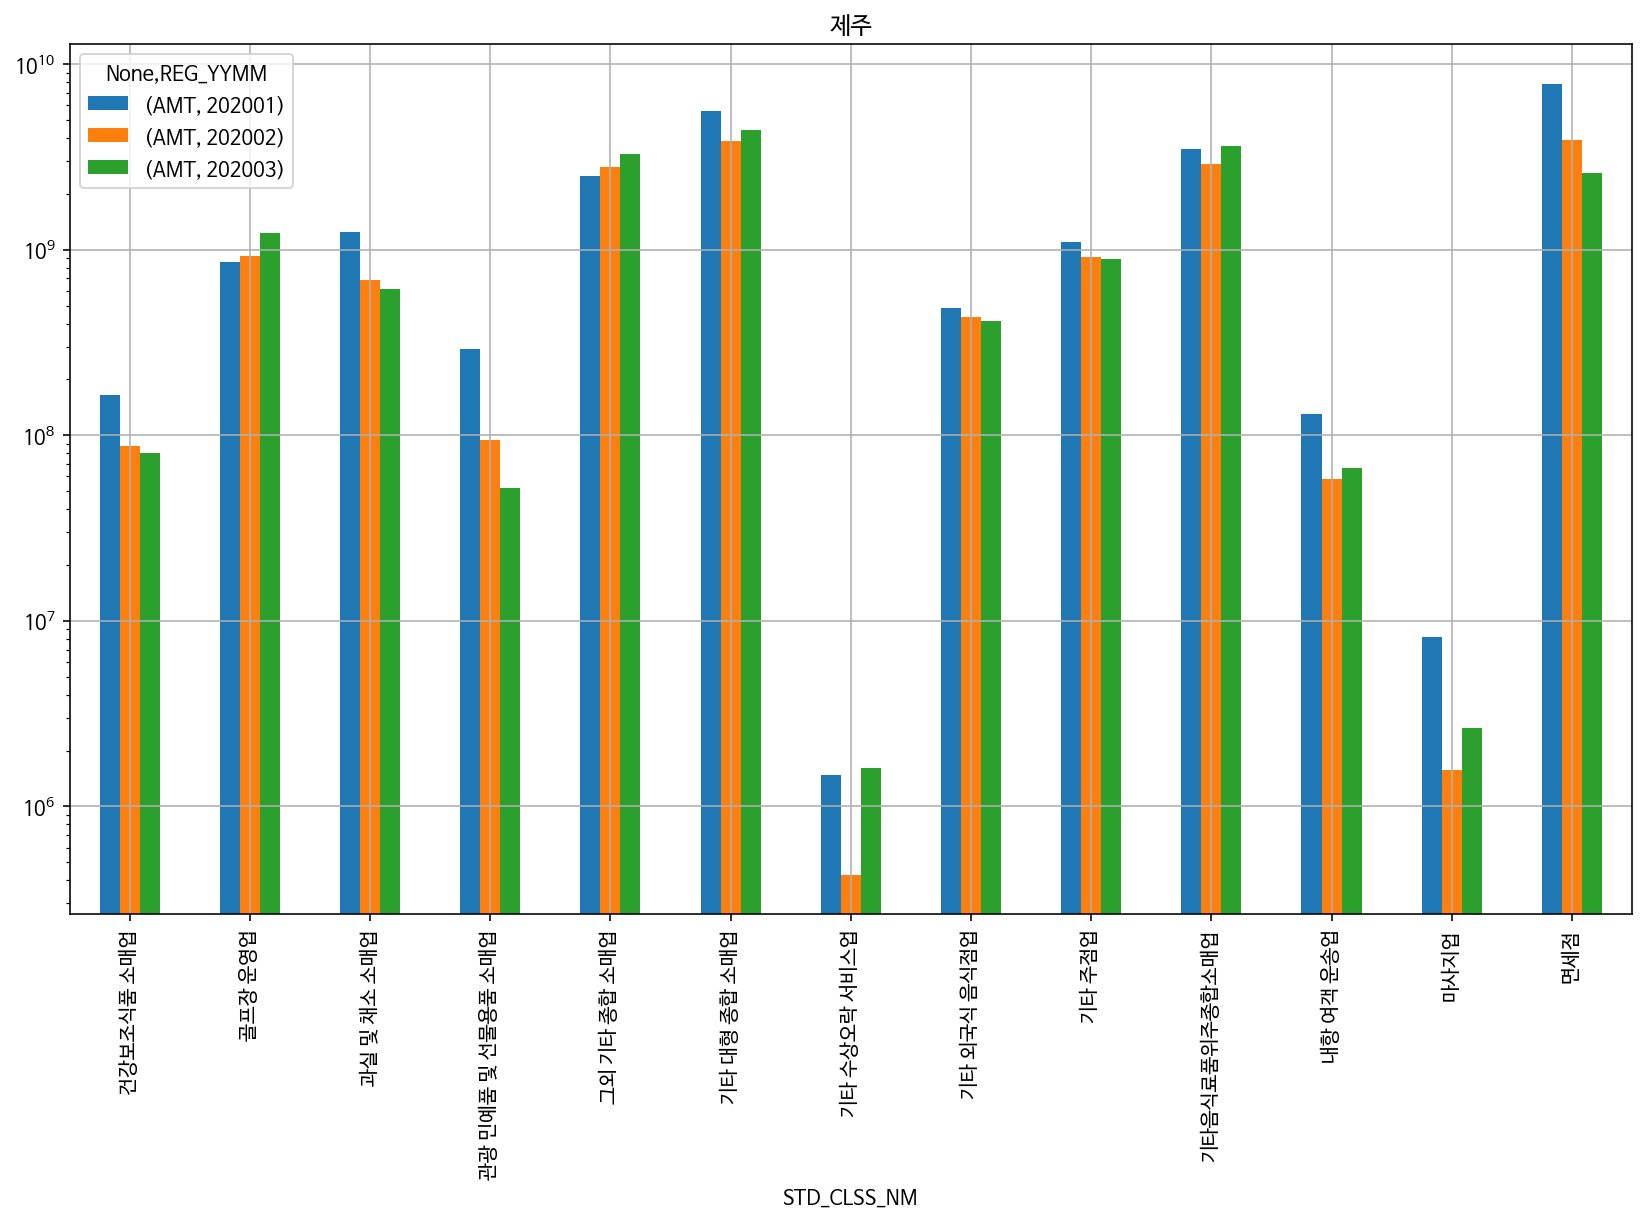

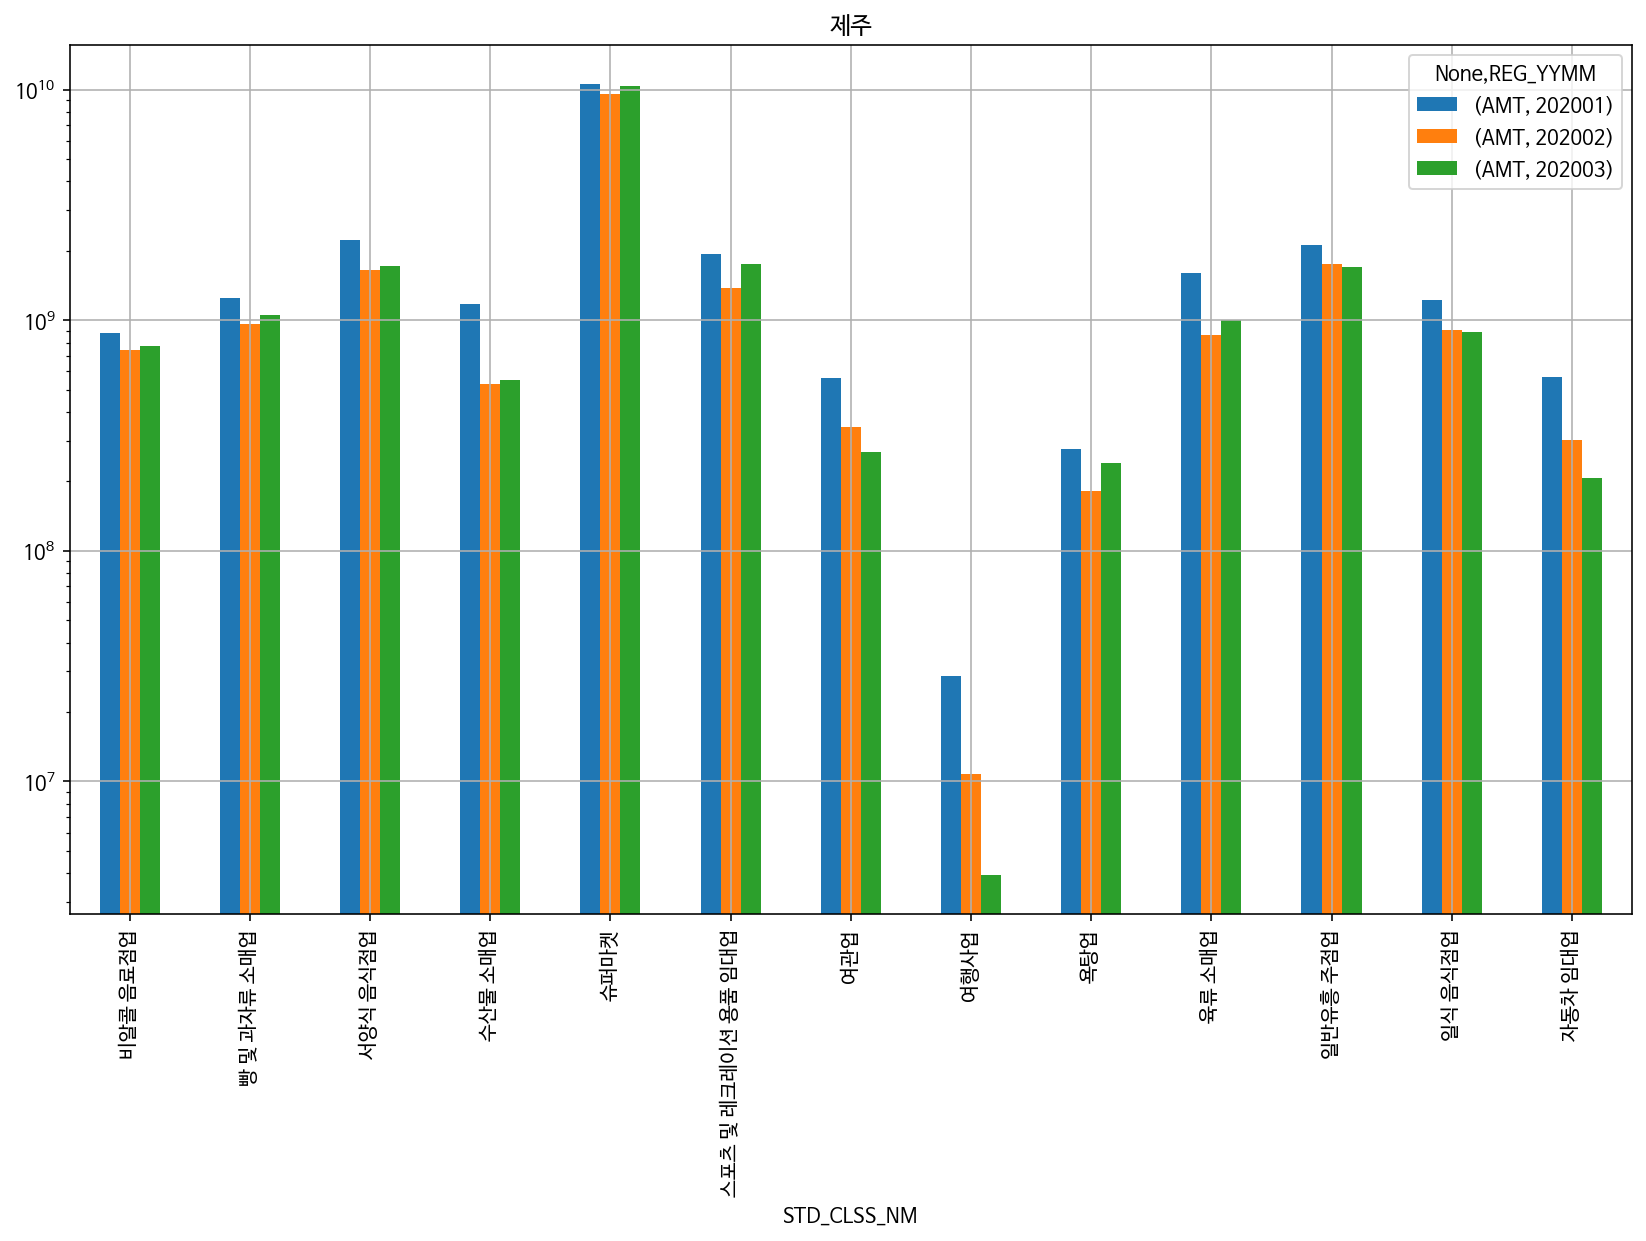

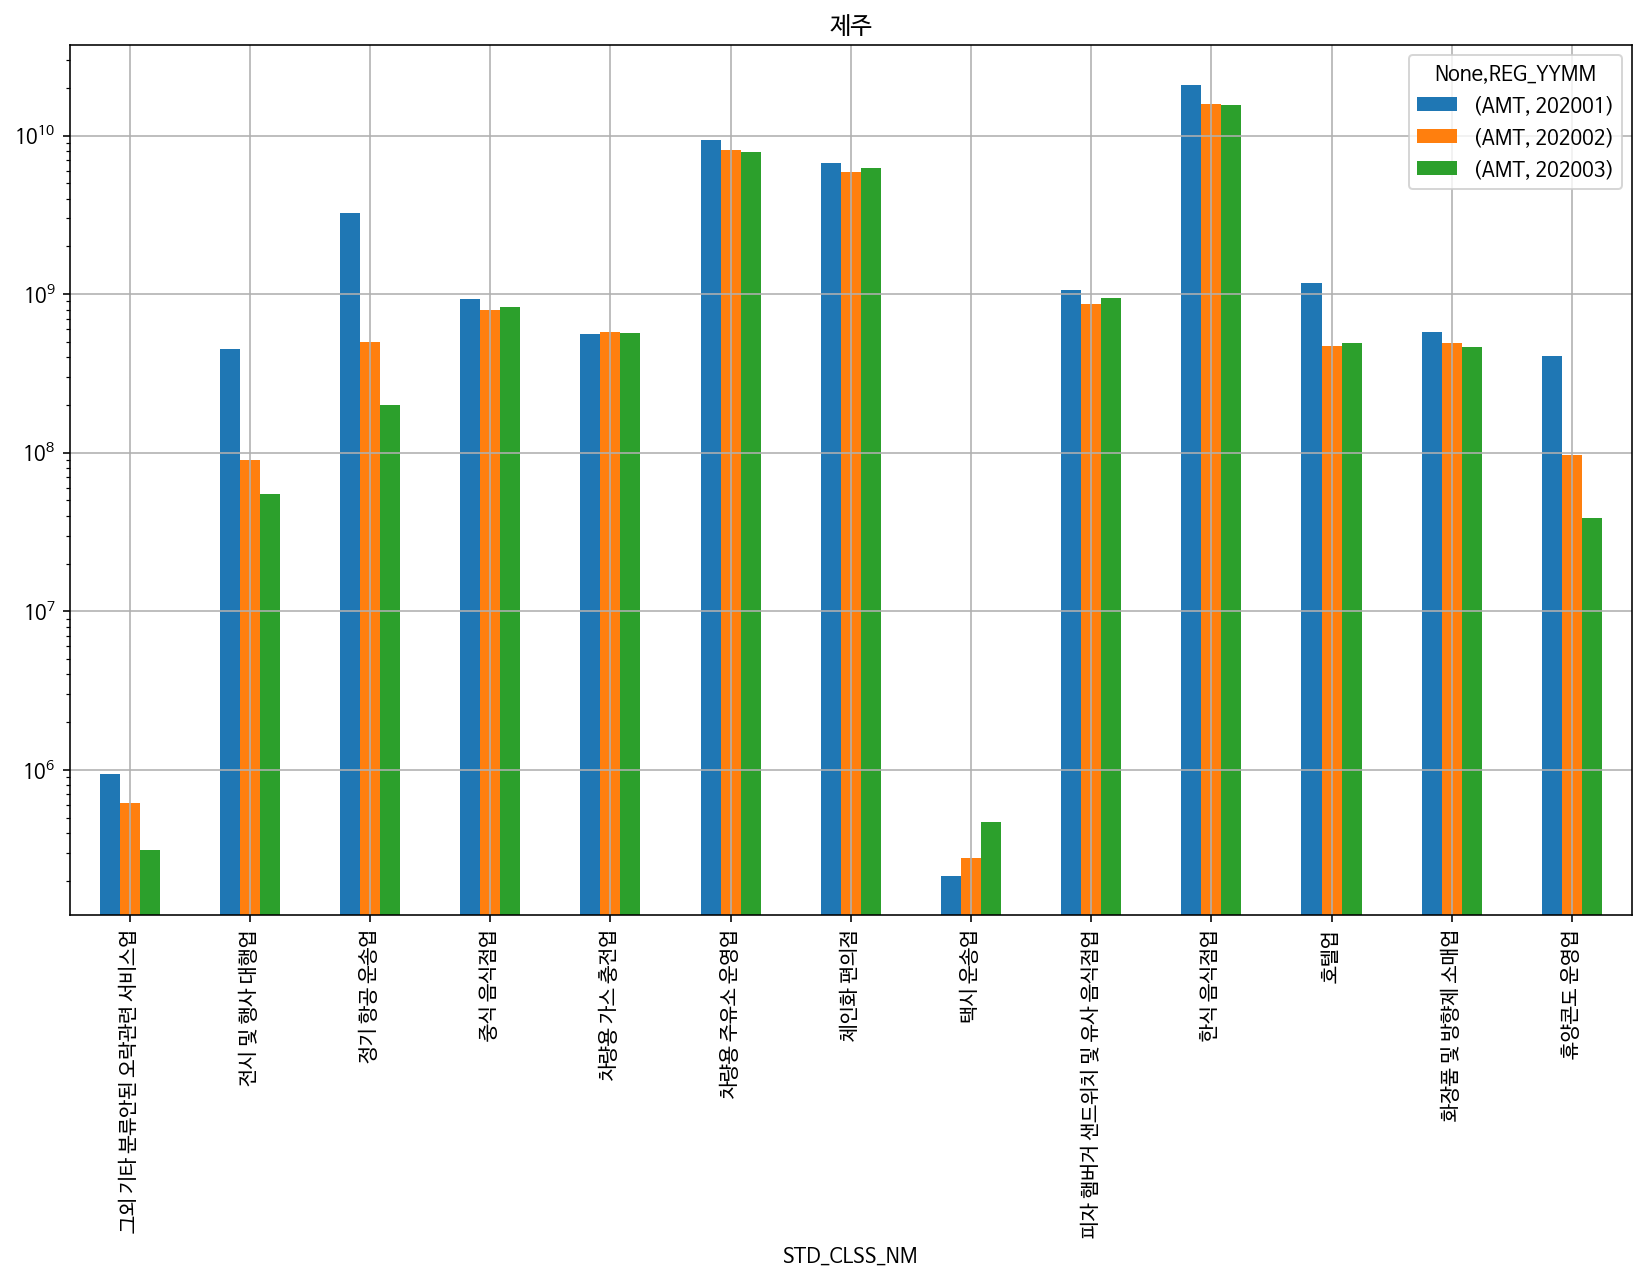

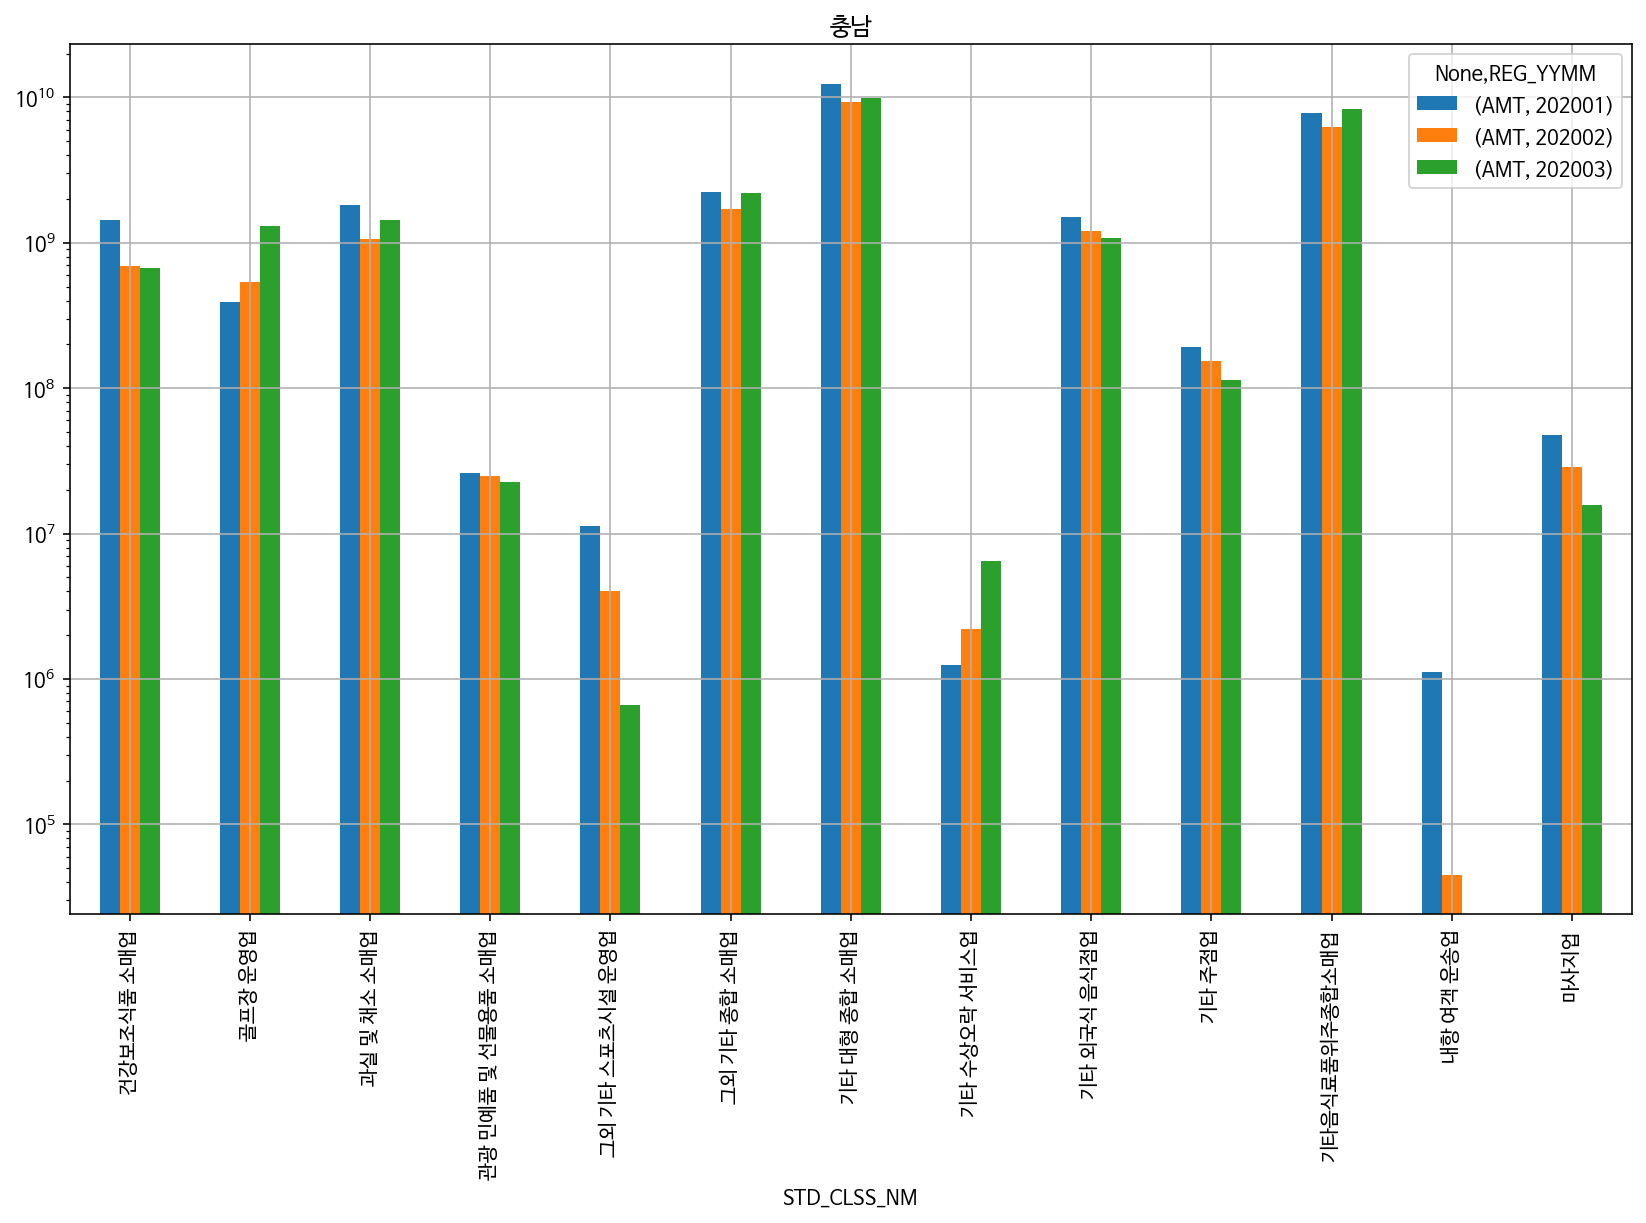

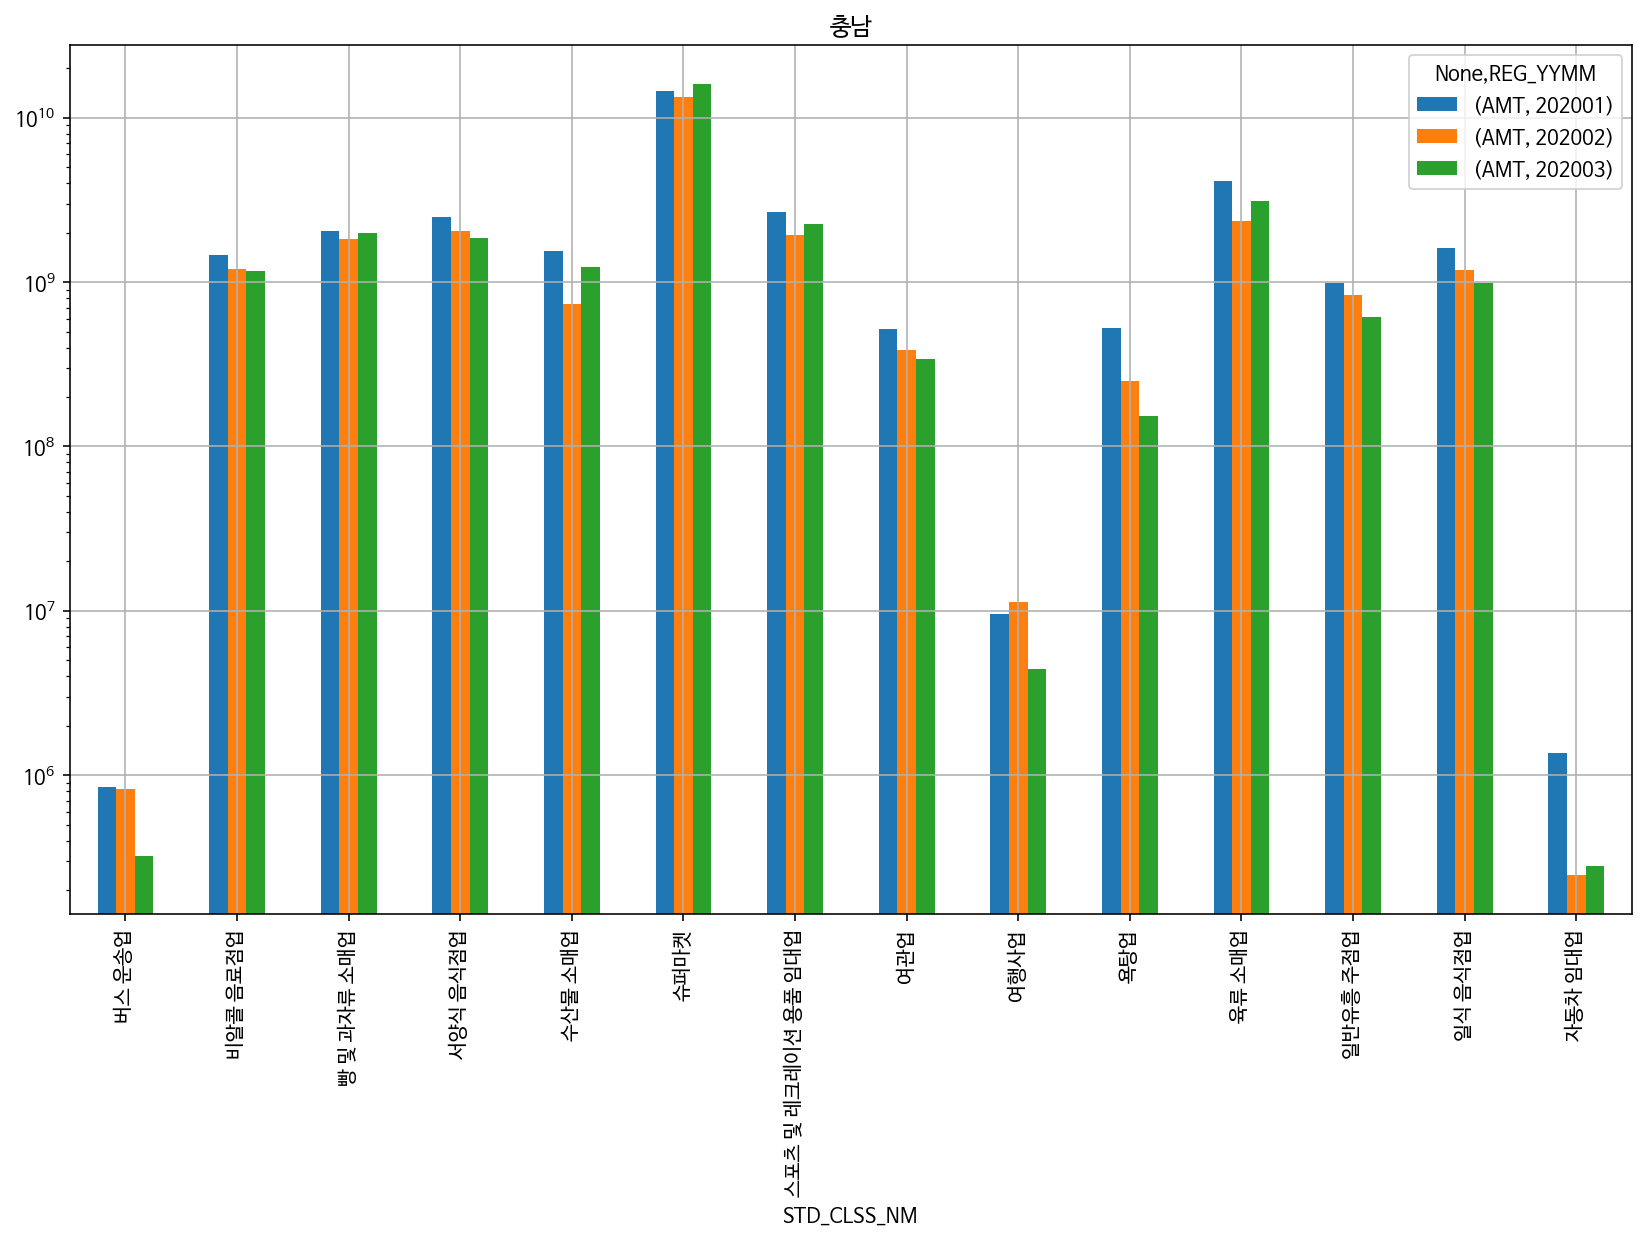

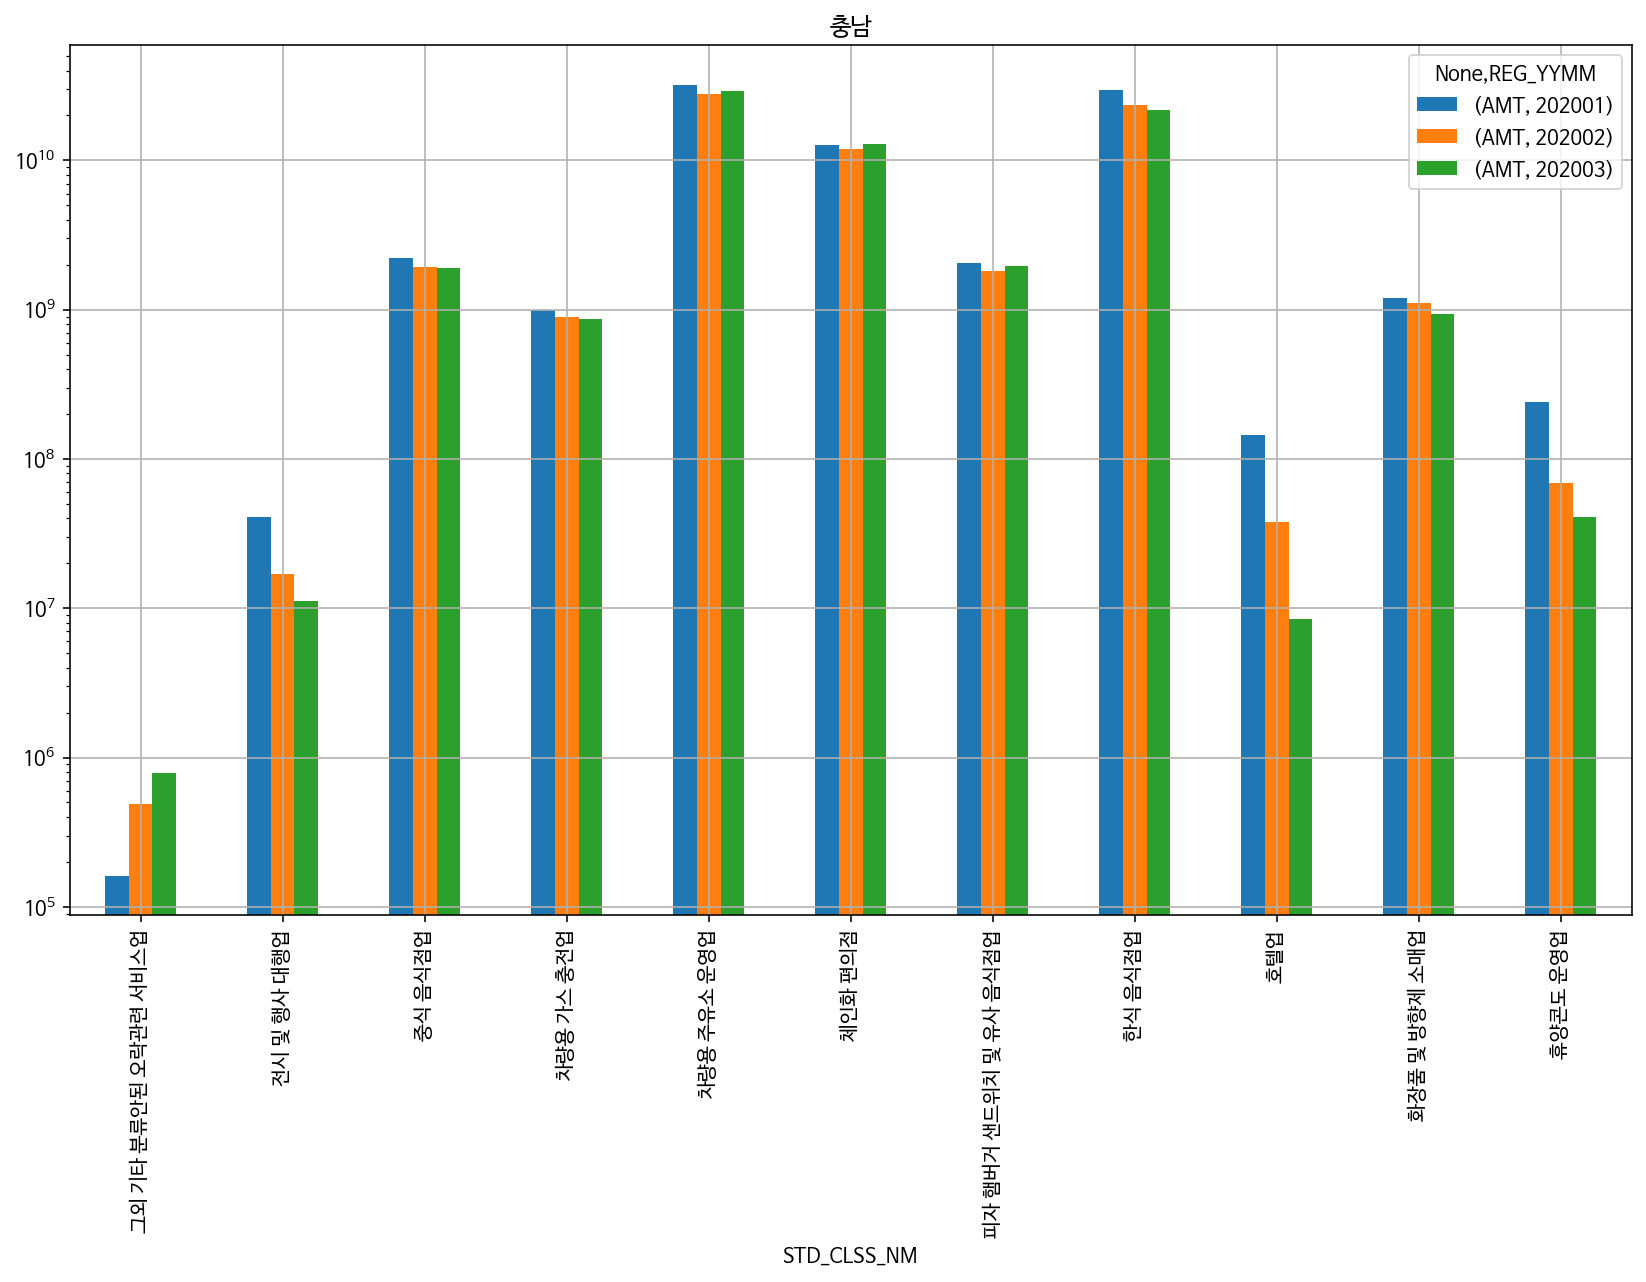

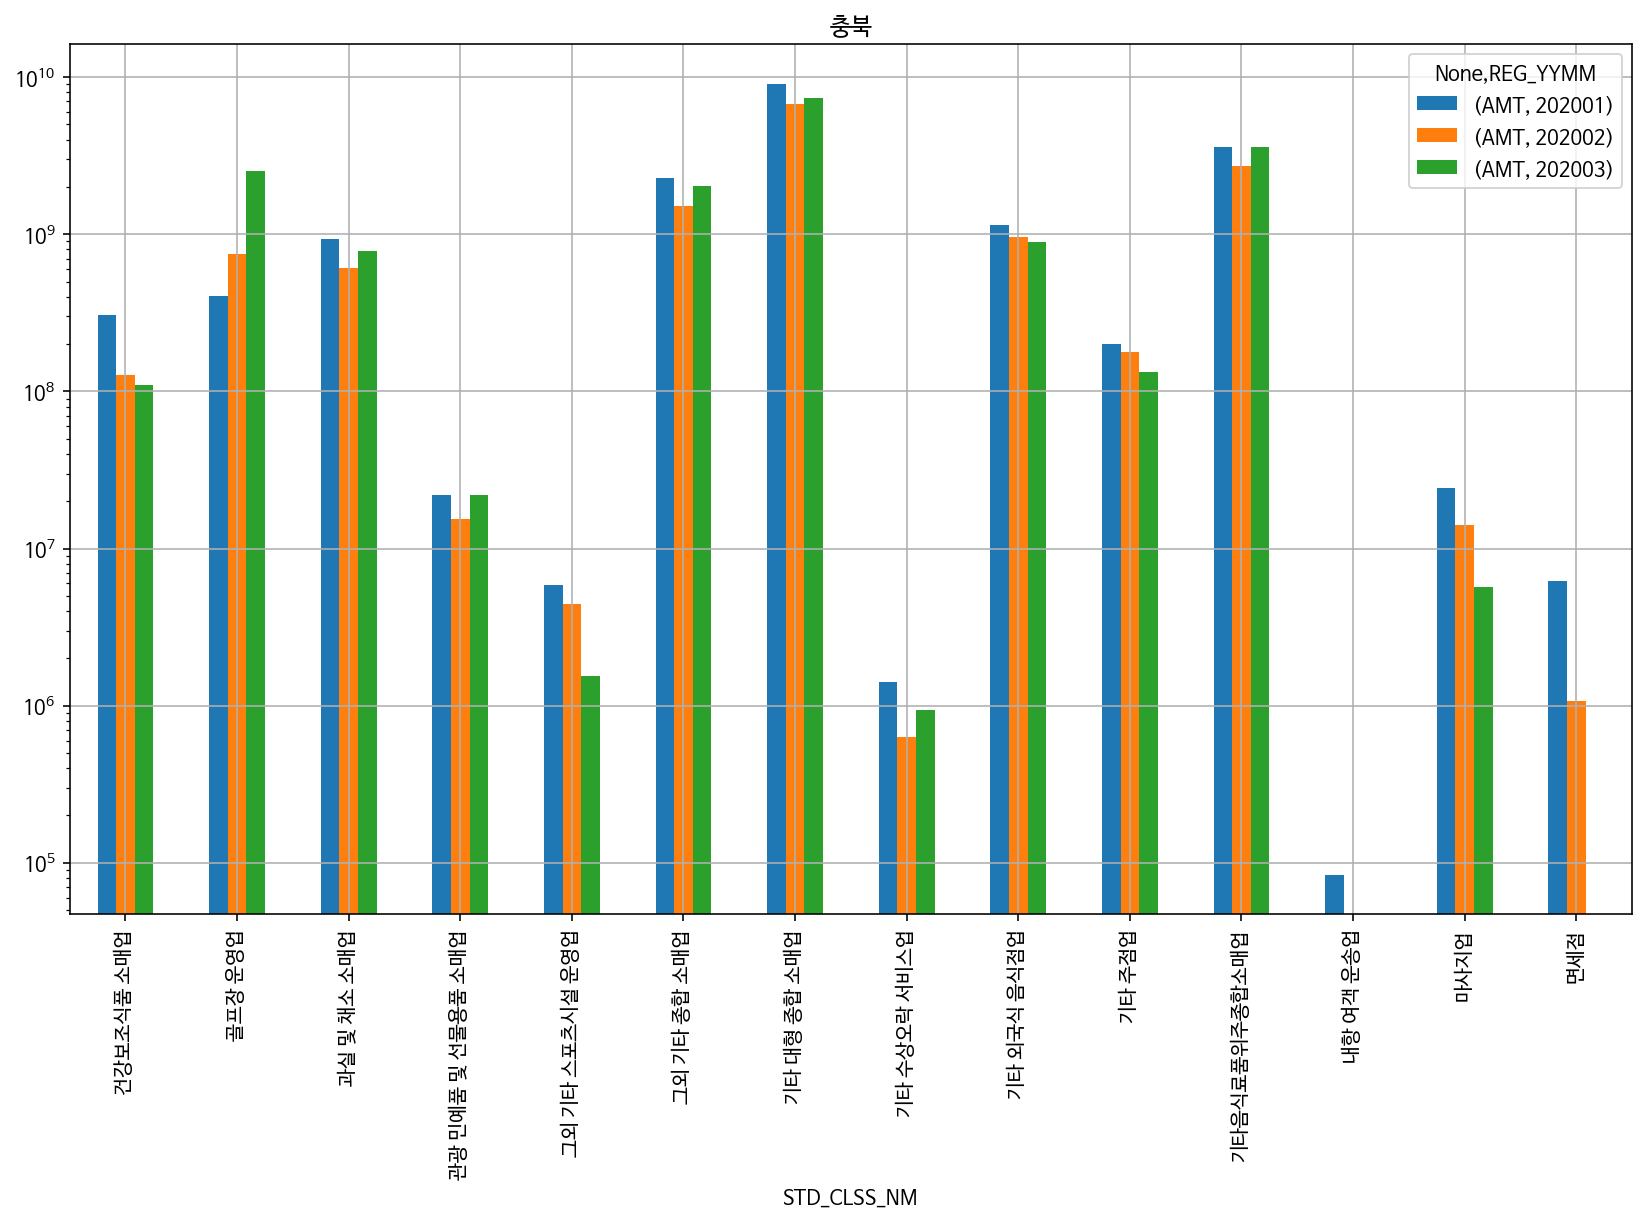

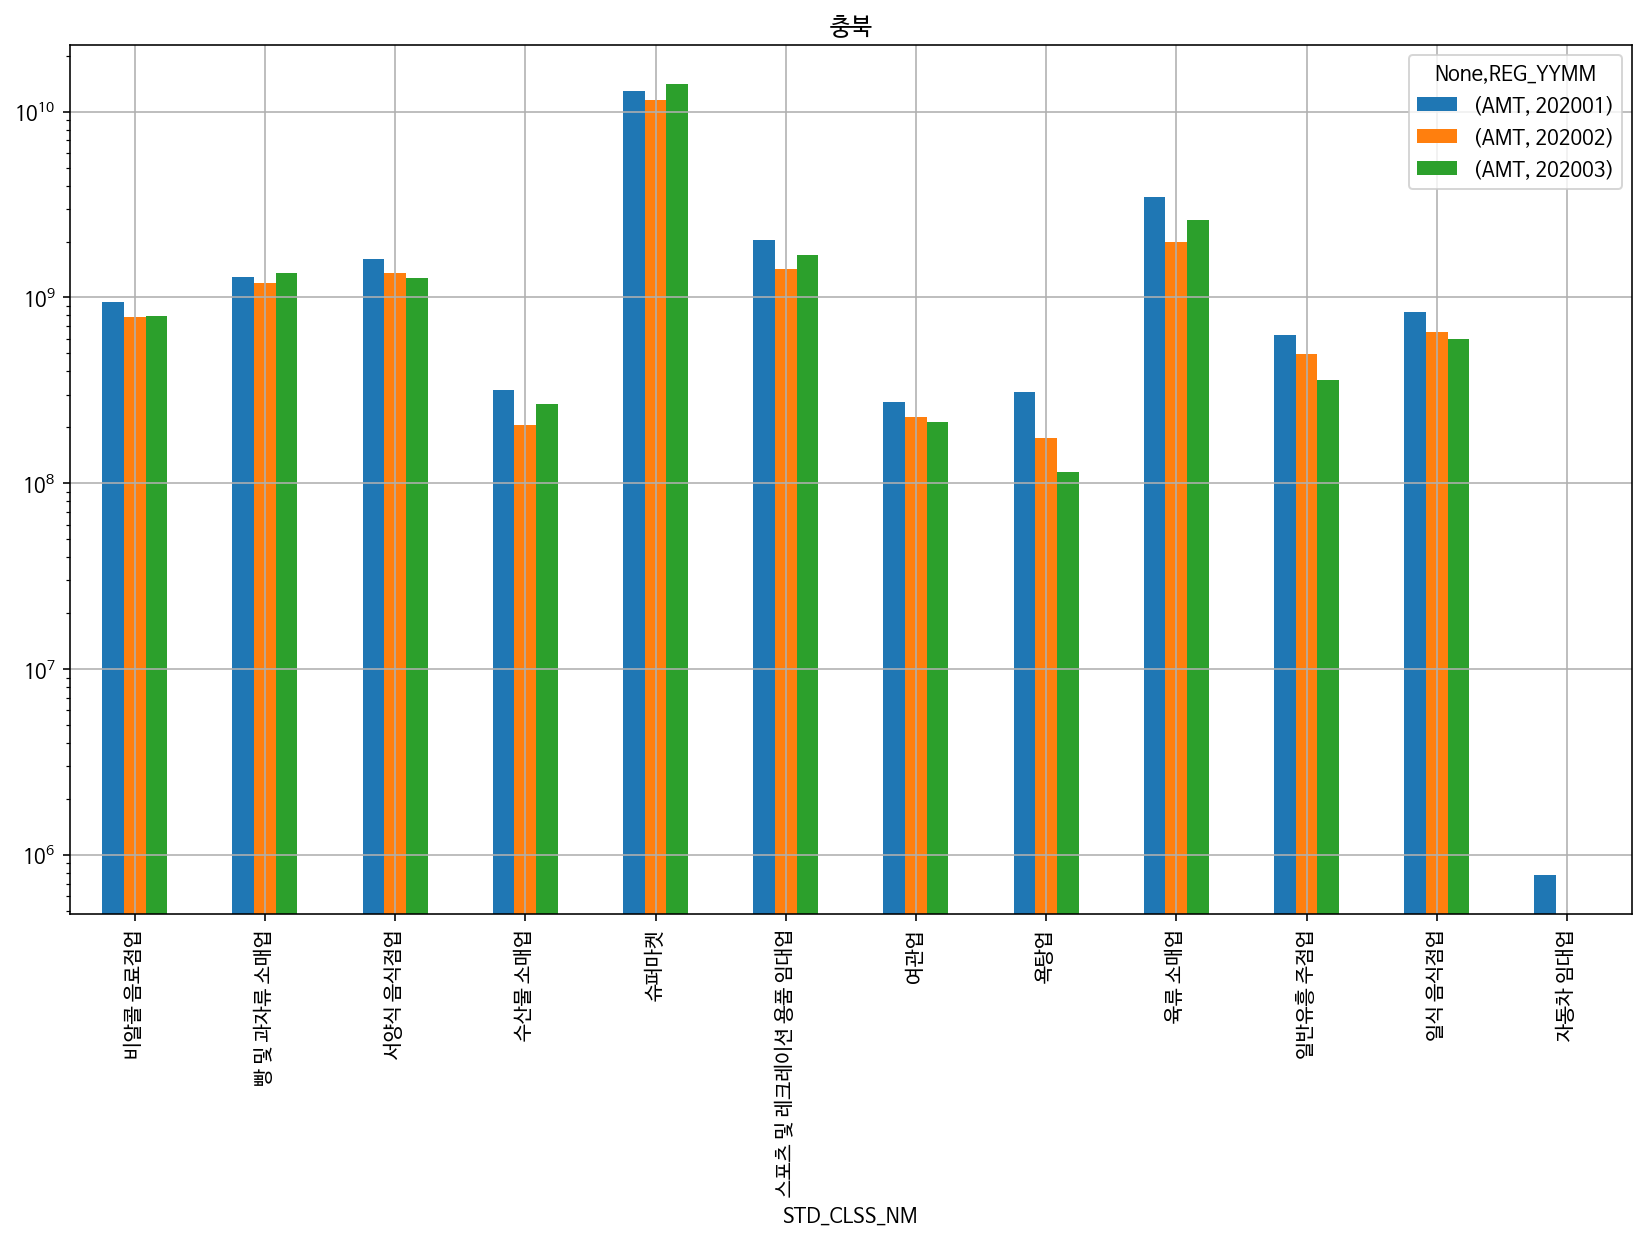

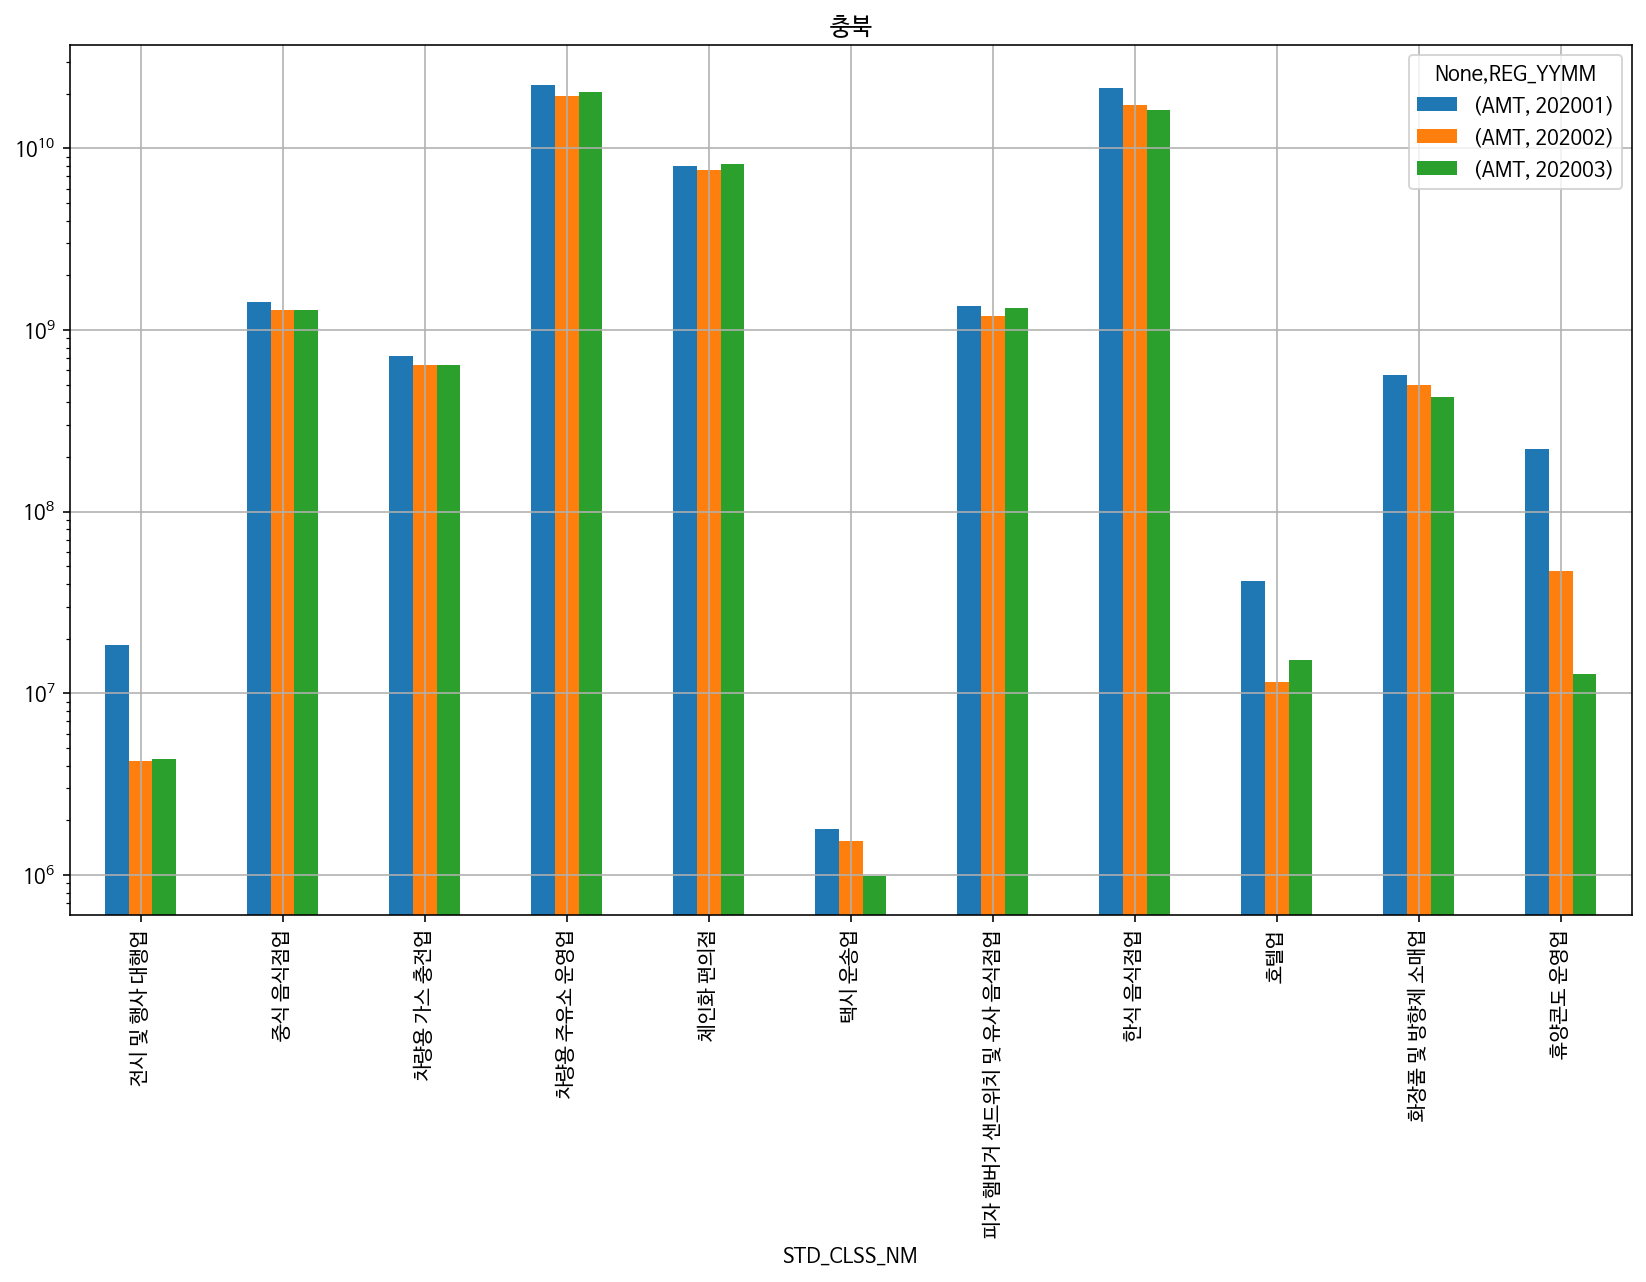

In [ ]:
# 시도별 업종 AMT 변화 그래프
for sido in sido_list:
  temp04 = temp03.loc[temp03['CARD_SIDO_NM'] == sido]
  std_lists = [std_list_01, std_list_02, std_list_03]
  for std in std_lists:
    tmp = temp04[temp04['STD_CLSS_NM'].isin(std)]
    tmp.groupby(['STD_CLSS_NM', 'REG_YYMM']).sum().unstack().plot.bar()
    plt.yscale('log')
    plt.title(sido)